In [88]:
%reload_ext autoreload
%autoreload 2

from novelty_detection.baselines.libhebbian import *
import time
from novelty_detection.metrics import *
from novelty_detection.baselines.libica import *
from picard import picard
torch.manual_seed(123)


def show_filters_color(W, space=1, C=3):
    C, M, N = C, W.shape[0]/C, W.shape[1]
    shape = (C, int(np.sqrt(M)), int(np.sqrt(M)))
    
    grid = int(np.sqrt(N))
    im_c, im_h, im_w = C, (shape[1] + space), (shape[2] + space)
    
    IM = np.zeros( (C, grid * im_h, grid * (im_w)) )

    for i in range(grid):
        for j in range(grid):
            im_padded = np.ones((im_c, im_h, im_w))
            w = W.T[i+(j*grid)].reshape(shape)
            w = (w - w.min()) / (w.max() - w.min())
            im_padded[:, :shape[1], :shape[2]] = w
            IM[:, i*im_h: (i+1)*im_h, j*im_w: (j+1)*im_w] = im_padded
    IM = IM.transpose(1,2,0).squeeze()
    if IM.ndim == 3:
        plt.imshow(IM)
    else:
        plt.imshow(IM, cmap="gray")
        
    plt.axis('off')

def kurt(S):
    return kurtosis(S,  0).mean()

def logcosh_normalized(x):
    """
    negative log-probability
    """
    return (-2*np.log(np.cosh(np.pi/(2*np.sqrt(3))*x)) - 4*np.sqrt(3)/(np.pi)) # soft hat

def logcoshn(x):
    """
    log-probability
    """
    return np.log(np.cosh(1.2 * x) + 1e-5)/1.2

def expn(x):
    return -np.exp(-0.99/2*x**2)/0.99

from hugeica.nn.Loss import Loss
y = Loss.GAMMA.cpu().numpy().copy()
def negentropy(Z, G_fun, y=y):
    """
    https://ieeexplore.ieee.org/abstract/document/5226546
    """
    y = y - y.mean(0)
    y = y / y.std(0)
    
    Z = Z - Z.mean(0)
    Z = Z / Z.std(0)
        
    E_G_z = G_fun(Z).mean(0) 
    E_G_g = G_fun(y).mean(0) 
    
    J_z = (E_G_z - E_G_g)**2
    return J_z

def mutual_information_approx(Z, G_fun):
    J_z = negentropy(Z, G_fun)
    return -J_z.sum()

from novelty_detection.metrics.mutual_information import *

def rescale_im(IM):
    return (IM - IM.min()) / (IM.max() - IM.min())

def unique_form(W):
    W.T[np.diag(W) < 0] = -W.T[np.diag(W) < 0]
    return W


In [ ]:
from iosdata.cifar_novelty import Cifar10_OneClass
# X, X_valid, _ = Cifar10_OneClass(train_classes=[0,1,2,3,4,5,6,7,8,9], test_classes=[3], z_normalize=False, balance=False)[0]
X, X_valid, _ = Cifar10_OneClass(train_classes=[0,1,2,3,4,5,6,7,8,9], test_classes=[3], z_normalize=False, balance=False)[0]

X_valid_means = X_valid.mean(1, keepdims=True)
X_valid = X_valid - X_valid.mean(1, keepdims=True)                 # DC-Component
X_valid = X_valid / np.linalg.norm(X_valid, axis=1, keepdims=True) # Contrast normalization

X_means = X.mean(1, keepdims=True)
X = X - X.mean(1, keepdims=True)                 # DC-Component
X = X / np.linalg.norm(X, axis=1, keepdims=True) # Contrast normalization

X_valid = X_valid - X.mean()                     # Centering
X = X - X.mean()                                 # Centering

X_valid = X_valid / X.std()                     # Scaling
X = X / X.std()                                 # Scaling

k = n_components = 100
d = X.shape[1]
permut = np.random.permutation(len(X))

plt.rcParams["figure.figsize"] = (10,10)
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(rescale_im(X[i].reshape(3, 32,32).transpose(1,2,0)), cmap="gray")
plt.axis("off")

How to center data
https://www.freecodecamp.org/news/https-medium-com-hadrienj-preprocessing-for-deep-learning-9e2b9c75165c/

# Mixing Matrix



## sub-vs super-gaussian

In [5]:
s_sup = np.random.laplace( 0,1,1000).reshape(1, -1) 
s_sub = np.random.laplace( 0,1,1000).reshape(1, -1) 
s_sub2= np.random.laplace( 0,1,1000).reshape(1, -1) 
s = np.vstack([s_sup, s_sub, s_sub2])
Loss.Kurtosis(s.T), Loss.NegentropyLossNumpy(s.T)

(array([2.37161359, 2.13291841, 2.90172123]), array(-0.11587607))

In [6]:
s_sup = np.random.uniform(0,1,1000).reshape(1, -1) 
s_sub = np.random.uniform( 0,1,1000).reshape(1, -1) 
s_sub2= np.random.uniform( 0,1,1000).reshape(1, -1) 
s = np.vstack([s_sup, s_sub, s_sub2])
Loss.Kurtosis(s.T), Loss.NegentropyLossNumpy(s.T)

(array([-1.23913219, -1.21483504, -1.2522765 ]), array(-0.15828932))

  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.2141 - validation (loss/white/kurt/mi/logp): -0.0003 / 0.00 / 0.85 / -0.0003 / 0.4059 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0003 - validation (loss/white/kurt/mi/logp): -0.0004 / 0.00 / 0.74 / -0.0004 / 0.4069 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0004 - validation (loss/white/kurt/mi/logp): -0.0006 / 0.00 / 0.71 / -0.0006 / 0.4071 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0006 - validation (loss/white/kurt/mi/logp): -0.0008 / 0.00 / 0.74 / -0.0008 / 0.4066 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0008 - validation (loss/white/kurt/mi/logp): -0.0010 / 0.00 / 0.81 / -0.0010 / 0.4057 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0010 - validation (loss/white/kurt/mi/logp): -0.0012 / 0.00 / 0.90 / -0.0012 / 0.4046 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0012 - validation (loss/wh

  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - 0.1020 - validation (loss/white/kurt/mi/logp): 0.1008 / 0.00 / 1.47 / -0.7392 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - 0.1008 - validation (loss/white/kurt/mi/logp): 0.0998 / 0.00 / 1.52 / -0.7411 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - 0.0998 - validation (loss/white/kurt/mi/logp): 0.0992 / 0.00 / 1.56 / -0.7425 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - 0.0992 - validation (loss/white/kurt/mi/logp): 0.0990 / 0.00 / 1.58 / -0.7433 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - 0.0990 - validation (loss/white/kurt/mi/logp): 0.0991 / 0.00 / 1.59 / -0.7437 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - 0.0991 - validation (loss/white/kurt/mi/logp): 0.0994 / 0.00 / 1.59 / -0.7437 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - 0.0994 - validation (loss/white/kurt/mi/l

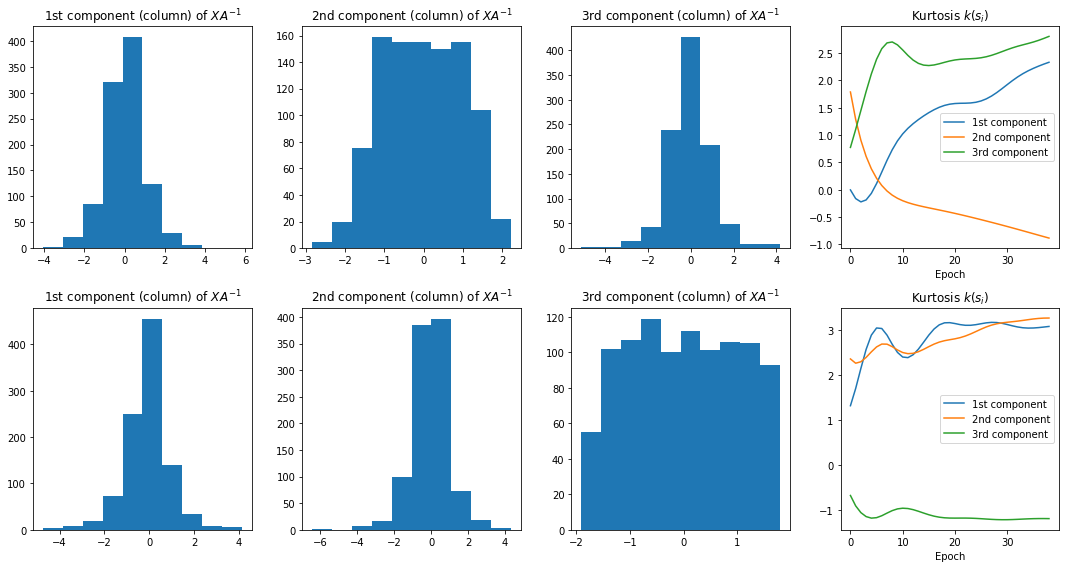

In [8]:
import matplotlib2tikz
from fasterica import *

torch.set_default_tensor_type(torch.FloatTensor)

plt.rcParams["figure.figsize"] = (15,8)

A = np.asarray([[-0.6, 0.1, 0.5],[-0.5, 0.9, 0.2],[-0.7, 0.2, -0.33]])

np.random.seed(1337)
s_sup = np.random.uniform(-2,2,1000).reshape(1, -1) 
s_sub = np.random.laplace( 0,1,1000).reshape(1, -1) 
s_sub2= np.random.laplace( 0,1,1000).reshape(1, -1) 
s = np.vstack([s_sup, s_sub, s_sub2])
D = A @ s

torch.manual_seed(123)

model = FasterICA(3, loss="negentropy_logcosh", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="lie")

grad_list_entropy = []
for ep in range(1,40,1):
    res = np.asarray(model.fit(D.astype(np.float32).T, lr=1e-1, epochs=1, bs=1000, logging=1))
    grads = model.optim.state[model.optim.param_groups[1]["params"][0]]["exp_avg"]
    grad_list_entropy.append(grads.clone().detach())
U = model.unmixing_matrix
D1 = D.T @ U
    
model = FasterICA(3, loss="adaptivelogcoshK", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="lie")
 
grad_list = []
for ep in range(1,40,1):
    res2 = np.asarray(model.fit(D.astype(np.float32).T, lr=1e-1, epochs=1, bs=1000, logging=1))
    grads = model.optim.state[model.optim.param_groups[1]["params"][0]]["exp_avg"]
    grad_list.append(grads.clone().detach())
U = model.unmixing_matrix
D2 = D.T @ U

plt.subplot(2,4,1)
plt.title("1st component (column) of $XA^{-1}$")
plt.hist(D1.T[0])
plt.subplot(2,4,2)
plt.title("2nd component (column) of $XA^{-1}$")
plt.hist(D1.T[1])
plt.subplot(2,4,3)
plt.title("3rd component (column) of $XA^{-1}$")
plt.hist(D1.T[2])
plt.subplot(2,4,4)
plt.title("Kurtosis $k(s_i)$")
plt.plot(range(39),np.asarray([s for s in res.T[3]]).T[0], label="1st component")
plt.plot(range(39),np.asarray([s for s in res.T[3]]).T[1], label="2nd component")
plt.plot(range(39),np.asarray([s for s in res.T[3]]).T[2], label="3rd component")
plt.xlabel("Epoch")
plt.legend()


plt.subplot(2,4,5)
plt.title("1st component (column) of $XA^{-1}$")
plt.hist(D2.T[0])
plt.subplot(2,4,6)
plt.title("2nd component (column) of $XA^{-1}$")
plt.hist(D2.T[1])
plt.subplot(2,4,7)
plt.title("3rd component (column) of $XA^{-1}$")
plt.hist(D2.T[2])
plt.subplot(2,4,8)
plt.title("Kurtosis $k(s_i)$")
plt.plot(range(39),np.asarray([s for s in res2.T[3]]).T[0], label="1st component")
plt.plot(range(39),np.asarray([s for s in res2.T[3]]).T[1], label="2nd component")
plt.plot(range(39),np.asarray([s for s in res2.T[3]]).T[2], label="3rd component")
plt.xlabel("Epoch")
#plt.ylabel("Loss")
plt.tight_layout()
plt.legend()
matplotlib2tikz.save("test.tex")

Text(0.5, 1.0, 'Values of the three parameters $exp_avg$ from $so(3)$ with kurtosis switch')

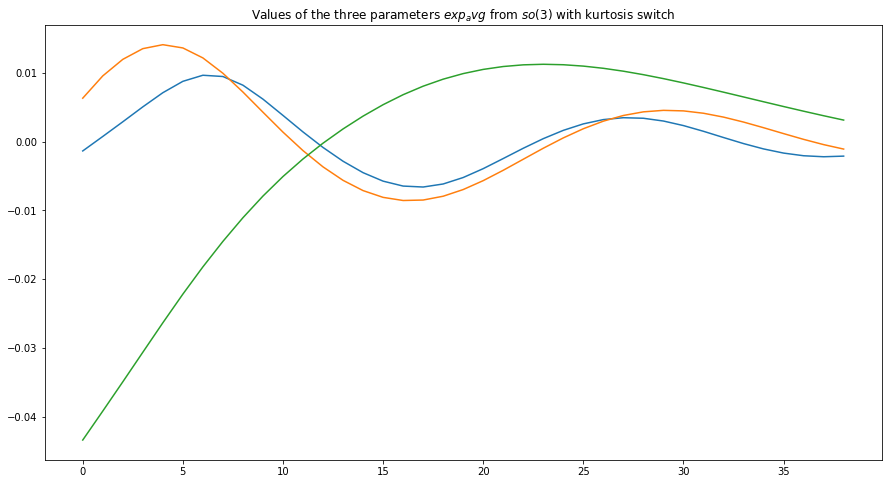

In [9]:
grads = np.asarray([g.cpu().numpy() for g in grad_list])
plt.plot(grads)
plt.title("Values of the three parameters $exp_avg$ from $so(3)$ with kurtosis switch")

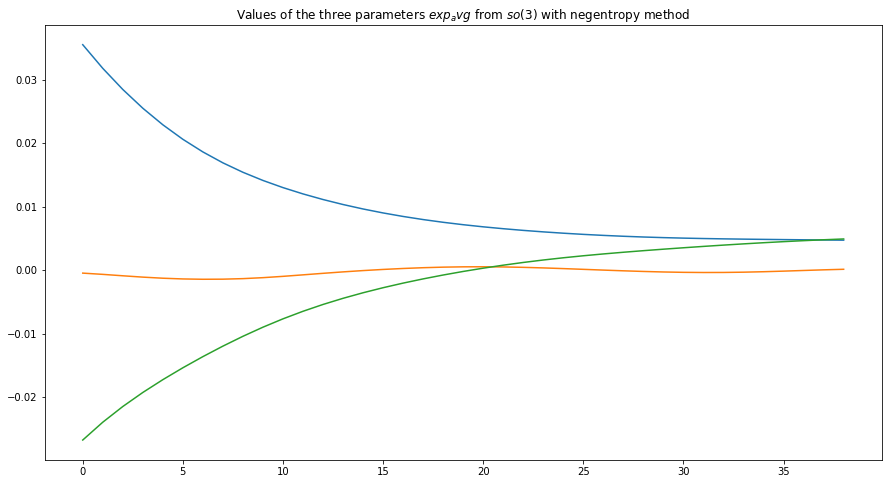

In [10]:
plt.title("Values of the three parameters $exp_avg$ from $so(3)$ with negentropy method")
grads = np.asarray([g.cpu().numpy() for g in grad_list_entropy])
plt.plot(grads)

In [11]:
import matplotlib2tikz
from fasterica import *
plt.rcParams["figure.figsize"] = (15,8)


S = np.hstack([np.random.uniform(-2, 2, (1000, 2)), np.random.laplace(0, 1, (1000, 2))])

A = np.random.normal(0, 0.1, (4, 100))

X = S @ A

model1 = FasterICA(4, loss="negentropy_exp", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="lie")
model2 = FasterICA(4, loss="adaptiveexpK", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="lie", optimizer="adam")

grad_list_entropy = []
grad_list = []
for ep in range(1,75,1):
    res1 = np.asarray(model1.fit(X.astype(np.float32), lr=1e-1, epochs=1, bs=1000, logging=1))
    res2 = np.asarray(model2.fit(X.astype(np.float32), lr=1e-1, epochs=1, bs=1000, logging=1))
    #grads = model1.optim.state[model1.optim.param_groups[1]["params"][0]]["exp_avg"]
    #grad_list_entropy.append(grads.clone().detach())    
    grads = model2.optim.state[model2.optim.param_groups[1]["params"][0]]["exp_avg"]
    grad_list.append(grads.clone().detach())   

  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.3138 - validation (loss/white/kurt/mi/logp): -0.0014 / 0.00 / 0.06 / -0.0014 / -0.7135 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -1.0017 - validation (loss/white/kurt/mi/logp): -0.0076 / 0.00 / 0.10 / -4.0938 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0014 - validation (loss/white/kurt/mi/logp): -0.0023 / 0.00 / 0.02 / -0.0023 / -0.7112 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0076 - validation (loss/white/kurt/mi/logp): -0.0116 / 0.00 / 0.09 / -4.0641 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0023 - validation (loss/white/kurt/mi/logp): -0.0036 / 0.00 / -0.03 / -0.0036 / -0.7090 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0116 - validation (loss/white/kurt/mi/logp): -0.0169 / 0.00 / 0.08 / -4.0262 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0036 - validation (los

  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0088 - validation (loss/white/kurt/mi/logp): -0.0088 / 0.00 / 0.43 / -0.0088 / -0.7171 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0463 - validation (loss/white/kurt/mi/logp): -0.0464 / 0.00 / 0.42 / -3.8824 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0088 - validation (loss/white/kurt/mi/logp): -0.0088 / 0.00 / 0.42 / -0.0088 / -0.7172 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0464 - validation (loss/white/kurt/mi/logp): -0.0464 / 0.00 / 0.42 / -3.8823 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0088 - validation (loss/white/kurt/mi/logp): -0.0088 / 0.00 / 0.42 / -0.0088 / -0.7172 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0464 - validation (loss/white/kurt/mi/logp): -0.0464 / 0.00 / 0.42 / -3.8822 / 0.0000 (eval took: 0.0s)
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0088 - validation (loss

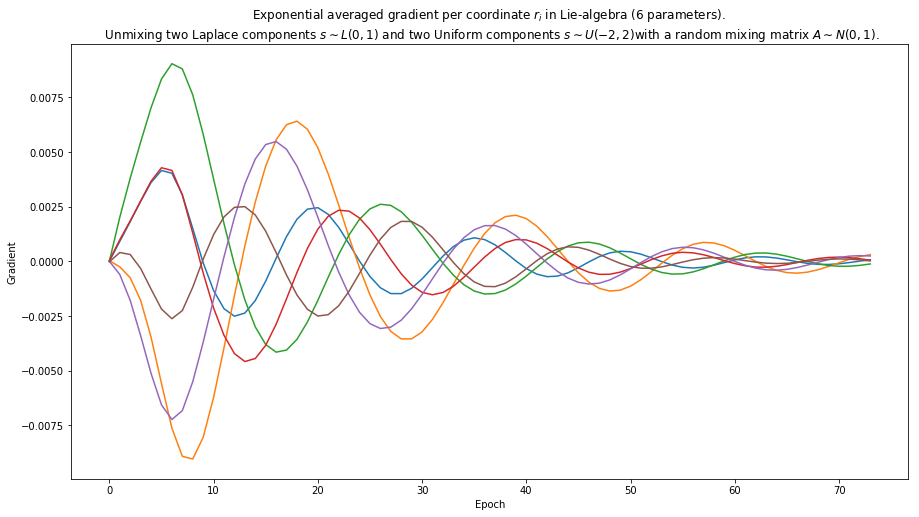

In [12]:
plt.title("Exponential averaged gradient per coordinate $r_i$ in Lie-algebra (6 parameters). \n Unmixing two Laplace components $s \sim L(0,1)$ and two Uniform components $s \sim U(-2,2)$with a random mixing matrix $A \sim N(0,1)$.")
grads = np.asarray([g.cpu().numpy() for g in grad_list])
plt.plot(grads)
plt.xlabel("Epoch")
plt.ylabel("Gradient")
matplotlib2tikz.save("gradient.tex")


In [187]:
loss = np.asarray([np.asarray(k) for k in res2[:,1]])
plt.plot(loss[2:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
matplotlib2tikz.save("Loss.tex")

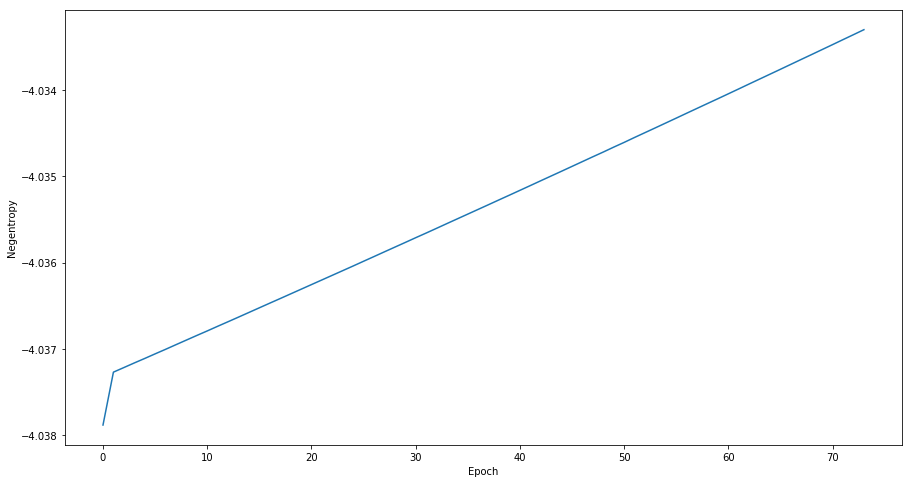

In [14]:
loss = np.asarray([np.asarray(k.cpu()) for k in res2[:,4]])
plt.plot(loss[0:])
plt.xlabel("Epoch")
plt.ylabel("Negentropy")
matplotlib2tikz.save("MI.tex")

In [15]:
kurts = np.asarray([np.asarray(k) for k in res2[:,3]])
plt.plot(kurts)
plt.show()

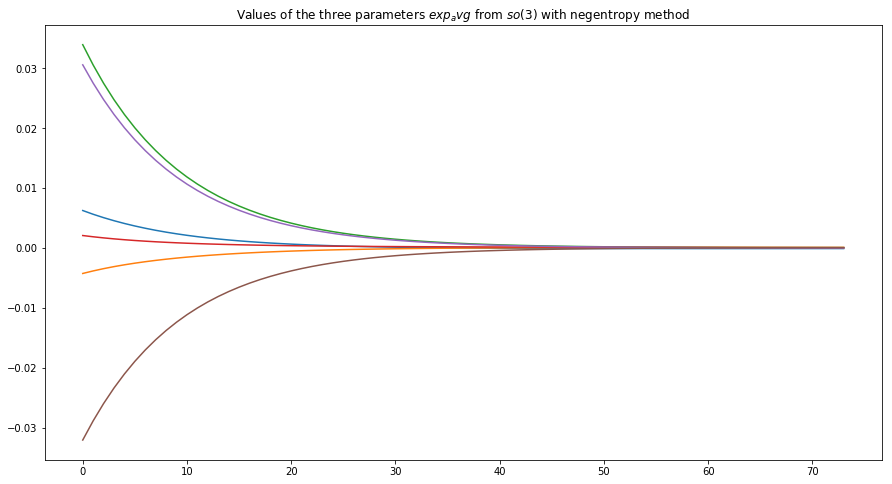

In [473]:
plt.title("Values of the three parameters $exp_avg$ from $so(3)$ with negentropy method")
grads = np.asarray([g.cpu().numpy() for g in grad_list_entropy])
plt.plot(grads)
plt.show()

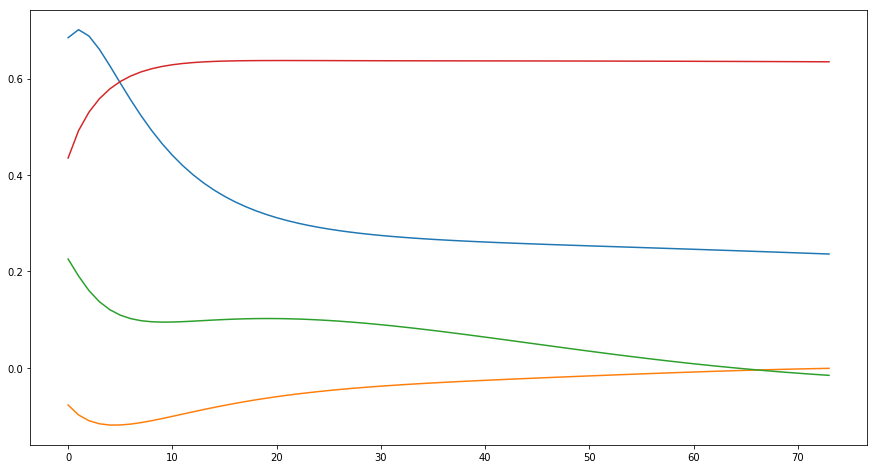

In [474]:
kurts = np.asarray([np.asarray(k) for k in res1[:,3]])
plt.plot(kurts)
plt.show()

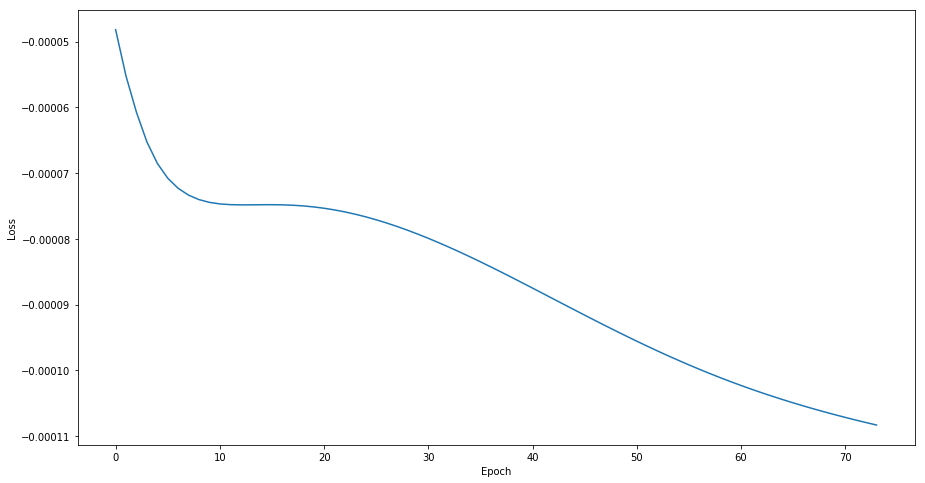

In [475]:
loss = np.asarray([np.asarray(k.cpu()) for k in res1[:,4]])
plt.plot(loss[:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
matplotlib2tikz.save("Loss.tex")

In [147]:
import matplotlib2tikz
from fasterica import *
from scipy import signal

plt.rcParams["figure.figsize"] = (15,8)

np.random.seed(42)
torch.manual_seed(42)

torch.set_default_tensor_type(torch.cuda.DoubleTensor)

x = np.linspace(-1, 1, 30000)
s1 = 10e-6*np.sin(350*x)*np.sin(60*x)
s2 = 10e-5*signal.sawtooth(70*x)
s3 = 10e-4*np.sin(800*x)*np.sin(80*x)
s4 = 10e-5*np.cos(400*x + 4*np.cos(60*x))
s5 = np.random.uniform(-1,1, len(x))

S = np.stack([s1,s2,s3,s4,s5]).T

S = S - S.mean(0)
S = S / S.std(0)

A = scipy.linalg.hilbert(5)

X = S @ A

X = X - X.mean(0)
X = X / X.std(0)

#model1 = FasterICA(5, loss="negentropy_logcosh", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="lie")
model2 = FasterICA(5, loss="adaptiveexpK", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="lie", optimizer="adam")

grad_list_entropy = []
grad_list = []
amaris = []
for ep in range(1,50,1):
    #res1 = np.asarray(model1.fit(X.astype(np.float32), lr=1e-2, epochs=1, bs=1000, logging=1))
    res2 = np.asarray(model2.fit(X, lr=1e-4, epochs=1, bs=30, logging=1))
    #rads = model1.optim.state[model1.optim.param_groups[1]["params"][0]]["exp_avg"]
    #grad_list_entropy.append(grads.clone().detach())    
    grads = model2.optim.state[model2.optim.param_groups[1]["params"][0]]["exp_avg"]
    grad_list.append(grads.clone().detach()) 
    R = (model2.unmixing_matrix.T @ A)**2
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    amaris.append(amari)

100%|█████████▉| 999/1000 [00:09<00:00, 107.62it/s]
Ep.  0 - 0.6733 - validation (loss/white/kurt/mi/logp): 0.6781 / 0.00 / -0.49 / -10.1436 / 0.0000 (eval took: 0.5s)
100%|█████████▉| 999/1000 [00:07<00:00, 127.25it/s]
Ep.  0 - 0.6776 - validation (loss/white/kurt/mi/logp): 0.6770 / 0.00 / -0.51 / -10.1330 / 0.0000 (eval took: 0.4s)
100%|█████████▉| 999/1000 [00:07<00:00, 126.44it/s]
Ep.  0 - 0.6766 - validation (loss/white/kurt/mi/logp): 0.6761 / 0.00 / -0.54 / -10.1185 / 0.0000 (eval took: 0.5s)
100%|█████████▉| 999/1000 [00:07<00:00, 129.09it/s]
Ep.  0 - 0.6758 - validation (loss/white/kurt/mi/logp): 0.6750 / 0.00 / -0.57 / -10.1006 / 0.0000 (eval took: 0.5s)
100%|█████████▉| 999/1000 [00:07<00:00, 128.36it/s]
Ep.  0 - 0.6729 - validation (loss/white/kurt/mi/logp): 0.6718 / 0.00 / -0.61 / -10.0794 / 0.0000 (eval took: 0.4s)
100%|█████████▉| 999/1000 [00:08<00:00, 124.80it/s]
Ep.  0 - 0.6716 - validation (loss/white/kurt/mi/logp): 0.6703 / 0.00 / -0.65 / -10.0553 / 0.0000 (eval took

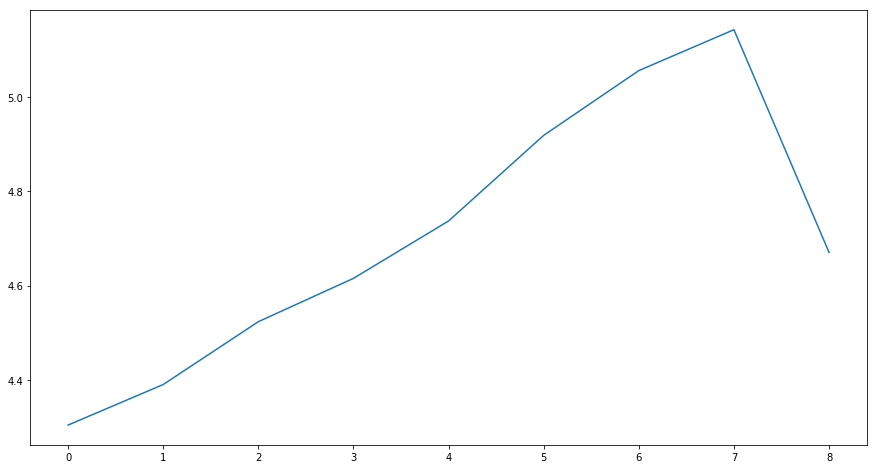

In [146]:
am = np.asarray(amaris)
plt.plot(am)
#plt.ylim(0,2)
plt.show()

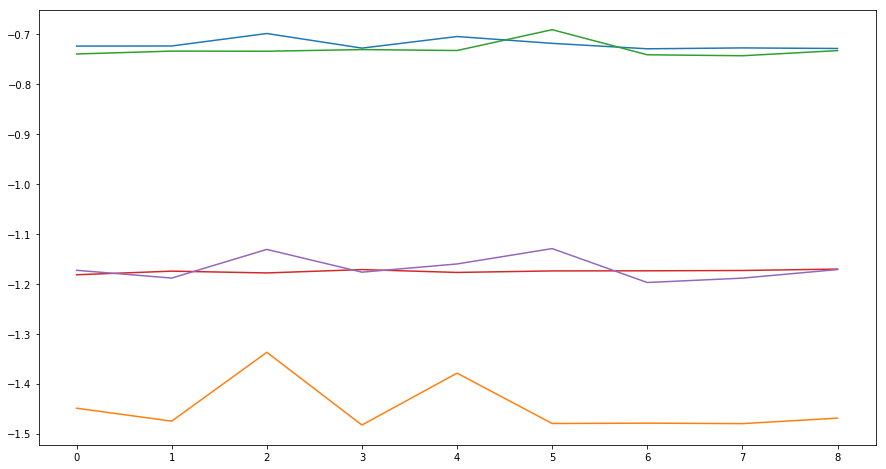

In [142]:
kurts = np.asarray([np.asarray(k) for k in res2[:,3]])
plt.plot(kurts)
plt.show()

In [121]:
loss = np.asarray([np.asarray(k.cpu()) for k in res2[:,4]])
plt.plot(loss[:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
matplotlib2tikz.save("Loss.tex")

## hd-images
https://ieeexplore.ieee.org/abstract/document/5226546

In [3]:
import urllib

def curl(url='https://unsplash.com/photos/FDPRFKTdyb0/download?force=true', name="./data/luisabrimble.webp"):
    filedata = urllib.request.urlopen(url)
    datatowrite = filedata.read()
    with open(name, 'wb') as f:
        f.write(datatowrite)

curl('https://unsplash.com/photos/FDPRFKTdyb0/download?force=true', './data/luisabrimble.webp' )
curl('https://unsplash.com/photos/NqxY29lkNSU/download?force=true', './data/kumpan_electric.webp' )
curl('https://unsplash.com/photos/wyZi9MVqEdQ/download?force=true', './data/bapt_g.webp' )

!ls -alh ./data/

HTTPError: HTTP Error 404: Not Found

In [1]:
# https://developers.google.com/speed/webp/gallery1
for i in range(1,6):
    !curl https://www.gstatic.com/webp/gallery/{i}.jpg > ./data/{i}.jpg
!ls ./data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44891  100 44891    0     0   528k      0 --:--:-- --:--:-- --:--:--  528k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 88316  100 88316    0     0  1487k      0 --:--:-- --:--:-- --:--:-- 1487k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  297k  100  297k    0     0  2091k      0 --:--:-- --:--:-- --:--:-- 2077k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  251k  100  251k    0     0  2510k      0 --:--:-- --:--:-- --:--:-- 2510k
  % Total    % Received % Xferd  Average Speed   Tim

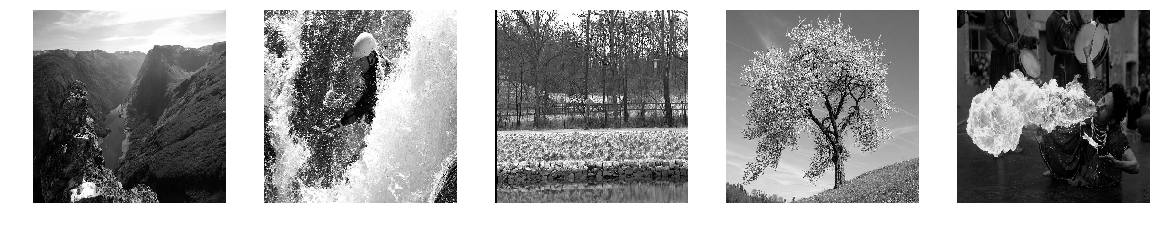

(0.0, 0.980262745098039, None)

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams["figure.figsize"] = (20,20)
IMS = []
for i in range(1,6):
    plt.subplot(1,5,i)
    IM = Image.open(f"./data/{i}.jpg")
    IM = IM.resize((200, 200))
    IM = np.asarray(IM)
    IM_grey = (0.299*IM[:,:,0] + 0.587*IM[:,:,1] + 0.114*IM[:,:,2])/255.
    IMS.append(IM_grey)
    plt.imshow(IM_grey, cmap="gray")
    plt.axis("off")
IM_grey.min(), IM_grey.max(), plt.show()

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


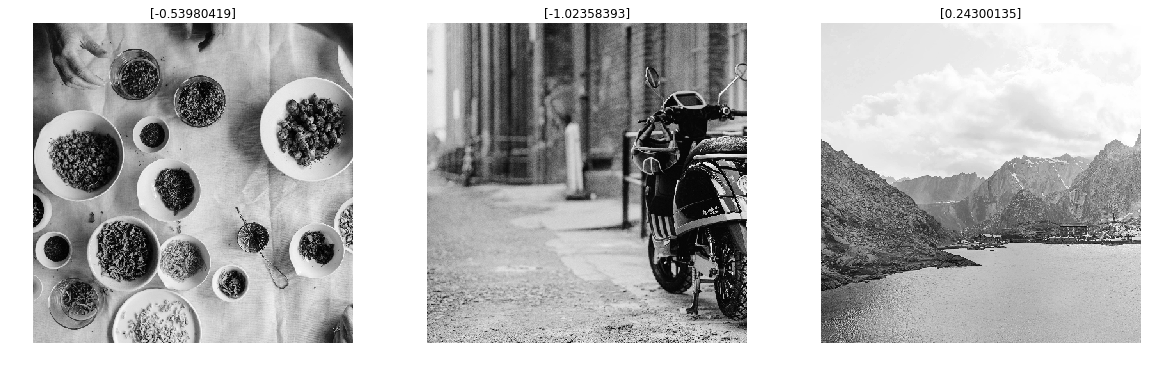

(0.038556862745098036, 1.0, None)

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams["figure.figsize"] = (20,20)
IMS = []
for i,f in enumerate(["luisabrimble.png","kumpan_electric.png","bapt_g.png"]):#, "luisabrimble.jpg", "benjaminjohnelliott.jpg", "eputina.jpg", "evgenit.jpg", "karlleephoto.jpg", "makjp.jpg"][::-1]):
    plt.subplot(3,3,i+1)
    IM = Image.open(f"./data/{f}")
    IM = IM.crop((0,0,min(IM.size),min(IM.size)))
    IM = IM.resize((500, 500))
    IM = np.asarray(IM)
    IM_grey = (0.299*IM[:,:,0] + 0.587*IM[:,:,1] + 0.114*IM[:,:,2])/255.
    IMS.append(IM_grey)
    plt.imshow(IM_grey, cmap="gray")
    plt.axis("off")
    plt.title(kurt(IM.flatten().reshape(-1,1)))
IM_grey.min(), IM_grey.max(), plt.show()

In [5]:
# MIXING MATRIX
A = np.asarray([[0.8311,-0.4464 ,-0.3317],
                [0.1345,0.7401,-0.6589],
                [0.5397,0.5030,0.6751]]).T

#A = np.asarray([A.ravel()[np.random.permutation(range(9))] for i in range(9)]).reshape(9,9)
A.shape

(3, 3)

(3, 250000)


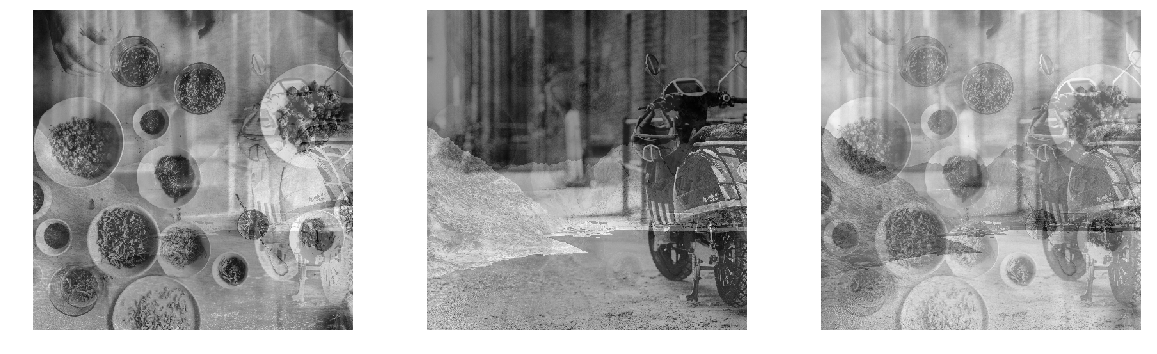

In [6]:
s = 500
n = 3
IMs = np.asarray(IMS[:n]).reshape(n, s*s)
IMs = IMs - IMs.mean(1, keepdims=True) / np.linalg.norm(IMs, axis=1, keepdims=True)  # Remove DC, contrast normalize
IM_mix = (IMs.T @ A) .T

plt.rcParams["figure.figsize"] = (20,20)
for i in range(n):
    plt.subplot(3,3,i+1)
    plt.imshow(IM_mix[i].reshape(s,s), cmap="gray")
    plt.axis("off")
print(IMs.shape)

In [7]:
IM_mix.shape
IM_mix = IM_mix.T
IM_mix.shape
IM_mix = IM_mix - IM_mix.mean(0)
IM_mix.shape

(250000, 3)

In [12]:
means = IM_mix.mean(0)

_, W_white, _ = fit_pca(IM_mix - means, n, True)
M_white = (IM_mix - means) @ W_white
M_white.shape, means

((250000, 3), array([-3.23665983e-16, -3.08284120e-16,  5.33819433e-15]))

(<matplotlib.image.AxesImage at 0x7f6a6a10f080>,
 array([ 4.37128556e-16, -5.43268541e-16, -5.03898034e-16]),
 (250000, 3),
 array([0.999998, 0.999998, 0.999998]))

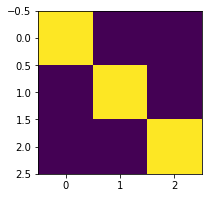

In [13]:
plt.rcParams["figure.figsize"] = (3,3)
plt.imshow(np.cov(M_white.T)), M_white.mean(0), M_white.shape, M_white.std(0)

In [118]:
from mmica import solver_incremental

vals = []

np.random.seed(123)

M = (M_white.astype(np.float32).T)

for i in range(2):
    W = solver_incremental(IM_mix.T, max_iter=10000, batch_size=1000, greedy=0., W_init=W_white.T)
    U = W.T
    U = unique_form(U) 
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est) 
    A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U
    
    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"MM & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

Frobenius 1.20475874826968 MaxCorrelation 0.2899405528763078 Negentr -0.00044063241047225606 Amari 4.576500870194971
Frobenius 1.20475874826968 MaxCorrelation 0.2899405528763078 Negentr -0.00044063241047225606 Amari 4.576500870194971


'MM & $-4.00e-04\\pm0.00e+00$ & $2.90e-01\\pm0.00e+00$ & $1.20e+00\\pm0.00e+00$ & $4.58e+00\\pm0.00e+00$ \\'

In [119]:
vals = []

np.random.seed(123)

for i in range(10):
    ica = FastICA(whiten=False, max_iter=10000, fun="exp").fit(M_white.astype(np.float32))
    W = ica.components_.T
    U = W_white @ W
    U = unique_form(U) 
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est) 
    #A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U
    
    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"FastICA & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

Frobenius 1.7366496780899907 MaxCorrelation 0.3666530177314958 Negentr -0.0033166064097124174 Amari 6.332321857775117
Frobenius 1.5391835184311102 MaxCorrelation 0.3232798443307197 Negentr -0.0022467526436874127 Amari 6.672126233762123
Frobenius 1.8061367239119226 MaxCorrelation 0.323153287305068 Negentr -0.0022437639761165376 Amari 5.290915249678597
Frobenius 1.699448226389673 MaxCorrelation 0.32354098834930806 Negentr -0.0022609276657151404 Amari 4.110843863023609
Frobenius 1.613024102434768 MaxCorrelation 0.3232546414745047 Negentr -0.0022481585119179886 Amari 4.863379708761061
Frobenius 1.8064101213772006 MaxCorrelation 0.3230376556370565 Negentr -0.0022398633948899384 Amari 5.286082407577623
Frobenius 1.6542998466250527 MaxCorrelation 0.3662568200554223 Negentr -0.0033181634995778984 Amari 5.477796315577185
Frobenius 1.683340586226287 MaxCorrelation 0.3666076536467502 Negentr -0.0033162597204870123 Amari 5.447422359159285
Frobenius 1.4106092745947492 MaxCorrelation 0.3231989706185

'FastICA & $-2.70e-03\\pm5.00e-04$ & $3.41e-01\\pm2.11e-02$ & $1.66e+00\\pm1.14e-01$ & $5.52e+00\\pm7.13e-01$ \\'

In [121]:
torch.manual_seed(123)

vals = []
for i in range(10):
    model = HugeICA(n, loss="adaptiveexpK", optimistic_whitening_rate=1.0, whitening_strategy="batch")
    res2 = model.fit(IM_mix.astype(np.float32), lr=1e-0, epochs=150, bs=len(IM_mix)//1, logging=1)
    U = model.unmixing_matrix

    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    #A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"BatchICA (offline, lr=1) & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - 0.3230 - validation (loss/white/kurt/mi/logp): 0.2303 / 0.00 / -0.29 / 2.0747 / 0.0000 (eval took: 0.0s)
Ep.  1 - 0.2303 - validation (loss/white/kurt/mi/logp): 0.6960 / 0.00 / -0.52 / 0.0030 / 0.0000 (eval took: 0.0s)
Ep.  2 - 0.6960 - validation (loss/white/kurt/mi/logp): 0.6908 / 0.00 / -0.66 / 0.0042 / 0.0000 (eval took: 0.0s)
Ep.  3 - 0.6908 - validation (loss/white/kurt/mi/logp): 0.6946 / 0.00 / -0.59 / 0.0031 / 0.0000 (eval took: 0.0s)
Ep.  4 - 0.6946 - validation (loss/white/kurt/mi/logp): 0.6918 / 0.00 / -0.64 / 0.0042 / 0.0000 (eval took: 0.0s)
Ep.  5 - 0.6918 - validation (loss/white/kurt/mi/logp): 0.6890 / 0.00 / -0.70 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep.  6 - 0.6890 - validation (loss/white/kurt/mi/logp): 0.6911 / 0.00 / -0.65 / 0.0043 / 0.0000 (eval took: 0.0s)
Ep.  7 - 0.6911 - validation (loss/white/kurt/mi/logp): 0.6922 / 0.00 / -0.67 / 0.0035 / 0.0000 (eval took: 0.0s)
Ep.  8 - 0.6922 - validation (loss/white/kurt/mi/l

Ep. 73 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 74 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 75 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 76 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 77 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 78 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 79 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 80 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 81 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep.145 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.71 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep.146 - 0.6889 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.70 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep.147 - 0.6889 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.148 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.149 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Frobenius 1.7463045999284952 MaxCorrelation 0.36354014831286224 Negentr -0.003302645758793147 Amari 6.455563382913743
  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - 0.3228 - validation (loss/white/kurt/mi/logp): 0.2207 / 0.00 / -0.33 / 2.1095 / 0.0000 (eval took: 0.0s)
Ep.  1 - 0.2207 - validation (loss/white/kurt/mi/logp): 0.6994 / 0.00 / -0.50 / 0.0020 / 0.0000 (eval took: 0.0s)
Ep.  2 - 0.6994 - validation (loss/white/kurt/

Ep. 67 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 68 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 69 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 70 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 71 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 72 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 73 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 74 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 75 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep.139 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.140 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6890 / 0.00 / -0.71 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep.141 - 0.6890 - validation (loss/white/kurt/mi/logp): 0.6890 / 0.00 / -0.70 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep.142 - 0.6890 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep.143 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.144 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6888 / 0.00 / -0.71 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep.145 - 0.6888 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.71 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep.146 - 0.6889 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.147 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep. 61 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 62 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 63 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 64 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.72 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 65 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.72 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 66 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 67 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 68 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 69 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep.133 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.134 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.135 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.136 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.137 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.138 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.139 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.140 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.141 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep. 55 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.72 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 56 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 57 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 58 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 59 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 60 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.72 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 61 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.72 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 62 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 63 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep.127 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.128 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.129 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.130 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.131 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.132 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.133 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.134 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.135 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep. 49 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 50 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 51 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 52 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 53 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 54 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.72 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 55 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.72 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 56 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 57 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep.121 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.122 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.123 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.124 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.125 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.126 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.127 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.128 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.129 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep. 43 - 0.6889 - validation (loss/white/kurt/mi/logp): 0.6891 / 0.00 / -0.69 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 44 - 0.6891 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.70 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 45 - 0.6889 - validation (loss/white/kurt/mi/logp): 0.6891 / 0.00 / -0.70 / 0.0046 / 0.0000 (eval took: 0.0s)
Ep. 46 - 0.6891 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 47 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 48 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.71 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 49 - 0.6889 - validation (loss/white/kurt/mi/logp): 0.6888 / 0.00 / -0.72 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 50 - 0.6888 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.72 / 0.0046 / 0.0000 (eval took: 0.0s)
Ep. 51 - 0.6889 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.72 / 0.0047 /

Ep.115 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.116 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.117 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.118 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.119 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.120 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.121 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.122 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.123 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep. 37 - 0.6890 - validation (loss/white/kurt/mi/logp): 0.6891 / 0.00 / -0.71 / 0.0046 / 0.0000 (eval took: 0.0s)
Ep. 38 - 0.6891 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 39 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.70 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 40 - 0.6889 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.70 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 41 - 0.6889 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 42 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.71 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 43 - 0.6889 - validation (loss/white/kurt/mi/logp): 0.6888 / 0.00 / -0.71 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 44 - 0.6888 - validation (loss/white/kurt/mi/logp): 0.6887 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 45 - 0.6887 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.71 / 0.0047 /

Ep.109 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.110 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.111 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.112 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.113 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.114 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.115 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.116 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.117 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep. 31 - 0.6893 - validation (loss/white/kurt/mi/logp): 0.6907 / 0.00 / -0.66 / 0.0042 / 0.0000 (eval took: 0.0s)
Ep. 32 - 0.6907 - validation (loss/white/kurt/mi/logp): 0.6897 / 0.00 / -0.67 / 0.0044 / 0.0000 (eval took: 0.0s)
Ep. 33 - 0.6897 - validation (loss/white/kurt/mi/logp): 0.6891 / 0.00 / -0.70 / 0.0046 / 0.0000 (eval took: 0.0s)
Ep. 34 - 0.6891 - validation (loss/white/kurt/mi/logp): 0.6895 / 0.00 / -0.71 / 0.0045 / 0.0000 (eval took: 0.0s)
Ep. 35 - 0.6895 - validation (loss/white/kurt/mi/logp): 0.6894 / 0.00 / -0.72 / 0.0044 / 0.0000 (eval took: 0.0s)
Ep. 36 - 0.6894 - validation (loss/white/kurt/mi/logp): 0.6894 / 0.00 / -0.71 / 0.0044 / 0.0000 (eval took: 0.0s)
Ep. 37 - 0.6894 - validation (loss/white/kurt/mi/logp): 0.6896 / 0.00 / -0.69 / 0.0045 / 0.0000 (eval took: 0.0s)
Ep. 38 - 0.6896 - validation (loss/white/kurt/mi/logp): 0.6888 / 0.00 / -0.71 / 0.0047 / 0.0000 (eval took: 0.0s)
Ep. 39 - 0.6888 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.71 / 0.0047 /

Ep.103 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.104 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.105 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.106 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.107 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.108 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.109 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.110 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.111 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep. 25 - 0.6949 - validation (loss/white/kurt/mi/logp): 0.6918 / 0.00 / -0.67 / 0.0038 / 0.0000 (eval took: 0.0s)
Ep. 26 - 0.6918 - validation (loss/white/kurt/mi/logp): 0.6932 / 0.00 / -0.64 / 0.0033 / 0.0000 (eval took: 0.0s)
Ep. 27 - 0.6932 - validation (loss/white/kurt/mi/logp): 0.6912 / 0.00 / -0.68 / 0.0040 / 0.0000 (eval took: 0.0s)
Ep. 28 - 0.6912 - validation (loss/white/kurt/mi/logp): 0.6913 / 0.00 / -0.64 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 29 - 0.6913 - validation (loss/white/kurt/mi/logp): 0.6925 / 0.00 / -0.59 / 0.0039 / 0.0000 (eval took: 0.0s)
Ep. 30 - 0.6925 - validation (loss/white/kurt/mi/logp): 0.6904 / 0.00 / -0.65 / 0.0043 / 0.0000 (eval took: 0.0s)
Ep. 31 - 0.6904 - validation (loss/white/kurt/mi/logp): 0.6900 / 0.00 / -0.68 / 0.0044 / 0.0000 (eval took: 0.0s)
Ep. 32 - 0.6900 - validation (loss/white/kurt/mi/logp): 0.6923 / 0.00 / -0.63 / 0.0040 / 0.0000 (eval took: 0.0s)
Ep. 33 - 0.6923 - validation (loss/white/kurt/mi/logp): 0.6903 / 0.00 / -0.67 / 0.0045 /

Ep. 97 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 98 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 99 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.100 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.101 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.102 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.103 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.104 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep.105 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

Ep. 19 - 0.6948 - validation (loss/white/kurt/mi/logp): 0.6962 / 0.00 / -0.57 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 20 - 0.6962 - validation (loss/white/kurt/mi/logp): 0.6937 / 0.00 / -0.63 / 0.0032 / 0.0000 (eval took: 0.0s)
Ep. 21 - 0.6937 - validation (loss/white/kurt/mi/logp): 0.6896 / 0.00 / -0.71 / 0.0043 / 0.0000 (eval took: 0.0s)
Ep. 22 - 0.6896 - validation (loss/white/kurt/mi/logp): 0.6894 / 0.00 / -0.69 / 0.0046 / 0.0000 (eval took: 0.0s)
Ep. 23 - 0.6894 - validation (loss/white/kurt/mi/logp): 0.6912 / 0.00 / -0.65 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 24 - 0.6912 - validation (loss/white/kurt/mi/logp): 0.6929 / 0.00 / -0.61 / 0.0034 / 0.0000 (eval took: 0.0s)
Ep. 25 - 0.6929 - validation (loss/white/kurt/mi/logp): 0.6924 / 0.00 / -0.62 / 0.0035 / 0.0000 (eval took: 0.0s)
Ep. 26 - 0.6924 - validation (loss/white/kurt/mi/logp): 0.6896 / 0.00 / -0.68 / 0.0045 / 0.0000 (eval took: 0.0s)
Ep. 27 - 0.6896 - validation (loss/white/kurt/mi/logp): 0.6889 / 0.00 / -0.71 / 0.0047 /

Ep. 91 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 92 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 93 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 94 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 95 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 96 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 97 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 98 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 / 0.0000 (eval took: 0.0s)
Ep. 99 - 0.6886 - validation (loss/white/kurt/mi/logp): 0.6886 / 0.00 / -0.71 / 0.0048 /

'BatchICA (offline, lr=1) & $-3.30e-03\\pm0.00e+00$ & $3.66e-01\\pm9.00e-04$ & $1.64e+00\\pm1.69e-01$ & $4.45e+00\\pm1.44e+00$ \\'

In [122]:
from hugeica import *
torch.manual_seed(123)


vals = []
for i in range(2):
    model = HugeICA(3, loss="adaptiveexpK", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="lie")
    res3 = model.fit(IM_mix.astype(np.float32), X_val=IM_mix.astype(np.float32)[:500],lr=1e-1, epochs=150, bs=len(IM_mix), logging=100)
    U = model.unmixing_matrix

    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"BatchICA (offline, lr=0.1) & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

  0%|          | 0/1 [00:00<?, ?it/s]
Frobenius 2.73797102476272 MaxCorrelation 0.3665950808264822 Negentr -0.0033167796992344583 Amari 2.975672606834194
  0%|          | 0/1 [00:00<?, ?it/s]
Frobenius 2.7380239668954807 MaxCorrelation 0.3665814872573965 Negentr -0.00331685790258439 Amari 2.97665259262337


'BatchICA (offline, lr=0.1) & $-3.30e-03\\pm0.00e+00$ & $3.67e-01\\pm0.00e+00$ & $2.74e+00\\pm0.00e+00$ & $2.98e+00\\pm5.00e-04$ \\'

In [124]:

torch.manual_seed(123)

vals = []
for i in range(10):
    model = HugeICA(n, loss="adaptiveexpK", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="lie")
    res = model.fit(IM_mix.astype(np.float32), lr=1e-2, epochs=150, bs=len(IM_mix)//4, logging=1)
    U = model.unmixing_matrix

    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    #A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"BatchICA (bs=62500, lr=0.01) & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

 75%|███████▌  | 3/4 [00:00<00:00,  9.44it/s]
Ep.  0 - 0.3540 - validation (loss/white/kurt/mi/logp): 0.3401 / 0.00 / -0.51 / 2.0816 / 0.0000 (eval took: 0.0s)
Ep.  1 - 0.3376 - validation (loss/white/kurt/mi/logp): 0.3369 / 0.04 / -0.49 / 2.0802 / 0.0000 (eval took: 0.0s)
Ep.  2 - 0.3366 - validation (loss/white/kurt/mi/logp): 0.3361 / 0.04 / -0.50 / 2.0792 / 0.0000 (eval took: 0.0s)
Ep.  3 - 0.3357 - validation (loss/white/kurt/mi/logp): 0.3352 / 0.04 / -0.51 / 2.0777 / 0.0000 (eval took: 0.0s)
Ep.  4 - 0.3348 - validation (loss/white/kurt/mi/logp): 0.3343 / 0.04 / -0.51 / 2.0758 / 0.0000 (eval took: 0.0s)
Ep.  5 - 0.3339 - validation (loss/white/kurt/mi/logp): 0.3333 / 0.04 / -0.52 / 2.0735 / 0.0000 (eval took: 0.0s)
Ep.  6 - 0.3329 - validation (loss/white/kurt/mi/logp): 0.3324 / 0.04 / -0.53 / 2.0712 / 0.0000 (eval took: 0.0s)
Ep.  7 - 0.3319 - validation (loss/white/kurt/mi/logp): 0.3314 / 0.04 / -0.54 / 2.0687 / 0.0000 (eval took: 0.0s)
Ep.  8 - 0.3309 - validation (loss/white/k

Ep. 73 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.54 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 74 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.55 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 75 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.55 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 76 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.55 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 77 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.55 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 78 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.55 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 79 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.55 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 80 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.55 / 0.0025 / 0.0000 (eval took: 0.0s)
Ep. 81 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.55 / 0.0025 /

Ep.145 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.146 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.147 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.148 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.149 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Frobenius 1.8164716171768398 MaxCorrelation 0.3721090631766004 Negentr -0.0015935872749140764 Amari 4.482172130075185
 75%|███████▌  | 3/4 [00:00<00:00,  9.26it/s]
Ep.  0 - 0.2008 - validation (loss/white/kurt/mi/logp): 0.3370 / 0.00 / -0.40 / 0.0031 / 0.0000 (eval took: 0.0s)
Ep.  1 - 0.3332 - validation (loss/white/kurt/mi/logp): 0.3377 / 0.04 / -0.46 / 0.0035 / 0.0000 (eval took: 0.0s)
Ep.  2 - 0.3377 - validation (loss/whi

Ep. 67 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.59 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 68 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.59 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 69 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.59 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 70 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.59 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 71 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.59 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 72 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.59 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 73 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 74 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 75 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 /

Ep.139 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.140 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.141 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.142 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.143 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.144 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.145 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.146 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.147 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 /

Ep. 61 - 0.1831 - validation (loss/white/kurt/mi/logp): 0.1830 / 0.04 / -0.41 / 0.0014 / 0.0000 (eval took: 0.0s)
Ep. 62 - 0.1831 - validation (loss/white/kurt/mi/logp): 0.1830 / 0.04 / -0.41 / 0.0014 / 0.0000 (eval took: 0.0s)
Ep. 63 - 0.1831 - validation (loss/white/kurt/mi/logp): 0.1830 / 0.04 / -0.41 / 0.0014 / 0.0000 (eval took: 0.0s)
Ep. 64 - 0.1830 - validation (loss/white/kurt/mi/logp): 0.1830 / 0.04 / -0.41 / 0.0014 / 0.0000 (eval took: 0.0s)
Ep. 65 - 0.1830 - validation (loss/white/kurt/mi/logp): 0.1830 / 0.04 / -0.41 / 0.0014 / 0.0000 (eval took: 0.0s)
Ep. 66 - 0.1830 - validation (loss/white/kurt/mi/logp): 0.1829 / 0.04 / -0.41 / 0.0014 / 0.0000 (eval took: 0.0s)
Ep. 67 - 0.1830 - validation (loss/white/kurt/mi/logp): 0.1829 / 0.04 / -0.41 / 0.0014 / 0.0000 (eval took: 0.0s)
Ep. 68 - 0.1830 - validation (loss/white/kurt/mi/logp): 0.1829 / 0.04 / -0.41 / 0.0014 / 0.0000 (eval took: 0.0s)
Ep. 69 - 0.1830 - validation (loss/white/kurt/mi/logp): 0.1829 / 0.04 / -0.41 / 0.0014 /

Ep.133 - 0.1938 - validation (loss/white/kurt/mi/logp): 0.1937 / 0.04 / -0.63 / 0.0033 / 0.0000 (eval took: 0.0s)
Ep.134 - 0.1937 - validation (loss/white/kurt/mi/logp): 0.1937 / 0.04 / -0.63 / 0.0033 / 0.0000 (eval took: 0.0s)
Ep.135 - 0.1937 - validation (loss/white/kurt/mi/logp): 0.1936 / 0.04 / -0.63 / 0.0033 / 0.0000 (eval took: 0.0s)
Ep.136 - 0.1937 - validation (loss/white/kurt/mi/logp): 0.1936 / 0.04 / -0.63 / 0.0033 / 0.0000 (eval took: 0.0s)
Ep.137 - 0.1936 - validation (loss/white/kurt/mi/logp): 0.1936 / 0.04 / -0.63 / 0.0032 / 0.0000 (eval took: 0.0s)
Ep.138 - 0.1936 - validation (loss/white/kurt/mi/logp): 0.1936 / 0.04 / -0.63 / 0.0032 / 0.0000 (eval took: 0.0s)
Ep.139 - 0.1936 - validation (loss/white/kurt/mi/logp): 0.1935 / 0.04 / -0.63 / 0.0032 / 0.0000 (eval took: 0.0s)
Ep.140 - 0.1936 - validation (loss/white/kurt/mi/logp): 0.1935 / 0.04 / -0.62 / 0.0032 / 0.0000 (eval took: 0.0s)
Ep.141 - 0.1935 - validation (loss/white/kurt/mi/logp): 0.1935 / 0.04 / -0.62 / 0.0032 /

Ep. 54 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.59 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 55 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 56 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 57 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 58 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 59 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 60 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 61 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 62 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 /

Ep.126 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.127 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.128 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.129 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.130 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.131 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.132 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.133 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.134 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 /

Ep. 49 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.61 / 0.0030 / 0.0000 (eval took: 0.0s)
Ep. 50 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0030 / 0.0000 (eval took: 0.0s)
Ep. 51 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0030 / 0.0000 (eval took: 0.0s)
Ep. 52 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0030 / 0.0000 (eval took: 0.0s)
Ep. 53 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 54 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 55 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 56 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 57 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0029 /

Ep.121 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.122 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.123 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.124 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.125 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.126 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.127 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.128 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.129 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 /

Ep. 43 - 0.1945 - validation (loss/white/kurt/mi/logp): 0.1943 / 0.04 / -0.46 / 0.0018 / 0.0000 (eval took: 0.0s)
Ep. 44 - 0.1944 - validation (loss/white/kurt/mi/logp): 0.1942 / 0.04 / -0.47 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 45 - 0.1943 - validation (loss/white/kurt/mi/logp): 0.1941 / 0.04 / -0.48 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 46 - 0.1942 - validation (loss/white/kurt/mi/logp): 0.1940 / 0.04 / -0.48 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 47 - 0.1941 - validation (loss/white/kurt/mi/logp): 0.1939 / 0.04 / -0.49 / 0.0020 / 0.0000 (eval took: 0.0s)
Ep. 48 - 0.1940 - validation (loss/white/kurt/mi/logp): 0.1939 / 0.04 / -0.49 / 0.0020 / 0.0000 (eval took: 0.0s)
Ep. 49 - 0.1939 - validation (loss/white/kurt/mi/logp): 0.1938 / 0.04 / -0.50 / 0.0020 / 0.0000 (eval took: 0.0s)
Ep. 50 - 0.1939 - validation (loss/white/kurt/mi/logp): 0.1938 / 0.04 / -0.50 / 0.0021 / 0.0000 (eval took: 0.0s)
Ep. 51 - 0.1938 - validation (loss/white/kurt/mi/logp): 0.1937 / 0.04 / -0.51 / 0.0021 /

Ep.115 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.116 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.117 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.118 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.119 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.120 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.121 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.122 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.123 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 /

Ep. 37 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0030 / 0.0000 (eval took: 0.0s)
Ep. 38 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0030 / 0.0000 (eval took: 0.0s)
Ep. 39 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0030 / 0.0000 (eval took: 0.0s)
Ep. 40 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 41 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 42 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 43 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 44 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.60 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 45 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.59 / 0.0029 /

Ep.109 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.110 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.111 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.112 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.113 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.114 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.115 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.116 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.117 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 /

Ep. 30 - 0.3017 - validation (loss/white/kurt/mi/logp): 0.3013 / 0.04 / -0.48 / 0.0018 / 0.0000 (eval took: 0.0s)
Ep. 31 - 0.3010 - validation (loss/white/kurt/mi/logp): 0.3007 / 0.04 / -0.48 / 0.0018 / 0.0000 (eval took: 0.0s)
Ep. 32 - 0.1953 - validation (loss/white/kurt/mi/logp): 0.1951 / 0.04 / -0.48 / 0.0018 / 0.0000 (eval took: 0.0s)
Ep. 33 - 0.1951 - validation (loss/white/kurt/mi/logp): 0.1949 / 0.04 / -0.49 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 34 - 0.1948 - validation (loss/white/kurt/mi/logp): 0.1947 / 0.04 / -0.49 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 35 - 0.1947 - validation (loss/white/kurt/mi/logp): 0.1945 / 0.04 / -0.49 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 36 - 0.1945 - validation (loss/white/kurt/mi/logp): 0.1944 / 0.04 / -0.49 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 37 - 0.1944 - validation (loss/white/kurt/mi/logp): 0.1943 / 0.04 / -0.50 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 38 - 0.1943 - validation (loss/white/kurt/mi/logp): 0.1942 / 0.04 / -0.50 / 0.0020 /

Ep.102 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.103 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.104 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.105 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.106 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.107 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.108 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.109 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.110 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 /

Ep. 23 - 0.2011 - validation (loss/white/kurt/mi/logp): 0.2005 / 0.04 / -0.50 / 2.0832 / 0.0000 (eval took: 0.0s)
Ep. 24 - 0.2002 - validation (loss/white/kurt/mi/logp): 0.1997 / 0.04 / -0.51 / 2.0823 / 0.0000 (eval took: 0.0s)
Ep. 25 - 0.1995 - validation (loss/white/kurt/mi/logp): 0.1989 / 0.04 / -0.52 / 2.0813 / 0.0000 (eval took: 0.0s)
Ep. 26 - 0.1987 - validation (loss/white/kurt/mi/logp): 0.1982 / 0.04 / -0.53 / 2.0802 / 0.0000 (eval took: 0.0s)
Ep. 27 - 0.1980 - validation (loss/white/kurt/mi/logp): 0.1976 / 0.04 / -0.54 / 2.0789 / 0.0000 (eval took: 0.0s)
Ep. 28 - 0.1974 - validation (loss/white/kurt/mi/logp): 0.1970 / 0.04 / -0.55 / 2.0776 / 0.0000 (eval took: 0.0s)
Ep. 29 - 0.1968 - validation (loss/white/kurt/mi/logp): 0.1965 / 0.04 / -0.56 / 2.0762 / 0.0000 (eval took: 0.0s)
Ep. 30 - 0.1963 - validation (loss/white/kurt/mi/logp): 0.1960 / 0.04 / -0.57 / 2.0747 / 0.0000 (eval took: 0.0s)
Ep. 31 - 0.1959 - validation (loss/white/kurt/mi/logp): 0.1956 / 0.04 / -0.57 / 2.0732 /

Ep. 95 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0028 / 0.0000 (eval took: 0.0s)
Ep. 96 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep. 97 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep. 98 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep. 99 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.100 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.101 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.102 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 / 0.0000 (eval took: 0.0s)
Ep.103 - 0.1933 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.58 / 0.0027 /

Ep. 17 - 0.4797 - validation (loss/white/kurt/mi/logp): 0.4795 / 0.04 / -0.40 / 0.0014 / 0.0000 (eval took: 0.0s)
Ep. 18 - 0.4793 - validation (loss/white/kurt/mi/logp): 0.4790 / 0.04 / -0.41 / 0.0015 / 0.0000 (eval took: 0.0s)
Ep. 19 - 0.4788 - validation (loss/white/kurt/mi/logp): 0.4785 / 0.04 / -0.41 / 0.0015 / 0.0000 (eval took: 0.0s)
Ep. 20 - 0.4783 - validation (loss/white/kurt/mi/logp): 0.4780 / 0.04 / -0.42 / 0.0015 / 0.0000 (eval took: 0.0s)
Ep. 21 - 0.4777 - validation (loss/white/kurt/mi/logp): 0.3570 / 0.04 / -0.42 / 0.0015 / 0.0000 (eval took: 0.0s)
Ep. 22 - 0.3567 - validation (loss/white/kurt/mi/logp): 0.4458 / 0.04 / -0.43 / 0.0015 / 0.0000 (eval took: 0.0s)
Ep. 23 - 0.4454 - validation (loss/white/kurt/mi/logp): 0.4449 / 0.04 / -0.44 / 0.0015 / 0.0000 (eval took: 0.0s)
Ep. 24 - 0.3222 - validation (loss/white/kurt/mi/logp): 0.3218 / 0.04 / -0.45 / 0.0016 / 0.0000 (eval took: 0.0s)
Ep. 25 - 0.3217 - validation (loss/white/kurt/mi/logp): 0.3213 / 0.04 / -0.46 / 0.0016 /

Ep. 89 - 0.1935 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.54 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 90 - 0.1935 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.54 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 91 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.55 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 92 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.55 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 93 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.55 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 94 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.55 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 95 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1934 / 0.04 / -0.55 / 0.0024 / 0.0000 (eval took: 0.0s)
Ep. 96 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.55 / 0.0025 / 0.0000 (eval took: 0.0s)
Ep. 97 - 0.1934 - validation (loss/white/kurt/mi/logp): 0.1933 / 0.04 / -0.55 / 0.0025 /

'BatchICA (bs=62500, lr=0.01) & $-1.60e-03\\pm1.00e-04$ & $3.73e-01\\pm1.20e-03$ & $1.62e+00\\pm1.49e-01$ & $3.97e+00\\pm1.22e+00$ \\'

In [133]:
torch.manual_seed(123)

vals = []
for i in range(10):
    model = HugeICA(n, loss="adaptiveexpK", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="lie")
    res = model.fit(IM_mix.astype(np.float32), lr=1e-3, epochs=75, bs=len(IM_mix)//40, logging=1)
    U = model.unmixing_matrix

    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    #A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"BatchICA (bs=6250,lr=0.001) & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

 98%|█████████▊| 39/40 [00:01<00:00, 33.32it/s]
Ep.  0 - 0.2755 - validation (loss/white/kurt/mi/logp): 0.2505 / 0.00 / -0.52 / 2.0802 / 0.0000 (eval took: 0.0s)
Ep.  1 - 0.2504 - validation (loss/white/kurt/mi/logp): 0.2499 / 0.00 / -0.53 / 2.0787 / 0.0000 (eval took: 0.0s)
Ep.  2 - 0.2498 - validation (loss/white/kurt/mi/logp): 0.2614 / 0.00 / -0.53 / 2.0785 / 0.0000 (eval took: 0.0s)
Ep.  3 - 0.2614 - validation (loss/white/kurt/mi/logp): 0.2734 / 0.00 / -0.54 / 2.0783 / 0.0000 (eval took: 0.0s)
Ep.  4 - 0.2734 - validation (loss/white/kurt/mi/logp): 0.2730 / 0.00 / -0.54 / 2.0782 / 0.0000 (eval took: 0.0s)
Ep.  5 - 0.2730 - validation (loss/white/kurt/mi/logp): 0.2846 / 0.00 / -0.54 / 2.0781 / 0.0000 (eval took: 0.0s)
Ep.  6 - 0.2926 - validation (loss/white/kurt/mi/logp): 0.3049 / 0.00 / -0.55 / 2.0780 / 0.0000 (eval took: 0.0s)
Ep.  7 - 0.3050 - validation (loss/white/kurt/mi/logp): 0.3048 / 0.00 / -0.55 / 2.0780 / 0.0000 (eval took: 0.0s)
Ep.  8 - 0.3147 - validation (loss/white

Ep. 72 - 0.2266 - validation (loss/white/kurt/mi/logp): 0.2265 / 0.00 / -0.68 / 0.0043 / 0.0000 (eval took: 0.0s)
Ep. 73 - 0.2266 - validation (loss/white/kurt/mi/logp): 0.2265 / 0.00 / -0.68 / 0.0043 / 0.0000 (eval took: 0.0s)
Ep. 74 - 0.2160 - validation (loss/white/kurt/mi/logp): 0.2265 / 0.00 / -0.68 / 0.0043 / 0.0000 (eval took: 0.0s)
Frobenius 1.7966954008812455 MaxCorrelation 0.36896693224568766 Negentr -0.0029020803727197756 Amari 4.18235065950045
 98%|█████████▊| 39/40 [00:01<00:00, 31.73it/s]
Ep.  0 - 0.2121 - validation (loss/white/kurt/mi/logp): 0.2933 / 0.00 / -0.40 / 0.0030 / 0.0000 (eval took: 0.0s)
Ep.  1 - 0.2940 - validation (loss/white/kurt/mi/logp): 0.3065 / 0.00 / -0.40 / 0.0031 / 0.0000 (eval took: 0.0s)
Ep.  2 - 0.3061 - validation (loss/white/kurt/mi/logp): 0.3057 / 0.00 / -0.42 / 0.0032 / 0.0000 (eval took: 0.0s)
Ep.  3 - 0.2796 - validation (loss/white/kurt/mi/logp): 0.2793 / 0.00 / -0.44 / 0.0033 / 0.0000 (eval took: 0.0s)
Ep.  4 - 0.2792 - validation (loss/w

Ep. 68 - 0.2026 - validation (loss/white/kurt/mi/logp): 0.2025 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 69 - 0.2026 - validation (loss/white/kurt/mi/logp): 0.2025 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 70 - 0.2026 - validation (loss/white/kurt/mi/logp): 0.2025 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 71 - 0.2026 - validation (loss/white/kurt/mi/logp): 0.2025 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 72 - 0.2026 - validation (loss/white/kurt/mi/logp): 0.2025 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 73 - 0.2026 - validation (loss/white/kurt/mi/logp): 0.2025 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 74 - 0.2026 - validation (loss/white/kurt/mi/logp): 0.2025 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Frobenius 1.789773519108831 MaxCorrelation 0.37211043901151813 Negentr -0.002733794919234801 Amari 4.007659210330853
 98%|█████████▊| 39/40 [00:01<00:00, 32.93it/s]
Ep.  0 - 0.0762 - validation (loss/wh

Ep. 64 - 0.1612 - validation (loss/white/kurt/mi/logp): 0.1493 / 0.00 / -0.65 / 0.0032 / 0.0000 (eval took: 0.0s)
Ep. 65 - 0.1494 - validation (loss/white/kurt/mi/logp): 0.1373 / 0.00 / -0.65 / 0.0032 / 0.0000 (eval took: 0.0s)
Ep. 66 - 0.1374 - validation (loss/white/kurt/mi/logp): 0.1372 / 0.00 / -0.65 / 0.0032 / 0.0000 (eval took: 0.0s)
Ep. 67 - 0.1508 - validation (loss/white/kurt/mi/logp): 0.1506 / 0.00 / -0.66 / 0.0033 / 0.0000 (eval took: 0.0s)
Ep. 68 - 0.1507 - validation (loss/white/kurt/mi/logp): 0.1505 / 0.00 / -0.66 / 0.0033 / 0.0000 (eval took: 0.0s)
Ep. 69 - 0.1506 - validation (loss/white/kurt/mi/logp): 0.1504 / 0.00 / -0.66 / 0.0034 / 0.0000 (eval took: 0.0s)
Ep. 70 - 0.1505 - validation (loss/white/kurt/mi/logp): 0.1596 / 0.00 / -0.67 / 0.0034 / 0.0000 (eval took: 0.0s)
Ep. 71 - 0.1597 - validation (loss/white/kurt/mi/logp): 0.1596 / 0.00 / -0.67 / 0.0034 / 0.0000 (eval took: 0.0s)
Ep. 72 - 0.1597 - validation (loss/white/kurt/mi/logp): 0.1595 / 0.00 / -0.67 / 0.0035 /

Ep. 60 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 61 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 62 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 63 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 64 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 65 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 66 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 67 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0041 / 0.0000 (eval took: 0.0s)
Ep. 68 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0041 /

Ep. 56 - 0.1850 - validation (loss/white/kurt/mi/logp): 0.1482 / 0.00 / -0.64 / 0.0031 / 0.0000 (eval took: 0.0s)
Ep. 57 - 0.1721 - validation (loss/white/kurt/mi/logp): 0.1611 / 0.00 / -0.64 / 0.0031 / 0.0000 (eval took: 0.0s)
Ep. 58 - 0.1850 - validation (loss/white/kurt/mi/logp): 0.1493 / 0.00 / -0.65 / 0.0031 / 0.0000 (eval took: 0.0s)
Ep. 59 - 0.1483 - validation (loss/white/kurt/mi/logp): 0.1493 / 0.00 / -0.65 / 0.0031 / 0.0000 (eval took: 0.0s)
Ep. 60 - 0.1494 - validation (loss/white/kurt/mi/logp): 0.1373 / 0.00 / -0.65 / 0.0032 / 0.0000 (eval took: 0.0s)
Ep. 61 - 0.1374 - validation (loss/white/kurt/mi/logp): 0.1507 / 0.00 / -0.65 / 0.0032 / 0.0000 (eval took: 0.0s)
Ep. 62 - 0.1508 - validation (loss/white/kurt/mi/logp): 0.1506 / 0.00 / -0.66 / 0.0033 / 0.0000 (eval took: 0.0s)
Ep. 63 - 0.1507 - validation (loss/white/kurt/mi/logp): 0.1505 / 0.00 / -0.66 / 0.0033 / 0.0000 (eval took: 0.0s)
Ep. 64 - 0.1506 - validation (loss/white/kurt/mi/logp): 0.1504 / 0.00 / -0.66 / 0.0034 /

Ep. 52 - 0.1913 - validation (loss/white/kurt/mi/logp): 0.1912 / 0.00 / -0.45 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 53 - 0.1912 - validation (loss/white/kurt/mi/logp): 0.1911 / 0.00 / -0.45 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 54 - 0.1778 - validation (loss/white/kurt/mi/logp): 0.1777 / 0.00 / -0.46 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 55 - 0.1777 - validation (loss/white/kurt/mi/logp): 0.1775 / 0.00 / -0.47 / 0.0020 / 0.0000 (eval took: 0.0s)
Ep. 56 - 0.1775 - validation (loss/white/kurt/mi/logp): 0.1660 / 0.00 / -0.47 / 0.0020 / 0.0000 (eval took: 0.0s)
Ep. 57 - 0.1660 - validation (loss/white/kurt/mi/logp): 0.1659 / 0.00 / -0.48 / 0.0020 / 0.0000 (eval took: 0.0s)
Ep. 58 - 0.1659 - validation (loss/white/kurt/mi/logp): 0.1550 / 0.00 / -0.48 / 0.0020 / 0.0000 (eval took: 0.0s)
Ep. 59 - 0.1550 - validation (loss/white/kurt/mi/logp): 0.1549 / 0.00 / -0.49 / 0.0020 / 0.0000 (eval took: 0.0s)
Ep. 60 - 0.1549 - validation (loss/white/kurt/mi/logp): 0.1548 / 0.00 / -0.50 / 0.0020 /

Ep. 48 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0042 / 0.0000 (eval took: 0.0s)
Ep. 49 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0042 / 0.0000 (eval took: 0.0s)
Ep. 50 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0042 / 0.0000 (eval took: 0.0s)
Ep. 51 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0042 / 0.0000 (eval took: 0.0s)
Ep. 52 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0042 / 0.0000 (eval took: 0.0s)
Ep. 53 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0042 / 0.0000 (eval took: 0.0s)
Ep. 54 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0042 / 0.0000 (eval took: 0.0s)
Ep. 55 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0042 / 0.0000 (eval took: 0.0s)
Ep. 56 - 0.2159 - validation (loss/white/kurt/mi/logp): 0.2158 / 0.00 / -0.69 / 0.0042 /

Ep. 44 - 0.2719 - validation (loss/white/kurt/mi/logp): 0.2717 / 0.00 / -0.46 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 45 - 0.2718 - validation (loss/white/kurt/mi/logp): 0.2843 / 0.00 / -0.47 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 46 - 0.2843 - validation (loss/white/kurt/mi/logp): 0.2841 / 0.00 / -0.47 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 47 - 0.2842 - validation (loss/white/kurt/mi/logp): 0.2957 / 0.00 / -0.47 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 48 - 0.2958 - validation (loss/white/kurt/mi/logp): 0.2956 / 0.00 / -0.47 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 49 - 0.2957 - validation (loss/white/kurt/mi/logp): 0.2955 / 0.00 / -0.47 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 50 - 0.2956 - validation (loss/white/kurt/mi/logp): 0.2954 / 0.00 / -0.47 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 51 - 0.2955 - validation (loss/white/kurt/mi/logp): 0.2837 / 0.00 / -0.47 / 0.0019 / 0.0000 (eval took: 0.0s)
Ep. 52 - 0.2837 - validation (loss/white/kurt/mi/logp): 0.2836 / 0.00 / -0.47 / 0.0019 /

Ep. 40 - 0.1592 - validation (loss/white/kurt/mi/logp): 0.1591 / 0.00 / -0.62 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 41 - 0.1592 - validation (loss/white/kurt/mi/logp): 0.1591 / 0.00 / -0.62 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 42 - 0.1591 - validation (loss/white/kurt/mi/logp): 0.1590 / 0.00 / -0.62 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 43 - 0.1591 - validation (loss/white/kurt/mi/logp): 0.1590 / 0.00 / -0.63 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 44 - 0.1591 - validation (loss/white/kurt/mi/logp): 0.1590 / 0.00 / -0.63 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 45 - 0.1591 - validation (loss/white/kurt/mi/logp): 0.1721 / 0.00 / -0.63 / 0.0029 / 0.0000 (eval took: 0.0s)
Ep. 46 - 0.1722 - validation (loss/white/kurt/mi/logp): 0.1721 / 0.00 / -0.63 / 0.0030 / 0.0000 (eval took: 0.0s)
Ep. 47 - 0.1722 - validation (loss/white/kurt/mi/logp): 0.1721 / 0.00 / -0.63 / 0.0030 / 0.0000 (eval took: 0.0s)
Ep. 48 - 0.1722 - validation (loss/white/kurt/mi/logp): 0.1721 / 0.00 / -0.63 / 0.0030 /

Ep. 36 - 0.2288 - validation (loss/white/kurt/mi/logp): 0.2287 / 0.00 / -0.52 / 0.0022 / 0.0000 (eval took: 0.0s)
Ep. 37 - 0.2287 - validation (loss/white/kurt/mi/logp): 0.2287 / 0.00 / -0.52 / 0.0022 / 0.0000 (eval took: 0.0s)
Ep. 38 - 0.2287 - validation (loss/white/kurt/mi/logp): 0.2286 / 0.00 / -0.52 / 0.0022 / 0.0000 (eval took: 0.0s)
Ep. 39 - 0.2286 - validation (loss/white/kurt/mi/logp): 0.2285 / 0.00 / -0.52 / 0.0022 / 0.0000 (eval took: 0.0s)
Ep. 40 - 0.2286 - validation (loss/white/kurt/mi/logp): 0.2285 / 0.00 / -0.52 / 0.0022 / 0.0000 (eval took: 0.0s)
Ep. 41 - 0.2285 - validation (loss/white/kurt/mi/logp): 0.2392 / 0.00 / -0.53 / 0.0022 / 0.0000 (eval took: 0.0s)
Ep. 42 - 0.2393 - validation (loss/white/kurt/mi/logp): 0.2392 / 0.00 / -0.53 / 0.0022 / 0.0000 (eval took: 0.0s)
Ep. 43 - 0.2392 - validation (loss/white/kurt/mi/logp): 0.2391 / 0.00 / -0.53 / 0.0022 / 0.0000 (eval took: 0.0s)
Ep. 44 - 0.2391 - validation (loss/white/kurt/mi/logp): 0.2390 / 0.00 / -0.53 / 0.0022 /

'BatchICA (bs=6250,lr=0.001) & $-2.10e-03\\pm7.00e-04$ & $3.70e-01\\pm1.10e-02$ & $1.61e+00\\pm1.60e-01$ & $4.44e+00\\pm1.83e+00$ \\'

In [134]:
torch.manual_seed(123)

vals = []
for i in range(10):
    model = HugeICA(n, loss="adaptiveexpK", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="lie")
    res = model.fit(IM_mix.astype(np.float32), lr=1e-4, epochs=40, bs=len(IM_mix)//400, logging=1)
    U = model.unmixing_matrix

    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    #A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"BatchICA (bs=625,lr=0.0001) & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

100%|█████████▉| 399/400 [00:11<00:00, 35.42it/s]
Ep.  0 - 0.2698 - validation (loss/white/kurt/mi/logp): 0.2521 / 0.00 / -0.52 / 2.0803 / 0.0000 (eval took: 0.2s)
Ep.  1 - 0.2528 - validation (loss/white/kurt/mi/logp): 0.2538 / 0.00 / -0.53 / 2.0796 / 0.0000 (eval took: 0.2s)
Ep.  2 - 0.2523 - validation (loss/white/kurt/mi/logp): 0.2541 / 0.00 / -0.54 / 2.0792 / 0.0000 (eval took: 0.2s)
Ep.  3 - 0.2511 - validation (loss/white/kurt/mi/logp): 0.2521 / 0.00 / -0.54 / 2.0788 / 0.0000 (eval took: 0.2s)
Ep.  4 - 0.2524 - validation (loss/white/kurt/mi/logp): 0.2528 / 0.00 / -0.55 / 2.0783 / 0.0000 (eval took: 0.2s)
Ep.  5 - 0.2521 - validation (loss/white/kurt/mi/logp): 0.2517 / 0.00 / -0.56 / 2.0779 / 0.0000 (eval took: 0.2s)
Ep.  6 - 0.2513 - validation (loss/white/kurt/mi/logp): 0.2510 / 0.00 / -0.56 / 2.0774 / 0.0000 (eval took: 0.2s)
Ep.  7 - 0.2470 - validation (loss/white/kurt/mi/logp): 0.2414 / 0.00 / -0.57 / 2.0768 / 0.0000 (eval took: 0.2s)
Ep.  8 - 0.2450 - validation (loss/whi

Ep. 30 - 0.2025 - validation (loss/white/kurt/mi/logp): 0.2013 / 0.00 / -0.63 / 0.0040 / 0.0000 (eval took: 0.2s)
Ep. 31 - 0.2000 - validation (loss/white/kurt/mi/logp): 0.1995 / 0.00 / -0.64 / 0.0040 / 0.0000 (eval took: 0.2s)
Ep. 32 - 0.2010 - validation (loss/white/kurt/mi/logp): 0.2009 / 0.00 / -0.64 / 0.0040 / 0.0000 (eval took: 0.2s)
Ep. 33 - 0.1997 - validation (loss/white/kurt/mi/logp): 0.1977 / 0.00 / -0.65 / 0.0040 / 0.0000 (eval took: 0.2s)
Ep. 34 - 0.1964 - validation (loss/white/kurt/mi/logp): 0.1914 / 0.00 / -0.65 / 0.0039 / 0.0000 (eval took: 0.2s)
Ep. 35 - 0.1889 - validation (loss/white/kurt/mi/logp): 0.1913 / 0.00 / -0.65 / 0.0039 / 0.0000 (eval took: 0.2s)
Ep. 36 - 0.1912 - validation (loss/white/kurt/mi/logp): 0.1924 / 0.00 / -0.66 / 0.0039 / 0.0000 (eval took: 0.2s)
Ep. 37 - 0.1900 - validation (loss/white/kurt/mi/logp): 0.1893 / 0.00 / -0.66 / 0.0039 / 0.0000 (eval took: 0.2s)
Ep. 38 - 0.1857 - validation (loss/white/kurt/mi/logp): 0.1850 / 0.00 / -0.66 / 0.0039 /

Ep. 19 - 0.2124 - validation (loss/white/kurt/mi/logp): 0.2114 / 0.00 / -0.67 / 0.0037 / 0.0000 (eval took: 0.2s)
Ep. 20 - 0.2096 - validation (loss/white/kurt/mi/logp): 0.2100 / 0.00 / -0.67 / 0.0037 / 0.0000 (eval took: 0.2s)
Ep. 21 - 0.2077 - validation (loss/white/kurt/mi/logp): 0.2076 / 0.00 / -0.67 / 0.0036 / 0.0000 (eval took: 0.2s)
Ep. 22 - 0.2076 - validation (loss/white/kurt/mi/logp): 0.2056 / 0.00 / -0.67 / 0.0036 / 0.0000 (eval took: 0.2s)
Ep. 23 - 0.2062 - validation (loss/white/kurt/mi/logp): 0.2067 / 0.00 / -0.67 / 0.0036 / 0.0000 (eval took: 0.2s)
Ep. 24 - 0.2044 - validation (loss/white/kurt/mi/logp): 0.2044 / 0.00 / -0.67 / 0.0036 / 0.0000 (eval took: 0.2s)
Ep. 25 - 0.2024 - validation (loss/white/kurt/mi/logp): 0.1988 / 0.00 / -0.67 / 0.0036 / 0.0000 (eval took: 0.2s)
Ep. 26 - 0.1988 - validation (loss/white/kurt/mi/logp): 0.1987 / 0.00 / -0.67 / 0.0036 / 0.0000 (eval took: 0.2s)
Ep. 27 - 0.1999 - validation (loss/white/kurt/mi/logp): 0.1999 / 0.00 / -0.67 / 0.0036 /

Ep.  8 - 0.2585 - validation (loss/white/kurt/mi/logp): 0.2600 / 0.00 / -0.03 / 4.1916 / 0.0000 (eval took: 0.2s)
Ep.  9 - 0.2611 - validation (loss/white/kurt/mi/logp): 0.2599 / 0.00 / -0.04 / 4.1901 / 0.0000 (eval took: 0.2s)
Ep. 10 - 0.2620 - validation (loss/white/kurt/mi/logp): 0.2618 / 0.00 / -0.05 / 4.1885 / 0.0000 (eval took: 0.2s)
Ep. 11 - 0.2606 - validation (loss/white/kurt/mi/logp): 0.2606 / 0.00 / -0.05 / 4.1868 / 0.0000 (eval took: 0.2s)
Ep. 12 - 0.2606 - validation (loss/white/kurt/mi/logp): 0.2607 / 0.00 / -0.06 / 4.1851 / 0.0000 (eval took: 0.2s)
Ep. 13 - 0.2620 - validation (loss/white/kurt/mi/logp): 0.2623 / 0.00 / -0.07 / 4.1834 / 0.0000 (eval took: 0.2s)
Ep. 14 - 0.2628 - validation (loss/white/kurt/mi/logp): 0.2615 / 0.00 / -0.08 / 4.1817 / 0.0000 (eval took: 0.2s)
Ep. 15 - 0.2663 - validation (loss/white/kurt/mi/logp): 0.2647 / 0.00 / -0.09 / 4.1800 / 0.0000 (eval took: 0.2s)
Ep. 16 - 0.2624 - validation (loss/white/kurt/mi/logp): 0.2584 / 0.00 / -0.10 / 4.1784 /

Ep. 39 - 0.1903 - validation (loss/white/kurt/mi/logp): 0.1892 / 0.00 / -0.67 / 0.0035 / 0.0000 (eval took: 0.2s)
Frobenius 1.3217517338871552 MaxCorrelation 0.3779837686987242 Negentr -0.0021438271552580036 Amari 1.2649534849418507
100%|█████████▉| 399/400 [00:11<00:00, 35.42it/s]
Ep.  0 - 0.1544 - validation (loss/white/kurt/mi/logp): 0.3063 / 0.00 / -0.34 / 0.0015 / 0.0000 (eval took: 0.2s)
Ep.  1 - 0.3034 - validation (loss/white/kurt/mi/logp): 0.3054 / 0.00 / -0.35 / 0.0015 / 0.0000 (eval took: 0.2s)
Ep.  2 - 0.3053 - validation (loss/white/kurt/mi/logp): 0.3039 / 0.00 / -0.35 / 0.0015 / 0.0000 (eval took: 0.2s)
Ep.  3 - 0.3036 - validation (loss/white/kurt/mi/logp): 0.3045 / 0.00 / -0.36 / 0.0015 / 0.0000 (eval took: 0.2s)
Ep.  4 - 0.3030 - validation (loss/white/kurt/mi/logp): 0.3013 / 0.00 / -0.36 / 0.0016 / 0.0000 (eval took: 0.2s)
Ep.  5 - 0.3001 - validation (loss/white/kurt/mi/logp): 0.2987 / 0.00 / -0.36 / 0.0016 / 0.0000 (eval took: 0.2s)
Ep.  6 - 0.3001 - validation (los

Ep. 28 - 0.1366 - validation (loss/white/kurt/mi/logp): 0.1404 / 0.00 / -0.50 / 0.0021 / 0.0000 (eval took: 0.2s)
Ep. 29 - 0.1404 - validation (loss/white/kurt/mi/logp): 0.1403 / 0.00 / -0.50 / 0.0021 / 0.0000 (eval took: 0.2s)
Ep. 30 - 0.1403 - validation (loss/white/kurt/mi/logp): 0.1403 / 0.00 / -0.51 / 0.0021 / 0.0000 (eval took: 0.2s)
Ep. 31 - 0.1393 - validation (loss/white/kurt/mi/logp): 0.1373 / 0.00 / -0.51 / 0.0021 / 0.0000 (eval took: 0.2s)
Ep. 32 - 0.1374 - validation (loss/white/kurt/mi/logp): 0.1373 / 0.00 / -0.51 / 0.0021 / 0.0000 (eval took: 0.2s)
Ep. 33 - 0.1349 - validation (loss/white/kurt/mi/logp): 0.1373 / 0.00 / -0.51 / 0.0021 / 0.0000 (eval took: 0.2s)
Ep. 34 - 0.1374 - validation (loss/white/kurt/mi/logp): 0.1372 / 0.00 / -0.51 / 0.0021 / 0.0000 (eval took: 0.2s)
Ep. 35 - 0.1374 - validation (loss/white/kurt/mi/logp): 0.1372 / 0.00 / -0.52 / 0.0021 / 0.0000 (eval took: 0.2s)
Ep. 36 - 0.1373 - validation (loss/white/kurt/mi/logp): 0.1348 / 0.00 / -0.52 / 0.0021 /

'BatchICA (bs=625,lr=0.0001) & $-1.60e-03\\pm6.00e-04$ & $3.65e-01\\pm1.54e-02$ & $1.59e+00\\pm1.52e-01$ & $4.65e+00\\pm1.92e+00$ \\'

In [131]:
torch.manual_seed(123)

vals = []
for i in range(10):
    model = HugeICA(n, loss="negentropy_exp", optimistic_whitening_rate=1.0, whitening_strategy="batch",derivative="lie", whiten=False, optimizer="lbfgs")
    res = model.fit(M_white.astype(np.float32), lr=1e-0, epochs=20, bs=len(IM_mix)//1, logging=1)
    W = model.net.ica.components_.T.cpu().detach().numpy()
    U = W_white @ W
    
    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    #A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"Lie LBFGS & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0026 - validation (loss/white/kurt/mi/logp): -0.0046 / 0.00 / -0.71 / 0.0046 / -0.6892 (eval took: 0.0s)
Ep.  1 - -0.0046 - validation (loss/white/kurt/mi/logp): -0.0047 / 0.00 / -0.70 / 0.0047 / -0.6890 (eval took: 0.0s)
Ep.  2 - -0.0047 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6887 (eval took: 0.0s)
Ep.  3 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6887 (eval took: 0.0s)
Ep.  4 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6887 (eval took: 0.0s)
Ep.  5 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6887 (eval took: 0.0s)
Ep.  6 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6887 (eval took: 0.0s)
Ep.  7 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6887 (eval took: 0.0s)
Ep.  8 - -0.0048 - validat

Ep.  5 - -0.0046 - validation (loss/white/kurt/mi/logp): -0.0047 / 0.00 / -0.70 / 0.0047 / -0.6890 (eval took: 0.0s)
Ep.  6 - -0.0047 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6887 (eval took: 0.0s)
Ep.  7 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6887 (eval took: 0.0s)
Ep.  8 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep.  9 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 10 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 11 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 12 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 13 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048

Ep. 11 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 12 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 13 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 14 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 15 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 16 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 17 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 18 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.71 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 19 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048

Ep. 17 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.72 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 18 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.72 / 0.0048 / -0.6886 (eval took: 0.0s)
Ep. 19 - -0.0048 - validation (loss/white/kurt/mi/logp): -0.0048 / 0.00 / -0.72 / 0.0048 / -0.6886 (eval took: 0.0s)
Residuals cannot be computed when whiten=False
Frobenius 1.6462548800395553 MaxCorrelation 0.36768817011382104 Negentr -0.0033028729443663517 Amari 5.476085702775267


'Lie LBFGS & $-3.10e-03\\pm7.00e-04$ & $3.60e-01\\pm1.97e-02$ & $1.66e+00\\pm1.83e-01$ & $3.90e+00\\pm1.63e+00$ \\'

In [135]:
torch.manual_seed(123)

vals = []
for i in range(10):
    model = HugeICA(n, loss="negentropy_exp", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="lie", whiten=False, optimizer="sgd")
    res = model.fit(M_white.astype(np.float32), lr=1e-1, epochs=20, bs=len(IM_mix)//1, logging=1)
    W = model.net.ica.components_.T.cpu().detach().numpy()
    U = W_white @ W
    
    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    #A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"Lie SGD & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -0.0026 - validation (loss/white/kurt/mi/logp): -0.0026 / 0.00 / -0.46 / 0.0026 / -0.6979 (eval took: 0.0s)
Ep.  1 - -0.0026 - validation (loss/white/kurt/mi/logp): -0.0026 / 0.00 / -0.46 / 0.0026 / -0.6978 (eval took: 0.0s)
Ep.  2 - -0.0026 - validation (loss/white/kurt/mi/logp): -0.0026 / 0.00 / -0.46 / 0.0026 / -0.6978 (eval took: 0.0s)
Ep.  3 - -0.0026 - validation (loss/white/kurt/mi/logp): -0.0026 / 0.00 / -0.46 / 0.0026 / -0.6978 (eval took: 0.0s)
Ep.  4 - -0.0026 - validation (loss/white/kurt/mi/logp): -0.0026 / 0.00 / -0.46 / 0.0026 / -0.6978 (eval took: 0.0s)
Ep.  5 - -0.0026 - validation (loss/white/kurt/mi/logp): -0.0027 / 0.00 / -0.47 / 0.0027 / -0.6977 (eval took: 0.0s)
Ep.  6 - -0.0027 - validation (loss/white/kurt/mi/logp): -0.0027 / 0.00 / -0.47 / 0.0027 / -0.6977 (eval took: 0.0s)
Ep.  7 - -0.0027 - validation (loss/white/kurt/mi/logp): -0.0027 / 0.00 / -0.47 / 0.0027 / -0.6977 (eval took: 0.0s)
Ep.  8 - -0.0027 - validat

Ep.  5 - -0.0013 - validation (loss/white/kurt/mi/logp): -0.0013 / 0.00 / -0.36 / 0.0013 / -0.7050 (eval took: 0.0s)
Ep.  6 - -0.0013 - validation (loss/white/kurt/mi/logp): -0.0013 / 0.00 / -0.36 / 0.0013 / -0.7050 (eval took: 0.0s)
Ep.  7 - -0.0013 - validation (loss/white/kurt/mi/logp): -0.0013 / 0.00 / -0.36 / 0.0013 / -0.7050 (eval took: 0.0s)
Ep.  8 - -0.0013 - validation (loss/white/kurt/mi/logp): -0.0013 / 0.00 / -0.36 / 0.0013 / -0.7049 (eval took: 0.0s)
Ep.  9 - -0.0013 - validation (loss/white/kurt/mi/logp): -0.0013 / 0.00 / -0.36 / 0.0013 / -0.7049 (eval took: 0.0s)
Ep. 10 - -0.0013 - validation (loss/white/kurt/mi/logp): -0.0013 / 0.00 / -0.36 / 0.0013 / -0.7049 (eval took: 0.0s)
Ep. 11 - -0.0013 - validation (loss/white/kurt/mi/logp): -0.0013 / 0.00 / -0.36 / 0.0013 / -0.7049 (eval took: 0.0s)
Ep. 12 - -0.0013 - validation (loss/white/kurt/mi/logp): -0.0013 / 0.00 / -0.36 / 0.0013 / -0.7049 (eval took: 0.0s)
Ep. 13 - -0.0013 - validation (loss/white/kurt/mi/logp): -0.0013

Ep. 10 - -0.0031 - validation (loss/white/kurt/mi/logp): -0.0031 / 0.00 / -0.48 / 0.0031 / -0.6972 (eval took: 0.0s)
Ep. 11 - -0.0031 - validation (loss/white/kurt/mi/logp): -0.0031 / 0.00 / -0.48 / 0.0031 / -0.6971 (eval took: 0.0s)
Ep. 12 - -0.0031 - validation (loss/white/kurt/mi/logp): -0.0031 / 0.00 / -0.48 / 0.0031 / -0.6971 (eval took: 0.0s)
Ep. 13 - -0.0031 - validation (loss/white/kurt/mi/logp): -0.0031 / 0.00 / -0.48 / 0.0031 / -0.6971 (eval took: 0.0s)
Ep. 14 - -0.0031 - validation (loss/white/kurt/mi/logp): -0.0031 / 0.00 / -0.48 / 0.0031 / -0.6971 (eval took: 0.0s)
Ep. 15 - -0.0031 - validation (loss/white/kurt/mi/logp): -0.0031 / 0.00 / -0.48 / 0.0031 / -0.6971 (eval took: 0.0s)
Ep. 16 - -0.0031 - validation (loss/white/kurt/mi/logp): -0.0031 / 0.00 / -0.48 / 0.0031 / -0.6971 (eval took: 0.0s)
Ep. 17 - -0.0031 - validation (loss/white/kurt/mi/logp): -0.0031 / 0.00 / -0.48 / 0.0031 / -0.6970 (eval took: 0.0s)
Ep. 18 - -0.0031 - validation (loss/white/kurt/mi/logp): -0.0031

Ep. 15 - -0.0025 - validation (loss/white/kurt/mi/logp): -0.0025 / 0.00 / -0.55 / 0.0025 / -0.6973 (eval took: 0.0s)
Ep. 16 - -0.0025 - validation (loss/white/kurt/mi/logp): -0.0025 / 0.00 / -0.55 / 0.0025 / -0.6973 (eval took: 0.0s)
Ep. 17 - -0.0025 - validation (loss/white/kurt/mi/logp): -0.0025 / 0.00 / -0.55 / 0.0025 / -0.6973 (eval took: 0.0s)
Ep. 18 - -0.0025 - validation (loss/white/kurt/mi/logp): -0.0025 / 0.00 / -0.55 / 0.0025 / -0.6973 (eval took: 0.0s)
Ep. 19 - -0.0025 - validation (loss/white/kurt/mi/logp): -0.0025 / 0.00 / -0.55 / 0.0025 / -0.6972 (eval took: 0.0s)
Residuals cannot be computed when whiten=False
Frobenius 1.6722452340070588 MaxCorrelation 0.37995558875686425 Negentr -0.0014166599890246857 Amari 3.2033163158063007


'Lie SGD & $-1.20e-03\\pm6.00e-04$ & $3.23e-01\\pm2.95e-02$ & $1.68e+00\\pm7.76e-02$ & $4.85e+00\\pm1.28e+00$ \\'

In [136]:
from picard import picard
np.random.seed(125)


vals = []
for i in range(10):
    K, W, Y = picard(IM_mix.astype(np.float32).T, fun='exp', n_components=100, ortho=True, extended=None, whiten=False, return_X_mean=False, return_n_iter=False,
        centering=True, max_iter=10000, tol=1e-10, m=7,  ls_tries=10,
        lambda_min=0.01, check_fun=True, w_init=None, fastica_it=None,
        random_state=None, verbose=False)
    U = W_white @ W.T

    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    #A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_unmixed, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"Picard-O & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/picard/solver.py:158: UserWarning: Whiten is set to false, ignoring parameter n_components
  warnings.warn('Whiten is set to false, ignoring parameter '


Frobenius 1.5579121540499925 MaxCorrelation 0.34727914741484933 Negentr -0.0007618777431537638 Amari 6.589518076429249
Frobenius 1.5345724634853484 MaxCorrelation 0.3472791542156535 Negentr -0.0007618774673271029 Amari 7.5443556803368175
Frobenius 1.6562211400245992 MaxCorrelation 0.34727913299133634 Negentr -0.000761877941271349 Amari 4.84868327575846
Frobenius 1.5579121817958066 MaxCorrelation 0.3472791388514775 Negentr -0.0007618779253811542 Amari 6.5895174268659655
Frobenius 1.6535686004903634 MaxCorrelation 0.3472791434442968 Negentr -0.0007618777905591885 Amari 3.885307790792827
Frobenius 1.5345723805930271 MaxCorrelation 0.3472791414351781 Negentr -0.000761877836251665 Amari 7.544358336921427
Frobenius 1.5345724046177267 MaxCorrelation 0.3472791479794843 Negentr -0.0007618777272254852 Amari 7.544357534861885
Frobenius 1.3604695838700362 MaxCorrelation 0.3472791384295621 Negentr -0.0007618778186968476 Amari 3.670911772910088
Frobenius 1.6535686145927158 MaxCorrelation 0.347279140

'Picard-O & $-8.00e-04\\pm0.00e+00$ & $3.47e-01\\pm0.00e+00$ & $1.56e+00\\pm8.31e-02$ & $5.96e+00\\pm1.61e+00$ \\'

In [137]:
from picard import picard
np.random.seed(125)


vals = []
for i in range(10):
    K, W, Y = picard(IM_mix.astype(np.float32).T, fun='exp', n_components=100, ortho=False, extended=True, whiten=False, return_X_mean=False, return_n_iter=False,
        centering=True, max_iter=10000, tol=1e-10, m=7,  ls_tries=10)
        #lambda_min=0.01, check_fun=True, w_init=None, fastica_it=None,
        #random_state=None, verbose=False)
    U = W_white @ W.T

    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    #A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U
    
    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_unmixed, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"Picard & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/picard/solver.py:141: UserWarning: Using a different density than tanh for extended ica may result in wrong estimation and overflows
  warnings.warn('Using a different density than tanh for extended ica '
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/picard/solver.py:158: UserWarning: Whiten is set to false, ignoring parameter n_components
  warnings.warn('Whiten is set to false, ignoring parameter '


Frobenius 1.6740794303923465 MaxCorrelation 0.33958612560345025 Negentr -0.0009403448028207317 Amari 7.193982328990119
Frobenius 1.7100304291192439 MaxCorrelation 0.33958612559986984 Negentr -0.0009403448028843615 Amari 4.489362663612346
Frobenius 1.7119309474290785 MaxCorrelation 0.33958612558508694 Negentr -0.0009403448032375421 Amari 4.408335443248313
Frobenius 1.6740794303599429 MaxCorrelation 0.3395861255447687 Negentr -0.0009403448039541399 Amari 7.193982327978991
Frobenius 1.6989237115071778 MaxCorrelation 0.3395861256188275 Negentr -0.0009403448026828818 Amari 5.067487023915981
Frobenius 1.6563934126146145 MaxCorrelation 0.3395861256145625 Negentr -0.0009403448027375909 Amari 4.595600362506696
Frobenius 1.7100304291210806 MaxCorrelation 0.33958612559882245 Negentr -0.0009403448029428364 Amari 4.489362663618367
Frobenius 1.6740794303925337 MaxCorrelation 0.3395861256043478 Negentr -0.0009403448028228441 Amari 7.193982328947843
Frobenius 1.7100304290683757 MaxCorrelation 0.339586

'Picard & $-9.00e-04\\pm0.00e+00$ & $3.40e-01\\pm0.00e+00$ & $1.69e+00\\pm1.98e-02$ & $5.54e+00\\pm1.20e+00$ \\'

In [138]:
from hugeica import *
torch.manual_seed(123)


vals = []
for i in range(2):
    model = HugeICA(3, loss="exp", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="relative", optimizer="sgd")
    res3 = model.fit(IM_mix.astype(np.float32), X_val=IM_mix.astype(np.float32)[:500],lr=1e-2, epochs=500, bs=len(IM_mix), logging=100)
    U = model.unmixing_matrix

    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"Infomax-SGD (offline, lr=0.01) & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

  0%|          | 0/1 [00:00<?, ?it/s]
Frobenius 1.9087958005394599 MaxCorrelation 0.32977056419872564 Negentr -0.0015224694357120502 Amari 5.090196161946807
  0%|          | 0/1 [00:00<?, ?it/s]
Frobenius 1.9087962022542269 MaxCorrelation 0.3297706336753807 Negentr -0.0015224606637379869 Amari 5.090231009306743


'Infomax-SGD (offline, lr=0.01) & $-1.50e-03\\pm0.00e+00$ & $3.30e-01\\pm0.00e+00$ & $1.91e+00\\pm0.00e+00$ & $5.09e+00\\pm0.00e+00$ \\'

In [152]:
from hugeica import *
torch.manual_seed(123)


vals = []
for i in range(2):
    model = HugeICA(3, loss="exp", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="relative", optimizer="adam")
    res3 = model.fit(IM_mix.astype(np.float32), X_val=IM_mix.astype(np.float32)[:500],lr=1e-2, epochs=500, bs=len(IM_mix), logging=100)
    U = model.unmixing_matrix

    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"Infomax-Adam (offline, lr=0.01) & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

  0%|          | 0/1 [00:00<?, ?it/s]
Frobenius 2.484768525437464 MaxCorrelation 0.18899025475988918 Negentr -0.001470660551440784 Amari 3.806719956534975
  0%|          | 0/1 [00:00<?, ?it/s]
Frobenius 2.4848153677884284 MaxCorrelation 0.1889892223874213 Negentr -0.0014706150380398646 Amari 3.8066967042756374


'Infomax-Adam (offline, lr=0.01) & $-1.50e-03\\pm0.00e+00$ & $1.89e-01\\pm0.00e+00$ & $2.48e+00\\pm0.00e+00$ & $3.81e+00\\pm0.00e+00$ \\'

In [151]:
from hugeica import *
torch.manual_seed(123)


vals = []
for i in range(2):
    model = HugeICA(3, loss="exp", optimistic_whitening_rate=1.0, whitening_strategy="batch", derivative="relative", optimizer="adam")
    res3 = model.fit(IM_mix.astype(np.float32), X_val=IM_mix.astype(np.float32)[:500],lr=1e-1, epochs=500, bs=6250, logging=100)
    U = model.unmixing_matrix

    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = np.abs(U @ A)
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"Infomax-Adam (offline, lr=0.01) & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

 98%|█████████▊| 39/40 [00:01<00:00, 37.78it/s]
Frobenius 1.916894843638449 MaxCorrelation 0.34125892159161547 Negentr -0.0022631201646840485 Amari 4.360061165095514
 98%|█████████▊| 39/40 [00:01<00:00, 37.64it/s]
Frobenius 1.9077219795337939 MaxCorrelation 0.34168532165384463 Negentr -0.002395115584191809 Amari 4.309174323363706


'Infomax-Adam (offline, lr=0.01) & $-2.30e-03\\pm1.00e-04$ & $3.42e-01\\pm2.00e-04$ & $1.91e+00\\pm4.60e-03$ & $4.33e+00\\pm2.54e-02$ \\'

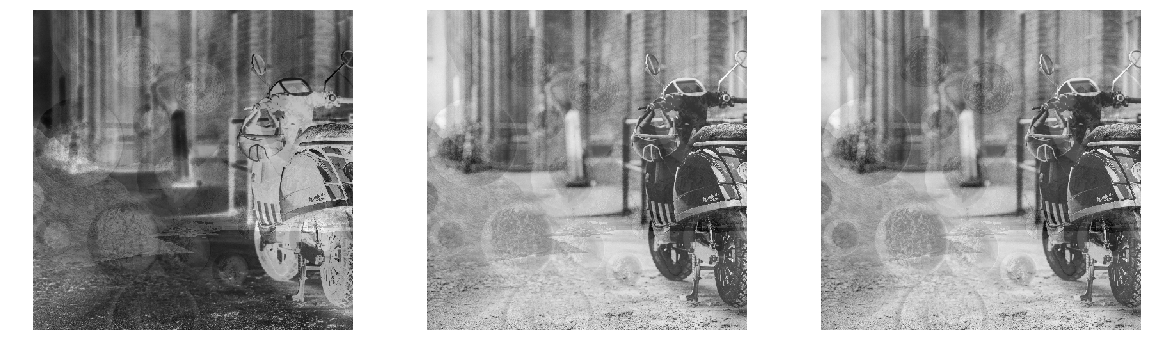

In [93]:
IM_unmixed = IM_mix @ U # np.linalg.pinv(A) # U
IM_unmixed = IM_unmixed.T

plt.rcParams["figure.figsize"] = (20,20)
for i in range(n):
    plt.subplot(3,3,i+1)
    IM_i = IM_unmixed[i] #* -1 if IM_unmixed[i].mean() < 1 else IM_unmixed[i]
    plt.imshow(IM_i.reshape(s,s), cmap="gray")
    plt.axis("off")

In [8]:
from fasterica import *
torch.manual_seed(123)


vals = []
for i in range(2):
    model = FasterICA(3, loss=ParametricLoss(3,15), optimistic_whitening_rate=1.0, whitening_strategy="batch")
    res3 = model.fit(IM_mix.astype(np.float32), X_val=IM_mix.astype(np.float32)[:500],lr=1e-1, epochs=300, bs=len(IM_mix), logging=1)
    U = model.unmixing_matrix

    U = unique_form(U)
    A_est = np.linalg.pinv(U)
    A_est = unique_form(A_est)
    A_est = (A_est / A_est.std()) * A.std()
    IM_unmixed = IM_mix @ U

    frob_norm_fast_ica = np.linalg.norm(A - A_est)
    mse = np.abs(((IMs.T/np.linalg.norm(IMs.T,axis=0)).T @ (IM_unmixed/np.linalg.norm(IM_unmixed,axis=0)))).max(1).mean()
    neg = mutual_information_approx(IM_mix @ U, expn)
    R = (U @ A)**2
    amari = ((R/R.max(0, keepdims=True)).sum(0)-1).sum() + ((R/R.max(1, keepdims=True)).sum(1)-1).sum()
    print("Frobenius", frob_norm_fast_ica, "MaxCorrelation", mse, "Negentr",  neg, "Amari", amari)
    vals.append((frob_norm_fast_ica, mse, neg, amari))
mean, std = np.round(np.asarray(vals).mean(0),4), np.round(np.asarray(vals).std(0),4)
f"BatchICA (parametric,offline, lr=1) & ${mean[2]:0.2e}\pm{std[2]:0.2e}$ & ${mean[1]:0.2e}\pm{std[1]:0.2e}$ & ${mean[0]:0.2e}\pm{std[0]:0.2e}$ & ${mean[3]:0.2e}\pm{std[3]:0.2e}$ \\"

  0%|          | 0/1 [00:00<?, ?it/s]
Ep.  0 - -14.1546 - validation (loss/white/kurt/mi/logp): -34.1345 / 0.35 / -0.42 / -274.2398 / 34.1345 (eval took: 0.0s)
Ep.  1 - -26.1942 - validation (loss/white/kurt/mi/logp): -55.8048 / 0.35 / -0.33 / -694.4545 / 55.8048 (eval took: 0.0s)
Ep.  2 - -42.2075 - validation (loss/white/kurt/mi/logp): -91.0187 / 0.35 / -0.19 / -1769.3044 / 91.0187 (eval took: 0.0s)
Ep.  3 - -69.0873 - validation (loss/white/kurt/mi/logp): -149.9686 / 0.35 / -0.10 / -4537.7173 / 149.9686 (eval took: 0.0s)
Ep.  4 - -114.7988 - validation (loss/white/kurt/mi/logp): -252.9928 / 0.35 / -0.13 / -12628.2422 / 252.9928 (eval took: 0.0s)
Ep.  5 - -194.5064 - validation (loss/white/kurt/mi/logp): -441.1889 / 0.35 / -0.20 / -38476.3750 / 441.1890 (eval took: 0.0s)
Ep.  6 - -338.9507 - validation (loss/white/kurt/mi/logp): -798.6043 / 0.35 / -0.32 / -125318.1094 / 798.6044 (eval took: 0.0s)
Ep.  7 - -615.0370 - validation (loss/white/kurt/mi/logp): -1526.1110 / 0.35 / -0.46 / -

Ep. 65 - -372.6704 - validation (loss/white/kurt/mi/logp): -176.6016 / 0.35 / -0.37 / -313579.4688 / 176.6017 (eval took: 0.0s)
Ep. 66 - -373.0009 - validation (loss/white/kurt/mi/logp): -176.9328 / 0.35 / -0.37 / -313872.3750 / 176.9329 (eval took: 0.0s)
Ep. 67 - -373.3667 - validation (loss/white/kurt/mi/logp): -177.2740 / 0.35 / -0.37 / -314215.3125 / 177.2740 (eval took: 0.0s)
Ep. 68 - -373.7649 - validation (loss/white/kurt/mi/logp): -177.6245 / 0.35 / -0.37 / -314604.5000 / 177.6245 (eval took: 0.0s)
Ep. 69 - -374.1932 - validation (loss/white/kurt/mi/logp): -177.9840 / 0.35 / -0.37 / -315035.9375 / 177.9840 (eval took: 0.0s)
Ep. 70 - -374.6494 - validation (loss/white/kurt/mi/logp): -178.3519 / 0.35 / -0.36 / -315506.6875 / 178.3519 (eval took: 0.0s)
Ep. 71 - -375.1313 - validation (loss/white/kurt/mi/logp): -178.7280 / 0.35 / -0.36 / -316014.0312 / 178.7280 (eval took: 0.0s)
Ep. 72 - -375.6373 - validation (loss/white/kurt/mi/logp): -179.1120 / 0.35 / -0.36 / -316554.9688 / 179

Ep.133 - -429.5865 - validation (loss/white/kurt/mi/logp): -214.2879 / 0.35 / -0.39 / -379335.5625 / 214.2880 (eval took: 0.0s)
Ep.134 - -430.7667 - validation (loss/white/kurt/mi/logp): -215.0645 / 0.35 / -0.39 / -380720.8125 / 215.0645 (eval took: 0.0s)
Ep.135 - -431.9566 - validation (loss/white/kurt/mi/logp): -215.8483 / 0.35 / -0.39 / -382117.8438 / 215.8483 (eval took: 0.0s)
Ep.136 - -433.1566 - validation (loss/white/kurt/mi/logp): -216.6395 / 0.35 / -0.39 / -383526.7500 / 216.6395 (eval took: 0.0s)
Ep.137 - -434.3666 - validation (loss/white/kurt/mi/logp): -217.4381 / 0.35 / -0.39 / -384947.7500 / 217.4381 (eval took: 0.0s)
Ep.138 - -435.5866 - validation (loss/white/kurt/mi/logp): -218.2442 / 0.35 / -0.39 / -386381.0000 / 218.2442 (eval took: 0.0s)
Ep.139 - -436.8168 - validation (loss/white/kurt/mi/logp): -219.0579 / 0.35 / -0.39 / -387826.5000 / 219.0580 (eval took: 0.0s)
Ep.140 - -438.0572 - validation (loss/white/kurt/mi/logp): -219.8792 / 0.35 / -0.39 / -389284.2812 / 219

RuntimeError: CUDA out of memory. Tried to allocate 46.00 MiB (GPU 0; 10.91 GiB total capacity; 7.82 GiB already allocated; 19.94 MiB free; 8.07 GiB reserved in total by PyTorch)

## CIFAR10

In [15]:
X_subset = X[:10]

U_true = np.random.normal(0, 0.1, (10, 10)) # UNMIXING MATRIX
A_true = np.linalg.inv(U_true)              # MIXING MATRIX  
A_true = unique_form(A_true)
M = (X_subset.T @ A_true).T
M.shape

(10, 3072)

(-0.5, 31.5, 31.5, -0.5)

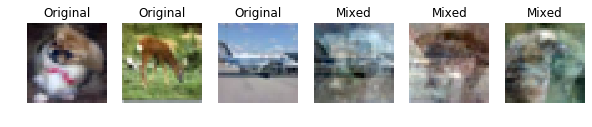

In [16]:
plt.rcParams["figure.figsize"] = (10,7)

plt.subplot(1,6,1)
plt.title("Original")
plt.imshow(rescale_im(X_subset[2].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(1,6,2)
plt.title("Original")
plt.imshow(rescale_im(X_subset[5].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(1,6,3)
plt.title("Original")
plt.imshow(rescale_im(X_subset[4].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(1,6,4)
plt.title("Mixed")
plt.imshow(rescale_im(M[4].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(1,6,5)
plt.title("Mixed")
plt.imshow(rescale_im(M[5].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(1,6,6)
plt.title("Mixed")
plt.imshow(rescale_im(M[7].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

In [17]:
M = M.T
M.shape, M.mean(0)

((3072, 10),
 array([-1.46678425e-08,  2.07337739e-08, -8.00587886e-09, -1.54713690e-08,
         1.33263791e-08, -4.82017765e-10,  4.22982396e-09,  1.17049004e-08,
         1.65989611e-08, -1.74905483e-08]))

In [18]:
_, W_white, _ = fit_pca(M, 10, True)
M_white = M @ W_white
M_white.shape

(3072, 10)

In [19]:
M_white.mean(0), M_white.std(0)

(array([-5.44157625e-08,  5.62489828e-08,  1.37921002e-07, -4.13824933e-08,
        -6.33198231e-08, -1.42857485e-07, -2.54517882e-07, -7.04494591e-08,
         2.02265121e-07,  1.72646639e-07]),
 array([0.99983723, 0.99983723, 0.99983723, 0.99983723, 0.99983723,
        0.99983723, 0.99983723, 0.99983723, 0.99983723, 0.99983723]))

Frobenius 49.55355024249959


FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


Frobenius 44.95854896289377
Frobenius 43.786646989106195
Frobenius 52.47407156058182
Frobenius 35.321388093419685
Frobenius 46.93821555635478
Frobenius 50.74401018201721
Frobenius 41.42383690644331
Frobenius 49.13524334990703
Frobenius 46.79103885277919


(46.11265506960025, 4.787623182134951)

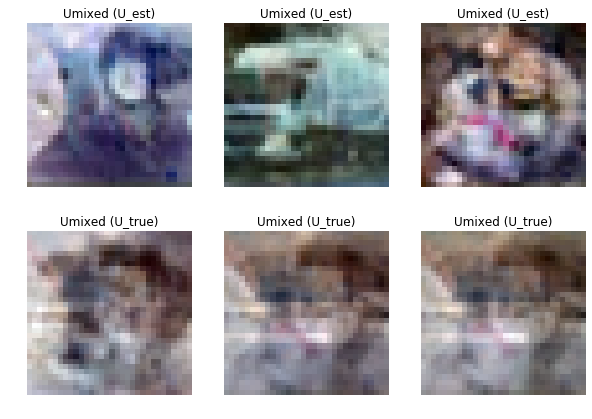

In [24]:
ica = FastICA(whiten=False, max_iter=10000).fit(M_white)
W = ica.components_.T
U_est = W_white @ W
A_est = np.linalg.pinv(U_est)

S = (M @ U_est).T

plt.subplot(2,3,1)
plt.title("Umixed (U_est)")
plt.imshow(rescale_im(S[4].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,2)
plt.title("Umixed (U_est)")
plt.imshow(rescale_im(S[5].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,3)
plt.title("Umixed (U_est)")
plt.imshow(rescale_im(S[7].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

S = (M @ U_true).T

plt.subplot(2,3,4)
plt.title("Umixed (U_true)")
plt.imshow(rescale_im(S[4].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,5)
plt.title("Umixed (U_true)")
plt.imshow(rescale_im(S[5].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,6)
plt.title("Umixed (U_true)")
plt.imshow(rescale_im(S[7].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

norms = []
for i in range(10):
    ica = FastICA(whiten=False, max_iter=50000).fit(M_white)
    W = ica.components_.T
    U_est = W_white @ W
    A_est = np.linalg.pinv(U_est)
    A_est = unique_form(A_est)
    
    frob_norm_fast_ica = np.linalg.norm(A_est / A_est.std() * A_true.std() - A_true)
    print("Frobenius", frob_norm_fast_ica)
    norms.append(frob_norm_fast_ica)
np.asarray(norms).mean(),np.asarray(norms).std()

In [11]:
from novelty_detection.helpers import normalize_components

In [12]:
normalize_components

<function novelty_detection.metrics.linear_model.normalize_components(W, X, orthogonalize=False)>

Begin training: 100 epochs.
Epoch: 50 - loss(trn):3.94060, kurt(trn):1.11, cov(trn):0.00, skew(trn):0.28, std(trn):1.00, lr=0.00100. [0s] @20970 samples/s 
Epoch: 100 - loss(trn):3.93922, kurt(trn):1.14, cov(trn):0.00, skew(trn):0.28, std(trn):1.00, lr=0.00100. [0s] @21432 samples/s 
Begin training: 100 epochs.
Epoch: 50 - loss(trn):4.16012, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1166476 samples/s 
Epoch: 100 - loss(trn):4.15600, kurt(trn):0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1170928 samples/s 
Begin training: 100 epochs.


Frobenius 41.96207469014668


Epoch: 50 - loss(trn):4.16012, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1176918 samples/s 
Epoch: 100 - loss(trn):4.15600, kurt(trn):0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1141468 samples/s 
Begin training: 100 epochs.


Frobenius 41.96207464958647


Epoch: 50 - loss(trn):4.16012, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1133236 samples/s 
Epoch: 100 - loss(trn):4.15600, kurt(trn):0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1113455 samples/s 
Begin training: 100 epochs.


Frobenius 41.96207462942296


Epoch: 50 - loss(trn):4.16012, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1049259 samples/s 
Epoch: 100 - loss(trn):4.15600, kurt(trn):0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1101650 samples/s 
Begin training: 100 epochs.


Frobenius 41.9620746906216


Epoch: 50 - loss(trn):4.16012, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1175737 samples/s 
Epoch: 100 - loss(trn):4.15600, kurt(trn):0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1134933 samples/s 
Begin training: 100 epochs.


Frobenius 41.96207465120691


Epoch: 50 - loss(trn):4.16012, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1124729 samples/s 
Epoch: 100 - loss(trn):4.15600, kurt(trn):0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1185581 samples/s 
Begin training: 100 epochs.


Frobenius 41.96207467290041


Epoch: 50 - loss(trn):4.16012, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1145528 samples/s 
Epoch: 100 - loss(trn):4.15600, kurt(trn):0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1149103 samples/s 
Begin training: 100 epochs.


Frobenius 41.9620746181205


Epoch: 50 - loss(trn):4.16012, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1175308 samples/s 
Epoch: 100 - loss(trn):4.15600, kurt(trn):0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1176918 samples/s 
Begin training: 100 epochs.


Frobenius 41.96207465319316


Epoch: 50 - loss(trn):4.16012, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1166265 samples/s 
Epoch: 100 - loss(trn):4.15600, kurt(trn):0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1168804 samples/s 
Begin training: 100 epochs.


Frobenius 41.96207458824592


Epoch: 50 - loss(trn):4.16012, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1182535 samples/s 
Epoch: 100 - loss(trn):4.15600, kurt(trn):0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @1196036 samples/s 


Frobenius 41.96207467406044


(41.962074651750505, 3.098333130687888e-08)

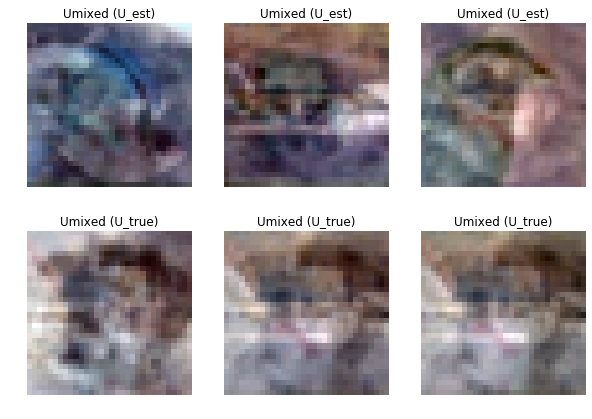

In [21]:
model = FasterICA(10, 10, whitening_algo="None", loss="logcosh")
model.fit(M_white.astype(np.float32), lr=1e-3, epochs=100, log_interval=50, bs=50, beta_whitening=0., optimizer="adam")
W = model.get_I(True)
U_est = W_white @ W
A_est = np.linalg.pinv(U_est)

S = (M @ U_est).T

plt.subplot(2,3,1)
plt.title("Umixed (U_est)")
plt.imshow(rescale_im(S[4].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,2)
plt.title("Umixed (U_est)")
plt.imshow(rescale_im(S[5].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,3)
plt.title("Umixed (U_est)")
plt.imshow(rescale_im(S[7].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

S = (M @ U_true).T

plt.subplot(2,3,4)
plt.title("Umixed (U_true)")
plt.imshow(rescale_im(S[4].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,5)
plt.title("Umixed (U_true)")
plt.imshow(rescale_im(S[5].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,6)
plt.title("Umixed (U_true)")
plt.imshow(rescale_im(S[7].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

norms = []
for i in range(10):
    model = FasterICA(10, 10, whitening_algo="None", loss="logcosh")
    model.fit(M_white.astype(np.float32), lr=1e-4, epochs=100, log_interval=50, bs=len(M_white), beta_whitening=0., optimizer="adam")
    W = model.get_I(True)
    U_est = W_white @ W
    A_est = np.linalg.pinv(U_est)
    A_est = unique_form(A_est)

    frob_norm_fast_ica = np.linalg.norm(A_est / A_est.std() * A_true.std() - A_true)
    print("Frobenius", frob_norm_fast_ica)
    norms.append(frob_norm_fast_ica)
np.asarray(norms).mean(),np.asarray(norms).std()

Begin training: 100 epochs.
Epoch: 50 - loss(trn):3.93917, kurt(trn):1.16, cov(trn):0.00, skew(trn):0.33, std(trn):1.00, lr=0.00100. [0s] @20546 samples/s 
Epoch: 100 - loss(trn):3.93926, kurt(trn):1.18, cov(trn):0.00, skew(trn):0.34, std(trn):1.00, lr=0.00100. [0s] @20795 samples/s 
Begin training: 100 epochs.
Epoch: 50 - loss(trn):4.16188, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @66520 samples/s 
Epoch: 100 - loss(trn):4.15952, kurt(trn):-0.00, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @65812 samples/s 
Begin training: 100 epochs.


Frobenius 41.90581889428796


Epoch: 50 - loss(trn):4.16188, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @64826 samples/s 
Epoch: 100 - loss(trn):4.15952, kurt(trn):-0.00, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @65129 samples/s 
Begin training: 100 epochs.


Frobenius 41.90581887115932


Epoch: 50 - loss(trn):4.16188, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @65045 samples/s 
Epoch: 100 - loss(trn):4.15952, kurt(trn):-0.00, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @66108 samples/s 
Begin training: 100 epochs.


Frobenius 41.90581888734869


Epoch: 50 - loss(trn):4.16188, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @66461 samples/s 
Epoch: 100 - loss(trn):4.15952, kurt(trn):-0.00, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @66218 samples/s 
Begin training: 100 epochs.


Frobenius 41.905818863196124


Epoch: 50 - loss(trn):4.16188, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @65548 samples/s 
Epoch: 100 - loss(trn):4.15952, kurt(trn):-0.00, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @64955 samples/s 
Begin training: 100 epochs.


Frobenius 41.905818886860644


Epoch: 50 - loss(trn):4.16188, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @66252 samples/s 
Epoch: 100 - loss(trn):4.15952, kurt(trn):-0.00, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @65738 samples/s 
Begin training: 100 epochs.


Frobenius 41.905818904453305


Epoch: 50 - loss(trn):4.16188, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @65783 samples/s 
Epoch: 100 - loss(trn):4.15952, kurt(trn):-0.00, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @66240 samples/s 
Begin training: 100 epochs.


Frobenius 41.9058188650372


Epoch: 50 - loss(trn):4.16188, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @65997 samples/s 
Epoch: 100 - loss(trn):4.15952, kurt(trn):-0.00, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @66174 samples/s 
Begin training: 100 epochs.


Frobenius 41.905818882355106


Epoch: 50 - loss(trn):4.16188, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @65338 samples/s 
Epoch: 100 - loss(trn):4.15952, kurt(trn):-0.00, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @65932 samples/s 
Begin training: 100 epochs.


Frobenius 41.905818899835275


Epoch: 50 - loss(trn):4.16188, kurt(trn):-0.01, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @65697 samples/s 
Epoch: 100 - loss(trn):4.15952, kurt(trn):-0.00, cov(trn):0.00, skew(trn):0.12, std(trn):1.00, lr=0.00010. [0s] @65687 samples/s 


Frobenius 41.905818890276244


(41.90581888448098, 1.3384275825621752e-08)

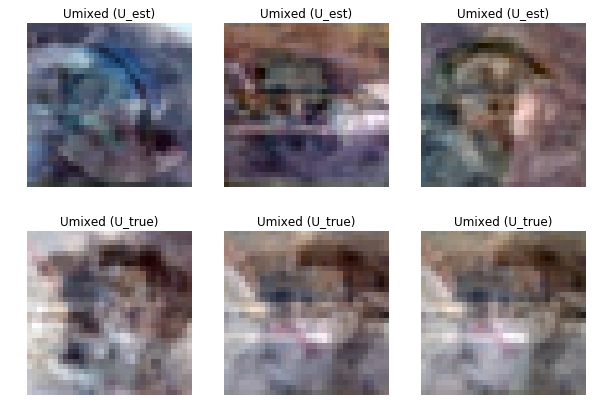

In [23]:
model = FasterICA(10, 10, whitening_algo="None", loss="logcosh")
model.fit(M_white.astype(np.float32), lr=1e-3, epochs=100, log_interval=50, bs=50, beta_whitening=0., optimizer="adam")
W = model.get_I(True)
U_est = W_white @ W
A_est = np.linalg.pinv(U_est)

S = (M @ U_est).T

plt.subplot(2,3,1)
plt.title("Umixed (U_est)")
plt.imshow(rescale_im(S[4].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,2)
plt.title("Umixed (U_est)")
plt.imshow(rescale_im(S[5].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,3)
plt.title("Umixed (U_est)")
plt.imshow(rescale_im(S[7].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

S = (M @ U_true).T

plt.subplot(2,3,4)
plt.title("Umixed (U_true)")
plt.imshow(rescale_im(S[4].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,5)
plt.title("Umixed (U_true)")
plt.imshow(rescale_im(S[5].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

plt.subplot(2,3,6)
plt.title("Umixed (U_true)")
plt.imshow(rescale_im(S[7].reshape(3, 32, 32).transpose(1,2,0)))
plt.axis("off")

norms = []
for i in range(10):
    model = FasterICA(10, 10, whitening_algo="None", loss="logcosh")
    model.fit(M_white.astype(np.float32), lr=1e-4, epochs=100, log_interval=50, bs=len(M_white), beta_whitening=0., optimizer="lbgfs")
    W = model.get_I(True)
    U_est = W_white @ W
    A_est = np.linalg.pinv(U_est)
    A_est = unique_form(A_est)

    frob_norm_fast_ica = np.linalg.norm(A_est / A_est.std() * A_true.std() - A_true)
    print("Frobenius", frob_norm_fast_ica)
    norms.append(frob_norm_fast_ica)
np.asarray(norms).mean(),np.asarray(norms).std()

# Whitening

In [45]:
plt.rcParams["figure.figsize"] = (5,5)
n_components = X.shape[1]

In [43]:
X_f_white = f_whitening(X, (3, 32, 32))
X_f_white_valid = f_whitening(X_valid, (3, 32, 32))

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/preprocessing/data.py:197: User

In [46]:
W_pca = fit_pca(X, n_components=n_components)

/home/matthias/Desktop/workspace/novelty-detection/novelty_detection/metrics/linear_model.py:43: UserWarning: X is not centered (mean was 410.0276794433594)
  warnings.warn(f"X is not centered (mean was {np.abs(X.mean(0)).sum()})")


In [ ]:
W_zca = fit_zca(X - X.mean(0), n_components=X.shape[1])[1]
W_zca = W_zca / (X @ W_zca).std(0)

In [ ]:
t0 = time.time()
W_ica = fit_ica(X - X.mean(0), n_components=n_components, max_iter=1000)[1]
time.time() - t0

In [ ]:
t0 = time.time()
W_ica_centered = fit_ica(X - X.mean(0), n_components=100, max_iter=1000)[1]
time.time() - t0

In [ ]:
model = HebbianLinearLayer(X.shape[1], 100)
model.fit(X / X.std(), epochs=500, bs=100, lr=1e-4, log_interval=100)
W = model.get_w(True)
W_gha = W / X.std().reshape(-1, 1)
W_gha = W_gha / (X @ W_gha).std(0)

In [ ]:
model = BatchIncrementalPCA(X.shape[1], 100).fit(X, epochs=1, log_interval=1, bs=100)
W_batch_pca = model.get_w(True, True)

In [ ]:
model = IncrementalPCA(X.shape[1], n_components).fit(X, epochs=3, log_interval=1, bs=10)
W_inc_pca = model.get_w(True, True)

In [15]:
model = HebbianAutoencoder(X.shape[1], n_components)
model.fit(X / X.std(), epochs=10, lr=1e-4, log_interval=1, bs=20)
model.fit(X / X.std(), epochs=20, lr=1e-5, log_interval=1, bs=20)
W_hebb = model.get_sphering(X / X.std(), True)/ X.std().reshape(-1, 1)
W_hebb = W_hebb / (X @ W_hebb).std(0)

X is not centered. Subtracting mean 410.0273742675781.
Scheduler: 4 learning rates decreased by factor 0.1 after 500 epochs, early stopping after 45, min mode.
Begin training: 10 epochs.
Epoch: 1 - loss(trn):15983.36372, lr=0.00010. [70s] @705 samples/s 
Epoch: 2 - loss(trn):11602.72869, lr=0.00010. [71s] @700 samples/s 
Epoch: 3 - loss(trn):9763.59763, lr=0.00010. [71s] @702 samples/s 
Epoch: 4 - loss(trn):9249.86544, lr=0.00010. [71s] @701 samples/s 
Epoch: 5 - loss(trn):8997.00676, lr=0.00010. [71s] @700 samples/s 
Epoch: 6 - loss(trn):8804.82257, lr=0.00010. [71s] @697 samples/s 
Epoch: 7 - loss(trn):8894.14904, lr=0.00010. [71s] @699 samples/s 
Epoch: 8 - loss(trn):9003.38944, lr=0.00010. [71s] @701 samples/s 
Epoch: 9 - loss(trn):8868.14772, lr=0.00010. [71s] @696 samples/s 
Epoch: 10 - loss(trn):8869.13310, lr=0.00010. [71s] @699 samples/s 
Scheduler: 4 learning rates decreased by factor 0.1 after 500 epochs, early stopping after 45, min mode.
Begin training: 20 epochs.
Epoch: 1

In [ ]:
# scale and rescale with std() to mitigate numerical issues
model = GMM(X.shape[1], n_components, 1)
model.fit(X / X.std(), epochs=100, log_interval=5, bs=100, reset=False, lr=1e-4)
W_ppca = model.W[0].detach().cpu().numpy() / X.std().reshape(-1, 1) 
W_ppca = W_ppca / (X @ W_ppca).std(0)

In [ ]:
model = FasterICA(X.shape[1], n_components, whitening_algo="incremental", loss="logcosh")
model.fit(X, epochs= 3, log_interval=1, bs=10, lambda_ica=0.)
model.fit(X, epochs=50, log_interval=10, bs=50, beta_whitening=0., optimizer="adam")
W_fica = model.get_I(True)

In [24]:
plt.rcParams["figure.figsize"] = (10,10)

plt.subplot(3,4,1)
plt.title("W_pca")
plt.imshow(np.cov((X @ W_pca).T))
plt.axis("off")

plt.subplot(3,4,2)
plt.title("W_zca")
plt.imshow(np.cov((X @ W_zca).T))
plt.axis("off")

plt.subplot(3,4,3)
plt.title("W_ica")
plt.imshow(np.cov((X @ W_ica).T))
plt.axis("off")

plt.subplot(3,4,4)
plt.title("W_inc_pca")
plt.imshow(np.cov((X @ W_inc_pca).T))
plt.axis("off")

plt.subplot(3,4,5)
plt.title("W_ppca")
plt.imshow(np.cov((X @ W_ppca).T))
plt.axis("off")

plt.subplot(3,4,6)
plt.title("W_hebb")
plt.imshow(np.cov((X @ W_hebb).T))
plt.axis("off")

plt.subplot(3,4,7)
plt.title("W_fica")
plt.imshow(np.cov((X @ W_fica).T))
plt.axis("off")

plt.subplot(3,4,8)
plt.title("W_gha")
plt.imshow(np.cov((X @ W_gha).T))
plt.axis("off")

plt.subplot(3,4,9)
plt.title("f_white")
plt.imshow(np.cov(X_f_white.T))
plt.axis("off")

plt.subplot(3,4,10)
plt.title("W_batch_pca")
plt.imshow(np.cov((X @ W_batch_pca).T))
plt.axis("off")

(-0.5, 99.5, 99.5, -0.5)

##  Statistics

In [25]:
from scipy.stats import kurtosis
k = n_components

def PHI(X, S):
    return ( (S - S.mean(0)).T @ (X - X.mean(0) )[:,:k] ) / (X.shape[0] - 1)

def trPHI(X, S):
    return np.trace(PHI(X, S)) / X.shape[1]

def maxDiagPHI(X, S):
    phi = PHI(X, S)
    return np.diag(phi @ phi.T).max()

In [28]:
{
    "kurtosis" : {
            "pca" :  kurtosis(X @ W_pca,  0).mean(),
            "zca" :  kurtosis(X @ W_zca,  0).mean(),
            "ica" :  kurtosis(X @ W_ica,  0).mean(),
            "icac" : kurtosis(X @ W_ica_centered,  0).mean(),
            "fica" : kurtosis(X @ W_fica, 0).mean(),
            "ppca" : kurtosis(X @ W_ppca, 0).mean(),
            "bpca" : kurtosis(X @ W_batch_pca, 0).mean(),
            "ipca" : kurtosis(X @ W_inc_pca, 0).mean(),
            "gha" :  kurtosis(X @ W_gha, 0).mean(),
            "hebb" : kurtosis(X @ W_hebb, 0).mean(),
            "1/f" :  kurtosis(X_f_white, 0).mean(),
        },
    "variance" : {
            "pca" :  (X @ W_pca).var(0).mean(),
            "zca" :  (X @ W_zca).var(0).mean(),
            "ica" :  (X @ W_ica).var(0).mean(),
            "icac" : (X @ W_ica_centered).var(0).mean(),
            "fica" : (X @ W_fica).var(0).mean(),
            "ppca" : (X @ W_ppca).var(0).mean(),
            "bpca" : (X @ W_batch_pca).var(0).mean(),
            "ipca" : (X @ W_inc_pca).var(0).mean(),
            "gha" :  (X @ W_gha).var(0).mean(),
            "hebb" : (X @ W_hebb).var(0).mean(),
            "1/f" :  (X_f_white).var(0).mean(),
        },
    "PHI" : {
            "pca" :   trPHI(X, X @ W_pca),
            "zca" :   trPHI(X, X @ W_zca),
            "ica" :   trPHI(X, X @ W_ica),
            "icac" :  trPHI(X, X @ W_ica_centered),
            "fica" :  trPHI(X, X @ W_fica),
            "ppca" :  trPHI(X, X @ W_ppca),        
            "bpca" :  trPHI(X, X @ W_batch_pca),
            "ipca" :  trPHI(X, X @ W_inc_pca),
            "gha" :   trPHI(X, X @ W_gha),
            "hebb" :  trPHI(X, X @ W_hebb),
            "1/f" :   trPHI(X, X_f_white),
        },
    "max(diag(PHI))" : {
            "pca" :   maxDiagPHI(X, X @ W_pca),
            "zca" :   maxDiagPHI(X, X @ W_zca),
            "ica" :   maxDiagPHI(X, X @ W_ica),
            "icac" :  maxDiagPHI(X, X @ W_ica_centered),        
            "fica" :  maxDiagPHI(X, X @ W_fica),
            "ppca" :  maxDiagPHI(X, X @ W_ppca),        
            "bpca" :  maxDiagPHI(X, X @ W_batch_pca),
            "ipca" :  maxDiagPHI(X, X @ W_inc_pca),
            "gha" :   maxDiagPHI(X, X @ W_gha),            
            "hebb" :  maxDiagPHI(X, X @ W_hebb),
            "1/f" :   maxDiagPHI(X, X_f_white),
        },
    "Frobenius" : {
            "pca" :   np.linalg.norm(np.cov((X @ W_pca).T) - np.eye(W_pca.shape[1])) / n_components ,
            "zca" :   np.linalg.norm(np.cov((X @ W_zca).T) - np.eye(X.shape[1])) / X.shape[1],
            "ica" :   np.linalg.norm(np.cov((X @ W_ica).T) - np.eye(W_pca.shape[1])) / n_components,
            "icac" :  np.linalg.norm(np.cov((X @ W_ica_centered).T) - np.eye(W_pca.shape[1])) / n_components,        
            "fica" :  np.linalg.norm(np.cov((X @ W_fica).T) - np.eye(W_pca.shape[1])) / n_components,
            "ppca" :  np.linalg.norm(np.cov((X @ W_ppca).T) - np.eye(W_pca.shape[1])) / n_components, 
            "bpca" :  np.linalg.norm(np.cov((X @ W_batch_pca).T) - np.eye(W_pca.shape[1])) / n_components,       
            "ipca" :  np.linalg.norm(np.cov((X @ W_inc_pca).T) - np.eye(W_pca.shape[1])) / n_components,       
            "gha" :   np.linalg.norm(np.cov((X @ W_gha).T)  - np.eye(W_pca.shape[1])) / n_components,            
            "hebb" :  np.linalg.norm(np.cov((X @ W_hebb).T) - np.eye(W_pca.shape[1])) / n_components,
            "1/f" :   np.linalg.norm(np.cov(X_f_white.T)    - np.eye(X_f_white.shape[1])) / X.shape[1],
        }
} 

{'kurtosis': {'pca': 0.6375961,
  'zca': 13.241733,
  'ica': 2.9362206882071975,
  'icac': 3.0042710074291086,
  'fica': 2.9245281,
  'ppca': 0.25498977,
  'bpca': -0.23430942,
  'ipca': 0.59041846,
  'gha': 0.6203103,
  'hebb': 0.032941148,
  '1/f': 0.05885041527000102},
 'variance': {'pca': 0.9999743,
  'zca': 1.0000023,
  'ica': 0.9999799642789533,
  'icac': 0.9999799742267892,
  'fica': 1.0084535,
  'ppca': 0.9999992,
  'bpca': 0.937067,
  'ipca': 0.99834245,
  'gha': 0.9999998,
  'hebb': 1.0,
  '1/f': 0.9918083892096066},
 'PHI': {'pca': -0.00041355728171765804,
  'zca': 0.010199510181943575,
  'ica': 8.482155435876166e-05,
  'icac': 0.0003560440822569778,
  'fica': -9.108097098457317e-05,
  'ppca': 0.000628397217951715,
  'bpca': 0.004082705204685529,
  'ipca': 3.933904372388497e-05,
  'gha': -0.0002458750580747922,
  'hebb': 0.0004501005169004202,
  '1/f': 0.00405210358691633},
 'max(diag(PHI))': {'pca': 29.509977,
  'zca': 0.5846702,
  'ica': 12.436103741172776,
  'icac': 12.51

In [27]:
X_ = X
X = X_valid
X_f_white_ = X_f_white
X_f_white = X_f_white_valid

validation = {
    "kurtosis" : {
            "pca" :  kurtosis(X @ W_pca,  0).mean(),
            "zca" :  kurtosis(X @ W_zca,  0).mean(),
            "ica" :  kurtosis(X @ W_ica,  0).mean(),
            "icac" : kurtosis(X @ W_ica_centered,  0).mean(),
            "fica" : kurtosis(X @ W_fica, 0).mean(),
            "ppca" : kurtosis(X @ W_ppca, 0).mean(),
            "bpca" : kurtosis(X @ W_batch_pca, 0).mean(),
            "ipca" : kurtosis(X @ W_inc_pca, 0).mean(),
            "gha" :  kurtosis(X @ W_gha, 0).mean(),
            "hebb" : kurtosis(X @ W_hebb, 0).mean(),
            "1/f" :  kurtosis(X_f_white, 0).mean(),
        },
    "variance" : {
            "pca" :  (X @ W_pca).var(0).mean(),
            "zca" :  (X @ W_zca).var(0).mean(),
            "ica" :  (X @ W_ica).var(0).mean(),
            "icac" : (X @ W_ica_centered).var(0).mean(),
            "fica" : (X @ W_fica).var(0).mean(),
            "ppca" : (X @ W_ppca).var(0).mean(),
            "bpca" : (X @ W_batch_pca).var(0).mean(),
            "ipca" : (X @ W_inc_pca).var(0).mean(),
            "gha" :  (X @ W_gha).var(0).mean(),
            "hebb" : (X @ W_hebb).var(0).mean(),
            "1/f" :  (X_f_white).var(0).mean(),
        },
    "PHI" : {
            "pca" :   trPHI(X, X @ W_pca),
            "zca" :   trPHI(X, X @ W_zca),
            "ica" :   trPHI(X, X @ W_ica),
            "icac" :  trPHI(X, X @ W_ica_centered),
            "fica" :  trPHI(X, X @ W_fica),
            "ppca" :  trPHI(X, X @ W_ppca),        
            "bpca" :  trPHI(X, X @ W_batch_pca),
            "ipca" :  trPHI(X, X @ W_inc_pca),
            "gha" :   trPHI(X, X @ W_gha),
            "hebb" :  trPHI(X, X @ W_hebb),
            "1/f" :   trPHI(X, X_f_white),
        },
    "max(diag(PHI))" : {
            "pca" :   maxDiagPHI(X, X @ W_pca),
            "zca" :   maxDiagPHI(X, X @ W_zca),
            "ica" :   maxDiagPHI(X, X @ W_ica),
            "icac" :  maxDiagPHI(X, X @ W_ica_centered),        
            "fica" :  maxDiagPHI(X, X @ W_fica),
            "ppca" :  maxDiagPHI(X, X @ W_ppca),        
            "bpca" :  maxDiagPHI(X, X @ W_batch_pca),
            "ipca" :  maxDiagPHI(X, X @ W_inc_pca),
            "gha" :   maxDiagPHI(X, X @ W_gha),            
            "hebb" :  maxDiagPHI(X, X @ W_hebb),
            "1/f" :   maxDiagPHI(X, X_f_white),
        },
    "Frobenius" : {
            "pca" :   np.linalg.norm(np.cov((X @ W_pca).T) - np.eye(W_pca.shape[1])) / n_components ,
            "zca" :   np.linalg.norm(np.cov((X @ W_zca).T) - np.eye(X.shape[1])) / X.shape[1],
            "ica" :   np.linalg.norm(np.cov((X @ W_ica).T) - np.eye(W_pca.shape[1])) / n_components,
            "icac" :  np.linalg.norm(np.cov((X @ W_ica_centered).T) - np.eye(W_pca.shape[1])) / n_components,        
            "fica" :  np.linalg.norm(np.cov((X @ W_fica).T) - np.eye(W_pca.shape[1])) / n_components,
            "ppca" :  np.linalg.norm(np.cov((X @ W_ppca).T) - np.eye(W_pca.shape[1])) / n_components, 
            "bpca" :  np.linalg.norm(np.cov((X @ W_batch_pca).T) - np.eye(W_pca.shape[1])) / n_components,       
            "ipca" :  np.linalg.norm(np.cov((X @ W_inc_pca).T) - np.eye(W_pca.shape[1])) / n_components,       
            "gha" :   np.linalg.norm(np.cov((X @ W_gha).T)  - np.eye(W_pca.shape[1])) / n_components,            
            "hebb" :  np.linalg.norm(np.cov((X @ W_hebb).T) - np.eye(W_pca.shape[1])) / n_components,
            "1/f" :   np.linalg.norm(np.cov(X_f_white.T)    - np.eye(X_f_white.shape[1])) / X.shape[1],
        }
} 
X_f_white = X_f_white_ 
X = X_
validation

{'kurtosis': {'pca': 0.6378634,
  'zca': 18.513674,
  'ica': 2.8068853749819027,
  'icac': 2.8843434606825595,
  'fica': 2.8017805,
  'ppca': 0.25315955,
  'bpca': -0.23141979,
  'ipca': 0.5961828,
  'gha': 0.6198267,
  'hebb': 0.034735363,
  '1/f': 0.06764407978027835},
 'variance': {'pca': 0.9995016,
  'zca': 1.1492298,
  'ica': 0.999502279073411,
  'icac': 0.999502288539671,
  'fica': 1.0071797,
  'ppca': 0.99818474,
  'bpca': 0.93596625,
  'ipca': 0.9978442,
  'gha': 0.9993603,
  'hebb': 1.0001413,
  '1/f': 0.9918253517714261},
 'PHI': {'pca': -0.00041690305806696415,
  'zca': 0.010394848262270292,
  'ica': 0.0001313205622212742,
  'icac': 0.00038125600604972323,
  'fica': -7.411121138526748e-05,
  'ppca': 0.0005954537773504853,
  'bpca': 0.004022450186312199,
  'ipca': -5.6847716526438795e-05,
  'gha': -0.0002782328713995715,
  'hebb': 0.0005130837283407649,
  '1/f': 0.0041063683489712234},
 'max(diag(PHI))': {'pca': 28.072752,
  'zca': 0.8118176,
  'ica': 12.016216885424152,
  'i

# Inverse Mixing Matrix (White)

$ A = (W_{ica}^T W_{white}^{-1})^T = (W_{white} W_{ica})^{-1}$

(-0.5, 329.5, 329.5, -0.5)

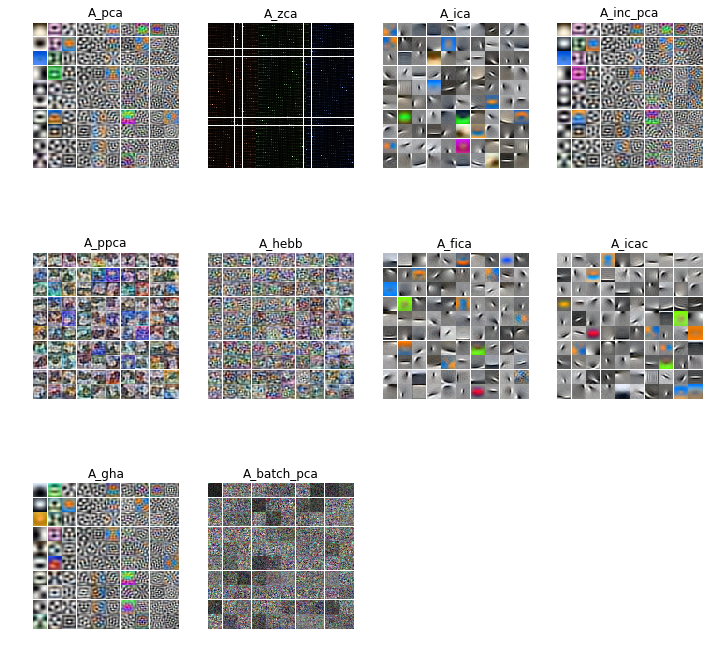

In [30]:
plt.rcParams["figure.figsize"] = (12, 12)

plt.subplot(3,4,1)
plt.title("A_pca")
show_filters_color(np.linalg.pinv(W_pca).T, C=3)
plt.axis("off")

plt.subplot(3,4,2)
plt.title("A_zca")
show_filters_color(np.linalg.pinv(W_zca).T, C=3)
plt.axis("off")

plt.subplot(3,4,3)
plt.title("A_ica")
show_filters_color(np.linalg.pinv(W_ica).T, C=3)
plt.axis("off")

plt.subplot(3,4,4)
plt.title("A_inc_pca")
show_filters_color(np.linalg.pinv(W_inc_pca).T, C=3)
plt.axis("off")

plt.subplot(3,4,5)
plt.title("A_ppca")
show_filters_color(np.linalg.pinv(W_ppca).T, C=3)
plt.axis("off")

plt.subplot(3,4,6)
plt.title("A_hebb")
show_filters_color(np.linalg.pinv(W_hebb).T, C=3)
plt.axis("off")

plt.subplot(3,4,7)
plt.title("A_fica")
show_filters_color(np.linalg.pinv(W_fica).T, C=3)
plt.axis("off")

plt.subplot(3,4,8)
plt.title("A_icac")
show_filters_color(np.linalg.pinv(W_ica_centered).T, C=3)
plt.axis("off")

plt.subplot(3,4,9)
plt.title("A_gha")
show_filters_color(np.linalg.pinv(W_gha).T, C=3)
plt.axis("off")

plt.subplot(3,4,10)
plt.title("A_batch_pca")
show_filters_color(np.linalg.pinv(W_batch_pca).T, C=3)
plt.axis("off")

# expm() vs. caley() vs. pade()

In [2]:
import timeit
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def matrix_exp(matrix, symmetric=True):
    if not symmetric:
        raise NotImplementedError('matrix exp for non-symmetric matrix is not implemented')
    e, V = torch.symeig(matrix, eigenvectors=True)
    return V.t() @ torch.diag(e).exp() @ V

def eig(A):
    e, V = torch.symeig(A, eigenvectors=True)

def expm_caley(A):
    """
    Caley-Approximation for expm(A).
    """
    I = torch.eye(A.shape[0], device=A.device, dtype=A.dtype)
    theta = A/2
    return torch.inverse(I - theta) @ (I + theta)

In [13]:
from fasterica.helpers.expm import expm_class, expm_caley
pade = expm_class.apply

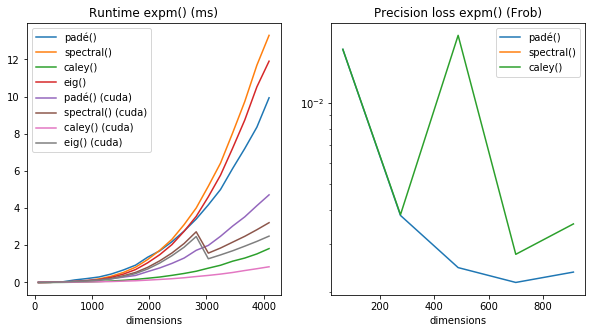

In [21]:
runtime = []
runtimec = []
precision = []
ns = []

iters = 1

for n in np.linspace(64, 4096, 20):
    n = int(n)
    ns.append(n)
    A = torch.from_numpy(np.random.normal(0, 0.1, (n,n))).double()
    runtime.append((timeit.timeit(stmt = lambda : pade(A),       number=iters)/iters,
                    timeit.timeit(stmt = lambda : matrix_exp(A), number=iters)/iters,
                    timeit.timeit(stmt = lambda : expm_caley(A), number=iters)/iters,
                    timeit.timeit(stmt = lambda : eig(A),        number=iters)/iters))
   
    runtimec.append((timeit.timeit(stmt = lambda : (torch.cuda.synchronize(), pade(A.cuda()),      torch.cuda.synchronize()),  number=iters)/iters,
                     timeit.timeit(stmt = lambda : (torch.cuda.synchronize(), matrix_exp(A.cuda()),torch.cuda.synchronize()),number=iters)/iters,
                     timeit.timeit(stmt = lambda : (torch.cuda.synchronize(), expm_caley(A.cuda()),torch.cuda.synchronize()),number=iters)/iters,
                     timeit.timeit(stmt = lambda : (torch.cuda.synchronize(), eig(A.cuda()),       torch.cuda.synchronize()), number=iters)/iters))
    
    target = matrix_exp(A).cpu().numpy()
    precision.append((np.linalg.norm(pade(A).cpu().numpy() - target) / len(A.flatten()),
                      np.linalg.norm(matrix_exp(A).cpu().numpy() - target)  / len(A.flatten()),
                      np.linalg.norm(expm_caley(A).cpu().numpy() - target) / len(A.flatten())))
    

plt.rcParams["figure.figsize"] = (10,5)

run = np.asarray(runtime)
runc = np.asarray(runtimec)
pre = np.asarray(precision)

plt.subplot(1, 2, 1)
plt.title("Runtime expm() (ms)")
plt.plot(ns, run[:, 0], label="padé()")
plt.plot(ns, run[:, 1], label="spectral()")
plt.plot(ns, run[:, 2], label="caley()")
plt.plot(ns, run[:, 3], label="eig()")
plt.plot(ns, runc[:, 0], label="padé() (cuda)")
plt.plot(ns, runc[:, 1], label="spectral() (cuda)")
plt.plot(ns, runc[:, 2], label="caley() (cuda)")
plt.plot(ns, runc[:, 3], label="eig() (cuda)")
plt.xlabel("dimensions")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Precision loss expm() (Frob)")
plt.plot(ns[:], pre[:, 0], label="padé()")
plt.plot(ns[:], pre[:, 1], label="spectral()")
plt.plot(ns[:], pre[:, 2], label="caley()")
plt.xlabel("dimensions")
plt.yscale("log")

plt.legend()

In [39]:
runtime = []
runtimec = []
precision = []
ns = []

iters = 1
A_ = torch.from_numpy(np.random.normal(0, 0.1, (2000,2000))).float()
    
for n in np.linspace(64, 2000, 50):
    
    n = int(n)
    ns.append(n)
    A = A_[:n, :n]
    
    runtime.append((timeit.timeit(stmt = lambda : pade(A),       number=iters)/iters,
                    timeit.timeit(stmt = lambda : matrix_exp(A), number=iters)/iters,
                    timeit.timeit(stmt = lambda : expm_caley(A), number=iters)/iters,
                    timeit.timeit(stmt = lambda : eig(A),        number=iters)/iters))
   
    runtimec.append((timeit.timeit(stmt = lambda : (torch.cuda.synchronize(), pade(A.cuda()),      torch.cuda.synchronize()),  number=iters)/iters,
                     timeit.timeit(stmt = lambda : (torch.cuda.synchronize(), matrix_exp(A.cuda()),torch.cuda.synchronize()),number=iters)/iters,
                     timeit.timeit(stmt = lambda : (torch.cuda.synchronize(), expm_caley(A.cuda()),torch.cuda.synchronize()),number=iters)/iters,
                     timeit.timeit(stmt = lambda : (torch.cuda.synchronize(), eig(A.cuda()),       torch.cuda.synchronize()), number=iters)/iters))
    
    target = matrix_exp(A).cpu().numpy()
    precision.append((np.linalg.norm(pade(A).cpu().numpy() - target) / len(A.flatten()),
                      np.linalg.norm(matrix_exp(A).cpu().numpy() - target)  / len(A.flatten()),
                      np.linalg.norm(expm_caley(A).cpu().numpy() - target) / len(A.flatten())))
    

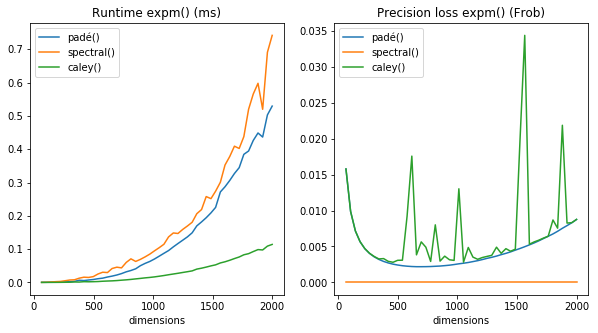

In [44]:
plt.rcParams["figure.figsize"] = (10,5)

run = np.asarray(runtime)
runc = np.asarray(runtimec)
pre = np.asarray(precision)

plt.subplot(1, 2, 1)
plt.title("Runtime expm() (ms)")
plt.plot(ns, run[:, 0], label="padé()")
plt.plot(ns, run[:, 1], label="spectral()")
plt.plot(ns, run[:, 2], label="caley()")
#plt.plot(ns, run[:, 3], label="eig()")
#plt.plot(ns, runc[:, 0], label="padé() (cuda)")
#plt.plot(ns, runc[:, 1], label="spectral() (cuda)")
#plt.plot(ns, runc[:, 2], label="caley() (cuda)")
#plt.plot(ns, runc[:, 3], label="eig() (cuda)")
plt.xlabel("dimensions")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Precision loss expm() (Frob)")
plt.plot(ns[:], pre[:, 0], label="padé()")
plt.plot(ns[:], pre[:, 1], label="spectral()")
plt.plot(ns[:], pre[:, 2], label="caley()")
plt.xlabel("dimensions")
#plt.yscale("log")

plt.legend()

import matplotlib2tikz
matplotlib2tikz.save("test.tex")

array([-1.36904418e-06, -3.42743843e-06, -5.10392279e-06, -7.49442215e-06,
       -1.31395128e-05])

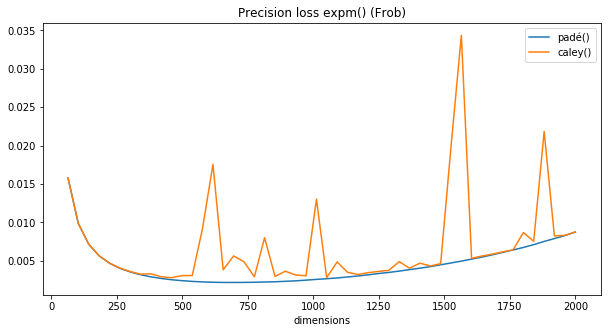

In [42]:
plt.title("Precision loss expm() (Frob)")
plt.plot(ns[:], pre[:, 0], label="padé()")
#plt.plot(ns[:], pre[:, 1], label="spectral()")
plt.plot(ns[:], pre[:, 2], label="caley()")
plt.xlabel("dimensions")
#plt.yscale("log")
plt.legend()
pre[:5, 0] - pre[:5, 2]

# Convergence

### Code

In [6]:
_, W_white, W = fit_pca(X, -1, True)

/home/matthias/Desktop/workspace/novelty-detection/novelty_detection/metrics/linear_model.py:43: UserWarning: X is not centered (mean was 410.0276794433594)
  warnings.warn(f"X is not centered (mean was {np.abs(X.mean(0)).sum()})")


In [7]:
explained_variance = np.cumsum((X @ W).var(0)) / X.var(0).sum()

In [8]:
n_components = int((explained_variance < 0.99).sum())
n_components

808

In [9]:
_, W_white, _ = fit_pca(X, n_components, True)
X_white = X @ W_white
X_white_val = X_valid @ W_white

/home/matthias/Desktop/workspace/novelty-detection/novelty_detection/metrics/linear_model.py:43: UserWarning: X is not centered (mean was 410.0276794433594)
  warnings.warn(f"X is not centered (mean was {np.abs(X.mean(0)).sum()})")


In [10]:
X_white_val = X_white_val - X_white.mean(0)
X_white = X_white - X_white.mean(0)

In [11]:
permut = np.random.permutation(len(X_white_val))

In [12]:
iterations = [1, 5, 10, 20, 40, 60, 100, 200, 500]

In [36]:
iterations = [1, 5, 10, 20, 40, 60, 100, 200, 500]#, 500, 1000, 2000]
kurt_scores = []
mi = []
logps = []
times = []
mi_opt = []

for i, max_iters in enumerate(iterations):
    
    np.random.seed(42)
    
    mut_inf_opt = []
    mut_inf = []
    score = []
    logp = []
    mut_inf = []
    tt = []
    for i in range(1):
        t0 = time.time()
        ica = FastICA(whiten=False, max_iter=max_iters, tol=1e-20, fun="exp").fit(X_white)
        W = ica.components_.T
        S = X_white_val @ W

        tt.append(time.time() - t0)
        #mut_inf_opt.append(mutual_information([S[:,i:i+1] for i in range(len(S.T))]))
        score.append(kurt(S))
        logp.append(logcosh_normalized(S).mean())
        mut_inf.append(mutual_information_approx(S, expn))

    times.append(tt)
    mi_opt.append(mut_inf_opt)
    mi.append(mut_inf)
    kurt_scores.append(score)
    logps.append(logp)
    print(max_iters, "kurtosis:", score, "logp:", logp, "mi:", mut_inf, times[-1])

/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


1 kurtosis: [0.7887711] logp: [-2.8319154] mi: [-0.03142564] [1.5468900203704834]


/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


5 kurtosis: [0.84812963] logp: [-2.830966] mi: [-0.036878474] [6.804680585861206]


/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


10 kurtosis: [1.0703182] logp: [-2.8285923] mi: [-0.09451895] [13.066086053848267]


/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


20 kurtosis: [1.9501593] logp: [-2.8186436] mi: [-0.48586404] [25.74716830253601]


/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


40 kurtosis: [5.060506] logp: [-2.780233] mi: [-2.221579] [51.04753804206848]


KeyboardInterrupt: 

In [24]:
from fasterica import *

iterations = [1, 5, 10, 20, 40, 60, 100, 200, 500]#, 200, 500, 1000, 2000]
bs=500
iters_per_epoch = X.shape[0]//bs

kurt_scores_fasterica = []
mi_fasterica = []
logps_fasterica = []
times_fasterica = []
mi_opt_fasterica = []

for i, max_iters in enumerate(iterations):
    
    np.random.seed(123)
    torch.manual_seed(123)
    
    mut_inf = []
    mut_inf_opt = []
    score = []
    logp = []
    tt = []
    for j in range(1):
        t0 = time.time()
        
        model = FasterICA(X_white.shape[1], loss="adaptiveexpK", optimistic_whitening_rate=1.0, whitening_strategy="batch", whiten=False, optimizer="adam")
        model.to("cpu")
        model.fit(X_white, X_val=X_white_val, lr=1e-3, epochs=max_iters, bs=bs, logging=1)
        W = model.components_.T
        
        #model = FasterICA(X.shape[1], n_components, whitening_algo="None", loss="logcosh") # max([1, max_iters//iters_per_epoch])
        #model.fit(X_white, epochs=max_iters, lr=1e-3, log_interval=1000, bs=bs, beta_whitening=0., optimizer="adam", use_cuda=False )
        #W = model.get_I(True)
        S = X_white_val @ W

        tt.append(time.time() -t0)
        #mut_inf_opt.append(mutual_information([S[:,i:i+1] for i in range(len(S.T))]))
        score.append(kurt(S))
        logp.append(logcosh_normalized(S).mean())
        mut_inf.append(mutual_information_approx(S, expn))
   
    times_fasterica.append(tt)
    mi_fasterica.append(mut_inf)
    mi_opt_fasterica.append(mut_inf_opt)
    kurt_scores_fasterica.append(score)
    logps_fasterica.append(logp)
    print(max_iters, "kurtosis:", score, "logp:", logp, "mi:", mut_inf, tt)

 99%|█████████▉| 99/100 [00:05<00:00, 18.82it/s]
Ep.  0 - -0.7017 - validation (loss/white/kurt/mi/logp): -0.7045 / 0.01 / 0.79 / -0.0585 / 0.0000 (eval took: 0.4s)
1 kurtosis: [0.7877969] logp: [-2.8318987] mi: [-0.058505572] [5.669098615646362]
 99%|█████████▉| 99/100 [00:05<00:00, 18.76it/s]
Ep.  0 - -0.7017 - validation (loss/white/kurt/mi/logp): -0.7045 / 0.01 / 0.79 / -0.0585 / 0.0000 (eval took: 0.3s)
Ep.  1 - -0.7110 - validation (loss/white/kurt/mi/logp): -0.7077 / 0.01 / 0.80 / -0.0607 / 0.0000 (eval took: 0.3s)
Ep.  2 - -0.7181 - validation (loss/white/kurt/mi/logp): -0.7081 / 0.01 / 0.81 / -0.0635 / 0.0000 (eval took: 0.3s)
Ep.  3 - -0.7230 - validation (loss/white/kurt/mi/logp): -0.7105 / 0.01 / 0.82 / -0.0671 / 0.0000 (eval took: 0.3s)
Ep.  4 - -0.7266 - validation (loss/white/kurt/mi/logp): -0.7115 / 0.01 / 0.85 / -0.0728 / 0.0000 (eval took: 0.3s)
5 kurtosis: [0.8467641] logp: [-2.83094] mi: [-0.07276712] [27.539077281951904]
 99%|█████████▉| 99/100 [00:05<00:00, 19.02i

Ep. 30 - -0.7764 - validation (loss/white/kurt/mi/logp): -0.7706 / 0.01 / 5.46 / -3.0471 / 0.0000 (eval took: 0.3s)
Ep. 31 - -0.7783 - validation (loss/white/kurt/mi/logp): -0.7733 / 0.01 / 5.68 / -3.2054 / 0.0000 (eval took: 0.3s)
Ep. 32 - -0.7801 - validation (loss/white/kurt/mi/logp): -0.7759 / 0.01 / 5.90 / -3.3699 / 0.0000 (eval took: 0.3s)
Ep. 33 - -0.7820 - validation (loss/white/kurt/mi/logp): -0.7784 / 0.01 / 6.10 / -3.5287 / 0.0000 (eval took: 0.3s)
Ep. 34 - -0.7837 - validation (loss/white/kurt/mi/logp): -0.7804 / 0.01 / 6.29 / -3.6736 / 0.0000 (eval took: 0.3s)
Ep. 35 - -0.7854 - validation (loss/white/kurt/mi/logp): -0.7820 / 0.01 / 6.46 / -3.8045 / 0.0000 (eval took: 0.3s)
Ep. 36 - -0.7870 - validation (loss/white/kurt/mi/logp): -0.7840 / 0.01 / 6.62 / -3.9236 / 0.0000 (eval took: 0.3s)
Ep. 37 - -0.7884 - validation (loss/white/kurt/mi/logp): -0.7859 / 0.01 / 6.77 / -4.0375 / 0.0000 (eval took: 0.3s)
Ep. 38 - -0.7898 - validation (loss/white/kurt/mi/logp): -0.7874 / 0.01 

60 kurtosis: [7.88546] logp: [-2.7457206] mi: [-4.834959] [333.02372765541077]
 99%|█████████▉| 99/100 [00:05<00:00, 18.91it/s]
Ep.  0 - -0.7017 - validation (loss/white/kurt/mi/logp): -0.7045 / 0.01 / 0.79 / -0.0585 / 0.0000 (eval took: 0.3s)
Ep.  1 - -0.7110 - validation (loss/white/kurt/mi/logp): -0.7077 / 0.01 / 0.80 / -0.0607 / 0.0000 (eval took: 0.3s)
Ep.  2 - -0.7181 - validation (loss/white/kurt/mi/logp): -0.7081 / 0.01 / 0.81 / -0.0635 / 0.0000 (eval took: 0.3s)
Ep.  3 - -0.7230 - validation (loss/white/kurt/mi/logp): -0.7105 / 0.01 / 0.82 / -0.0671 / 0.0000 (eval took: 0.3s)
Ep.  4 - -0.7266 - validation (loss/white/kurt/mi/logp): -0.7115 / 0.01 / 0.85 / -0.0728 / 0.0000 (eval took: 0.3s)
Ep.  5 - -0.7296 - validation (loss/white/kurt/mi/logp): -0.7141 / 0.01 / 0.90 / -0.0885 / 0.0000 (eval took: 0.3s)
Ep.  6 - -0.7320 - validation (loss/white/kurt/mi/logp): -0.7145 / 0.01 / 0.99 / -0.1222 / 0.0000 (eval took: 0.3s)
Ep.  7 - -0.7342 - validation (loss/white/kurt/mi/logp): -0.

KeyboardInterrupt: 

In [15]:
iterations = [1, 5, 10, 20, 40, 60, 100, 200, 500]#, 500, 1000, 2000]
bs=len(X)
iters_per_epoch = len(X)//bs
kurt_scores_fasterica_offline_sgd = []
mi_fasterica_offline_sgd = []
logps_fasterica_offline_sgd = []
times_fasterica_offline_sgd = []
mi_opt_fasterica_offline_sgd = []
t0 = time.time()

for i, max_iters in enumerate(iterations):
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    mut_inf = []
    mut_inf_opt = []
    score = []
    logp = []
    tt = []
    for i in range(1):
        t0 = time.time()
        model = FasterICA(X.shape[1], n_components, whitening_algo="None", loss="logcosh")
        model.fit(X_white, epochs=max_iters, log_interval=1000, bs=bs, beta_whitening=0., optimizer="sgd", lr=1e-3, use_cuda=False)
        W = model.get_I(True)
        S = X_white_val @ W

        tt.append(time.time() -t0)
        #mut_inf_opt.append(mutual_information([S[:,i:i+1] for i in range(len(S.T))]))
        score.append(kurt(S))
        logp.append(logcosh_normalized(S).mean())
        mut_inf.append(mutual_information_approx(S, logcosh))
    
    times_fasterica_offline_sgd.append(tt)
    mi_fasterica_offline_sgd.append(mut_inf)
    mi_opt_fasterica_offline_sgd.append(mut_inf_opt)
    kurt_scores_fasterica_offline_sgd.append(score)
    logps_fasterica_offline_sgd.append(logp)
    print(max_iters, "kurtosis:", score, "logp:", logp)

Begin training: 1 epochs.
Begin training: 5 epochs.


1 kurtosis: [1.0484711] logp: [-2.8270736]


Begin training: 10 epochs.


5 kurtosis: [1.0488026] logp: [-2.8270667]


Begin training: 20 epochs.


10 kurtosis: [1.0495768] logp: [-2.827056]


Begin training: 40 epochs.


20 kurtosis: [1.0517607] logp: [-2.827025]


Begin training: 60 epochs.


40 kurtosis: [1.0570207] logp: [-2.8269472]


Begin training: 100 epochs.


60 kurtosis: [1.0625702] logp: [-2.8268719]


Begin training: 200 epochs.


100 kurtosis: [1.0739207] logp: [-2.8267121]


Begin training: 500 epochs.


200 kurtosis: [1.1032755] logp: [-2.8262994]
500 kurtosis: [1.1963013] logp: [-2.825035]


In [16]:
iterations = [1, 5, 10, 20, 40, 60, 100, 200, 500]#, 500, 1000, 2000]
bs=len(X)
iters_per_epoch = len(X)//bs
kurt_scores_fasterica_offline_bgfs = []
mi_fasterica_offline_bgfs = []
logps_fasterica_offline_bgfs = []
times_fasterica_offline_bgfs = []
mi_opt_fasterica_offline_bgfs = []
t0 = time.time()

for i, max_iters in enumerate(iterations):
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    mut_inf = []
    mut_inf_opt = []
    score = []
    logp = []
    tt = []
    for i in range(1):
        t0 = time.time()
        model = FasterICA(X.shape[1], n_components, whitening_algo="None", loss="logcosh")
        model.fit(X_white, epochs=max_iters, log_interval=1000, bs=bs, beta_whitening=0., optimizer="lbgfs", use_cuda=False)
        W = model.get_I(True)
        S = X_white_val @ W

        tt.append(time.time() -t0)
        #mut_inf_opt.append(mutual_information([S[:,i:i+1] for i in range(len(S.T))]))
        score.append(kurt(S))
        logp.append(logcosh_normalized(S).mean())
        mut_inf.append(mutual_information_approx(S, logcosh))
    
    times_fasterica_offline_bgfs.append(tt)
    mi_fasterica_offline_bgfs.append(mut_inf)
    mi_opt_fasterica_offline_bgfs.append(mut_inf_opt)
    kurt_scores_fasterica_offline_bgfs.append(score)
    logps_fasterica_offline_bgfs.append(logp)
    print(max_iters, "kurtosis:", score, "logp:", logp)


The _imaging extension was built for another version of Pillow or PIL:
Core version: 5.2.0
Pillow version: 5.4.1
[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda/envs/pytorch/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/opt/anaconda/envs/pytorch/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/anaconda/envs/pytorch/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/opt/anaconda/envs/pytorch/lib/python3.6/sit

1 kurtosis: [1.0484437] logp: [-2.8270736]


Begin training: 10 epochs.


5 kurtosis: [1.0788944] logp: [-2.8266122]


Begin training: 20 epochs.


10 kurtosis: [1.0925512] logp: [-2.8264465]


Begin training: 40 epochs.


20 kurtosis: [1.1204969] logp: [-2.8260953]


Begin training: 60 epochs.


40 kurtosis: [1.1754346] logp: [-2.825439]


Begin training: 100 epochs.


60 kurtosis: [1.2394866] logp: [-2.8247275]


Begin training: 200 epochs.


100 kurtosis: [1.403743] logp: [-2.8232653]


Begin training: 500 epochs.


200 kurtosis: [1.8647659] logp: [-2.818961]
500 kurtosis: [3.641205] logp: [-2.801395]


In [17]:
iterations = [1, 5, 10, 20, 40, 60, 100, 200,500]#, 500, 1000, 2000]
bs=len(X)
iters_per_epoch = len(X)//bs

kurt_scores_fasterica_offline = []
mi_fasterica_offline = []
logps_fasterica_offline = []
times_fasterica_offline = []
mi_opt_fasterica_offline = []
t0 = time.time()

for i, max_iters in enumerate(iterations):
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    mut_inf = []
    mut_inf_opt = []
    score = []
    logp = []
    tt = []
    for i in range(1):
        t0 = time.time()
        model = FasterICA(X.shape[1], n_components, whitening_algo="None", loss="logcosh")
        model.fit(X_white, epochs=max_iters, lr=1e-2, log_interval=1000, bs=bs, beta_whitening=0., optimizer="adam", use_cuda=False)
        W = model.get_I(True)
        S = X_white_val @ W

        tt.append(time.time() - t0)
        #mut_inf_opt.append(mutual_information([S[:,i:i+1] for i in range(len(S.T))]))
        score.append(kurt(S))
        logp.append(logcosh_normalized(S).mean())
        mut_inf.append(mutual_information_approx(S, logcosh))
    
    times_fasterica_offline.append(tt)
    mi_fasterica_offline.append(mut_inf)
    mi_opt_fasterica_offline.append(mut_inf_opt)
    kurt_scores_fasterica_offline.append(score)
    logps_fasterica_offline.append(logp)
    print(max_iters, "kurtosis:", score, "logp:", logp)

Begin training: 1 epochs.
Begin training: 5 epochs.


1 kurtosis: [0.76858217] logp: [-2.832256]


Begin training: 10 epochs.


5 kurtosis: [0.7694429] logp: [-2.8322427]


Begin training: 20 epochs.


10 kurtosis: [0.7868252] logp: [-2.8319216]


Begin training: 40 epochs.


20 kurtosis: [2.177184] logp: [-2.8176186]


Begin training: 60 epochs.


40 kurtosis: [6.756976] logp: [-2.761291]


Begin training: 100 epochs.


60 kurtosis: [8.035996] logp: [-2.7453423]


Begin training: 200 epochs.


100 kurtosis: [8.253274] logp: [-2.7422435]


Begin training: 500 epochs.


200 kurtosis: [8.208849] logp: [-2.7425041]
500 kurtosis: [8.202362] logp: [-2.7426193]


In [18]:
from picard import picard

iterations = [1, 5, 10, 20, 40, 60, 100, 200, 500]#, 500, 1000, 2000]
bs=len(X)
iters_per_epoch = len(X)//bs

kurt_scores_picard_offline = []
mi_picard_offline = []
logps_picard_offline = []
times_picard_offline = []
mi_opt_picard_offline = []
t0 = time.time()

for i, max_iters in enumerate(iterations):
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    mut_inf = []
    mut_inf_opt = []
    score = []
    logp = []
    tt = []
    for i in range(1):
        t0 = time.time()
        K,W,Y = picard(X_white.T, fun='tanh', n_components=100, ortho=True, extended=None, whiten=False, return_X_mean=False, return_n_iter=False,
                   centering=True, max_iter=max_iters, tol=1e-10, m=7,  ls_tries=10,
                   lambda_min=0.01, check_fun=True, w_init=None, fastica_it=None,
                   random_state=None, verbose=False)
        W = W.T
        S = X_white_val @ W

        tt.append(time.time() - t0)
        #mut_inf_opt.append(mutual_information([S[:,i:i+1] for i in range(len(S.T))]))
        score.append(kurt(S))
        logp.append(logcosh_normalized(S).mean())
        mut_inf.append(mutual_information_approx(S, logcosh))
    
    times_picard_offline.append(tt)
    mi_picard_offline.append(mut_inf)
    mi_opt_picard_offline.append(mut_inf_opt)
    kurt_scores_picard_offline.append(score)
    logps_picard_offline.append(logp)
    print(max_iters, "kurtosis:", score, "logp:", logp)


Whiten is set to false, ignoring parameter n_components
Picard did not converge. Final gradient norm : 0.002734. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.


1 kurtosis: [0.7913017074152572] logp: [-2.831918587072579]


Picard did not converge. Final gradient norm : 0.009106. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.


5 kurtosis: [0.9259402471733452] logp: [-2.8301376051680007]


Picard did not converge. Final gradient norm : 0.01196. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.


10 kurtosis: [1.737635225598946] logp: [-2.822244121579303]


Picard did not converge. Final gradient norm : 0.01377. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.


20 kurtosis: [4.368960714946825] logp: [-2.7922265574087994]


Picard did not converge. Final gradient norm : 0.01166. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.


40 kurtosis: [7.786340443562044] logp: [-2.7490278836482163]


Picard did not converge. Final gradient norm : 0.004633. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.


60 kurtosis: [8.255468770421597] logp: [-2.7435835569738356]


Picard did not converge. Final gradient norm : 0.001384. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.


100 kurtosis: [8.404950131035527] logp: [-2.742297006287867]


Picard did not converge. Final gradient norm : 0.0006927. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.


200 kurtosis: [8.38601929394694] logp: [-2.7418938483449904]


Picard did not converge. Final gradient norm : 9.904e-06. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.


500 kurtosis: [8.385866616371949] logp: [-2.741906065662591]


In [ ]:
from picard import picard

iterations = [1, 5, 10, 20, 40, 60, 100, 200, 500]#, 500, 1000, 2000]
bs=len(X)
iters_per_epoch = len(X)//bs

kurt_scores_picard_offline = []
mi_picard_offline = []
logps_picard_offline = []
times_picard_offline = []
mi_opt_picard_offline = []
t0 = time.time()

for i, max_iters in enumerate(iterations):
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    mut_inf = []
    mut_inf_opt = []
    score = []
    logp = []
    tt = []
    for i in range(1):
        t0 = time.time()
        K,W,Y = picard(X_white.T, fun='exp', n_components=100, ortho=True, extended=None, whiten=False, return_X_mean=False, return_n_iter=False,
                   centering=True, max_iter=max_iters, tol=1e-10, m=7,  ls_tries=10,
                   lambda_min=0.01, check_fun=True, w_init=None, fastica_it=None,
                   random_state=None, verbose=False)
        W = W.T
        S = X_white_val @ W

        tt.append(time.time() - t0)
        #mut_inf_opt.append(mutual_information([S[:,i:i+1] for i in range(len(S.T))]))
        score.append(kurt(S))
        logp.append(logcosh_normalized(S).mean())
        mut_inf.append(mutual_information_approx(S, logcosh))
    
    times_picard_offline.append(tt)
    mi_picard_offline.append(mut_inf)
    mi_opt_picard_offline.append(mut_inf_opt)
    kurt_scores_picard_offline.append(score)
    logps_picard_offline.append(logp)
    print(max_iters, "kurtosis:", score, "logp:", logp)


### Training data

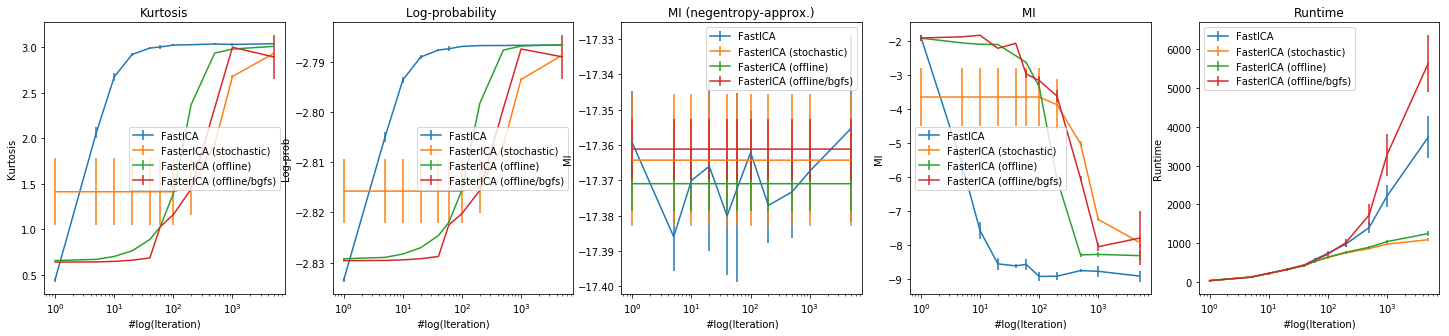

In [219]:
plt.rcParams["figure.figsize"] = (25,5)

def asarrm(listlike):
    return np.asarray(listlike).T.mean(0)

def asarrs(listlike):
    return np.asarray(listlike).T.std(0)

ax = plt.subplot(1,5,1)
ax.set_xscale("log")
ax.errorbar(iterations, asarrm(kurt_scores), asarrs(kurt_scores), label="FastICA")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica), asarrs(kurt_scores_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica_offline), asarrs(kurt_scores_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica_offline_bgfs), asarrs(kurt_scores_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
plt.title("Kurtosis")
plt.xlabel("#log(Iteration)")
plt.ylabel("Kurtosis")
plt.legend()

ax = plt.subplot(1,5,2)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(logps), asarrs(logps),label="FastICA")
ax.errorbar(iterations, asarrm(logps_fasterica),asarrs(logps_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(logps_fasterica_offline), asarrs(logps_fasterica_offline),label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(logps_fasterica_offline_bgfs), asarrs(logps_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
plt.title("Log-probability ")
plt.xlabel("#log(Iteration)")
plt.ylabel("Log-prob")
plt.legend()

ax = plt.subplot(1,5,3)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(mi), asarrs(mi),label="FastICA")
ax.errorbar(iterations, asarrm(mi_fasterica), asarrs(mi_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(mi_fasterica_offline), asarrs(mi_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(mi_fasterica_offline_bgfs),asarrs(mi_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
plt.title("MI (negentropy-approx.)")
plt.xlabel("#log(Iteration)")
plt.ylabel("MI")
plt.legend()

ax = plt.subplot(1,5,4)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(mi_opt), asarrs(mi_opt), label="FastICA")
ax.errorbar(iterations, asarrm(mi_opt_fasterica), asarrs(mi_opt_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(mi_opt_fasterica_offline), asarrs(mi_opt_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(mi_opt_fasterica_offline_bgfs), asarrs(mi_opt_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
plt.title("MI ")
plt.xlabel("#log(Iteration)")
plt.ylabel("MI")
plt.legend()

ax = plt.subplot(1,5,5)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(times), asarrs(times), label="FastICA")
ax.errorbar(iterations, asarrm(times_fasterica), asarrs(times_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(times_fasterica_offline), asarrs(times_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(times_fasterica_offline_bgfs), asarrs(times_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
plt.title("Runtime")
plt.xlabel("#log(Iteration)")
plt.ylabel("Runtime")
plt.legend()

In [222]:
import pickle
exp_data_kurtosis = {
    "FastICA" : [kurt_scores, logps, mi, mi_opt, times],
    "FasterICA (stochastic" : [kurt_scores_fasterica, logps_fasterica, mi_fasterica, mi_opt_fasterica, times_fasterica],
    "FasterICA (offline)" : [kurt_scores_fasterica_offline, logps_fasterica_offline, mi_fasterica_offline, mi_opt_fasterica_offline, times_fasterica_offline],
    "FasterICA (offline/bgfs)" : [kurt_scores_fasterica_offline_bgfs, logps_fasterica_offline_bgfs, mi_fasterica_offline_bgfs, mi_opt_fasterica_offline_bgfs, times_fasterica_offline_bgfs],   
}
pickle.dump(exp_data_kurtosis, open("./experiments/exp_data_kurtosis.pckl", 'wb'))

In [228]:
dat = pickle.load(open("./experiments/exp_data_kurtosis.pckl", 'rb'))

### Validation data

[]

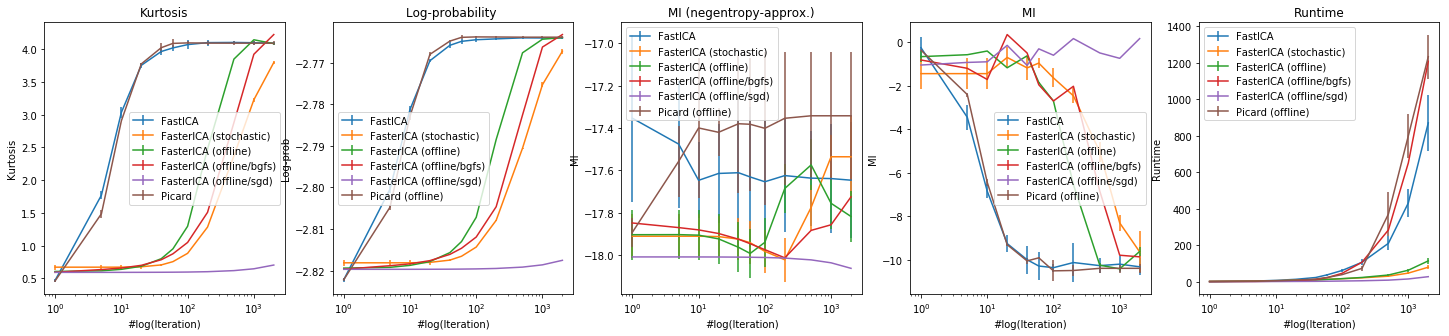

In [538]:
plt.rcParams["figure.figsize"] = (25,5)

def asarrm(listlike):
    return np.asarray(listlike).T.mean(0)

def asarrs(listlike):
    return np.asarray(listlike).T.std(0)

ax = plt.subplot(1,5,1)
ax.set_xscale("log")
ax.errorbar(iterations, asarrm(kurt_scores), asarrs(kurt_scores), label="FastICA")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica), asarrs(kurt_scores_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica_offline), asarrs(kurt_scores_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica_offline_bgfs), asarrs(kurt_scores_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica_offline_sgd), asarrs(kurt_scores_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(iterations, asarrm(kurt_scores_picard_offline), asarrs(kurt_scores_picard_offline), label="Picard")


plt.title("Kurtosis")
plt.xlabel("#log(Iteration)")
plt.ylabel("Kurtosis")
plt.legend()

ax = plt.subplot(1,5,2)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(logps), asarrs(logps),label="FastICA")
ax.errorbar(iterations, asarrm(logps_fasterica),asarrs(logps_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(logps_fasterica_offline), asarrs(logps_fasterica_offline),label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(logps_fasterica_offline_bgfs), asarrs(logps_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(iterations, asarrm(logps_fasterica_offline_sgd), asarrs(logps_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(iterations, asarrm(logps_picard_offline), asarrs(logps_picard_offline),label="Picard (offline)")

plt.title("Log-probability ")
plt.xlabel("#log(Iteration)")
plt.ylabel("Log-prob")
plt.legend()

ax = plt.subplot(1,5,3)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(mi), asarrs(mi),label="FastICA")
ax.errorbar(iterations, asarrm(mi_fasterica), asarrs(mi_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(mi_fasterica_offline), asarrs(mi_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(mi_fasterica_offline_bgfs),asarrs(mi_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(iterations, asarrm(mi_fasterica_offline_sgd),asarrs(mi_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(iterations, asarrm(mi_picard_offline), asarrs(mi_picard_offline), label="Picard (offline)")
plt.title("MI (negentropy-approx.)")
plt.xlabel("#log(Iteration)")
plt.ylabel("MI")
plt.legend()

ax = plt.subplot(1,5,4)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(mi_opt), asarrs(mi_opt), label="FastICA")
ax.errorbar(iterations, asarrm(mi_opt_fasterica), asarrs(mi_opt_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(mi_opt_fasterica_offline), asarrs(mi_opt_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(mi_opt_fasterica_offline_bgfs), asarrs(mi_opt_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(iterations, asarrm(mi_opt_fasterica_offline_sgd), asarrs(mi_opt_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(iterations, asarrm(mi_opt_picard_offline), asarrs(mi_opt_picard_offline), label="Picard (offline)")
plt.title("MI ")
plt.xlabel("#log(Iteration)")
plt.ylabel("MI")
plt.legend()

ax = plt.subplot(1,5,5)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(times), asarrs(times), label="FastICA")
ax.errorbar(iterations, asarrm(times_fasterica), asarrs(times_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(times_fasterica_offline), asarrs(times_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(times_fasterica_offline_bgfs), asarrs(times_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(iterations, asarrm(times_fasterica_offline_sgd), asarrs(times_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(iterations, asarrm(times_picard_offline), asarrs(times_picard_offline), label="Picard (offline)")
plt.title("Runtime")
plt.xlabel("#log(Iteration)")
plt.ylabel("Runtime")
plt.legend()




[]

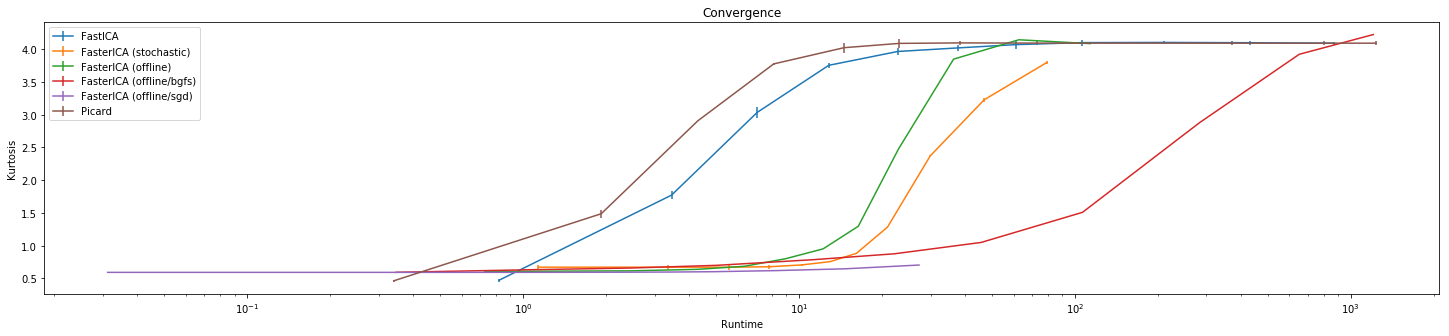

In [540]:
ax = plt.subplot(1,1,1)
ax.set_xscale("log")
ax.errorbar(asarrm(times), asarrm(kurt_scores), asarrs(kurt_scores), label="FastICA")
ax.errorbar(asarrm(times_fasterica), asarrm(kurt_scores_fasterica), asarrs(kurt_scores_fasterica), label="FasterICA (stochastic)")
ax.errorbar(asarrm(times_fasterica_offline), asarrm(kurt_scores_fasterica_offline), asarrs(kurt_scores_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(asarrm(times_fasterica_offline_bgfs), asarrm(kurt_scores_fasterica_offline_bgfs), asarrs(kurt_scores_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(asarrm(times_fasterica_offline_sgd), asarrm(kurt_scores_fasterica_offline_sgd), asarrs(kurt_scores_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(asarrm(times_picard_offline), asarrm(kurt_scores_picard_offline), asarrs(kurt_scores_picard_offline), label="Picard")
plt.title("Convergence")
plt.xlabel("Runtime")
plt.ylabel("Kurtosis")
plt.legend()
plt.plot()

In [268]:
import pickle
exp_data_kurtosis = {
    "FastICA" : [kurt_scores, logps, mi, mi_opt, times],
    "FasterICA (stochastic" : [kurt_scores_fasterica, logps_fasterica, mi_fasterica, mi_opt_fasterica, times_fasterica],
    "FasterICA (offline)" : [kurt_scores_fasterica_offline, logps_fasterica_offline, mi_fasterica_offline, mi_opt_fasterica_offline, times_fasterica_offline],
    "FasterICA (offline/bgfs)" : [kurt_scores_fasterica_offline_bgfs, logps_fasterica_offline_bgfs, mi_fasterica_offline_bgfs, mi_opt_fasterica_offline_bgfs, times_fasterica_offline_bgfs],   
    "FasterICA (offline/sgd)" : [kurt_scores_fasterica_offline_sgd, logps_fasterica_offline_sgd, mi_fasterica_offline_sgd, mi_opt_fasterica_offline_sgd, times_fasterica_offline_sgd],   

}
pickle.dump(exp_data_kurtosis, open("./experiments/exp_data_kurtosis_validation.pckl", 'wb'))

In [228]:
dat = pickle.load(open("./experiments/exp_data_kurtosis_validation.pckl", 'rb'))

### Full Dataset (95 % ~312 components)

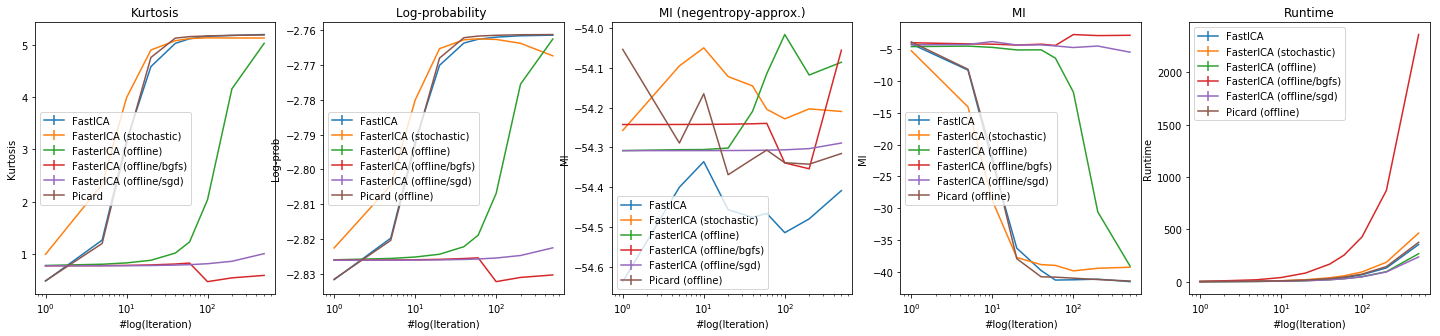

In [636]:
plt.rcParams["figure.figsize"] = (25,5)

def asarrm(listlike):
    return np.asarray(listlike).T.mean(0)

def asarrs(listlike):
    return np.asarray(listlike).T.std(0)

ax = plt.subplot(1,5,1)
ax.set_xscale("log")
ax.errorbar(iterations, asarrm(kurt_scores), asarrs(kurt_scores), label="FastICA")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica), asarrs(kurt_scores_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica_offline), asarrs(kurt_scores_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica_offline_bgfs), asarrs(kurt_scores_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica_offline_sgd), asarrs(kurt_scores_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(iterations, asarrm(kurt_scores_picard_offline), asarrs(kurt_scores_picard_offline), label="Picard")


plt.title("Kurtosis")
plt.xlabel("#log(Iteration)")
plt.ylabel("Kurtosis")
plt.legend()

ax = plt.subplot(1,5,2)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(logps), asarrs(logps),label="FastICA")
ax.errorbar(iterations, asarrm(logps_fasterica),asarrs(logps_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(logps_fasterica_offline), asarrs(logps_fasterica_offline),label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(logps_fasterica_offline_bgfs), asarrs(logps_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(iterations, asarrm(logps_fasterica_offline_sgd), asarrs(logps_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(iterations, asarrm(logps_picard_offline), asarrs(logps_picard_offline),label="Picard (offline)")

plt.title("Log-probability ")
plt.xlabel("#log(Iteration)")
plt.ylabel("Log-prob")
plt.legend()

ax = plt.subplot(1,5,3)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(mi), asarrs(mi),label="FastICA")
ax.errorbar(iterations, asarrm(mi_fasterica), asarrs(mi_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(mi_fasterica_offline), asarrs(mi_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(mi_fasterica_offline_bgfs),asarrs(mi_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(iterations, asarrm(mi_fasterica_offline_sgd),asarrs(mi_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(iterations, asarrm(mi_picard_offline), asarrs(mi_picard_offline), label="Picard (offline)")
plt.title("MI (negentropy-approx.)")
plt.xlabel("#log(Iteration)")
plt.ylabel("MI")
plt.legend()

ax = plt.subplot(1,5,4)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(mi_opt), asarrs(mi_opt), label="FastICA")
ax.errorbar(iterations, asarrm(mi_opt_fasterica), asarrs(mi_opt_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(mi_opt_fasterica_offline), asarrs(mi_opt_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(mi_opt_fasterica_offline_bgfs), asarrs(mi_opt_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(iterations, asarrm(mi_opt_fasterica_offline_sgd), asarrs(mi_opt_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(iterations, asarrm(mi_opt_picard_offline), asarrs(mi_opt_picard_offline), label="Picard (offline)")
plt.title("MI ")
plt.xlabel("#log(Iteration)")
plt.ylabel("MI")
plt.legend()

ax = plt.subplot(1,5,5)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(times), asarrs(times), label="FastICA")
ax.errorbar(iterations, asarrm(times_fasterica), asarrs(times_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(times_fasterica_offline), asarrs(times_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(times_fasterica_offline_bgfs), asarrs(times_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(iterations, asarrm(times_fasterica_offline_sgd), asarrs(times_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(iterations, asarrm(times_picard_offline), asarrs(times_picard_offline), label="Picard (offline)")
plt.title("Runtime")
plt.xlabel("#log(Iteration)")
plt.ylabel("Runtime")
plt.legend()




In [640]:
from novelty_detection.metrics.mutual_information import mutual_information_I1
mutual_information_I1([S[:,i:i+1] for i in range(len(S.T))])

1522.9474681230806

[]

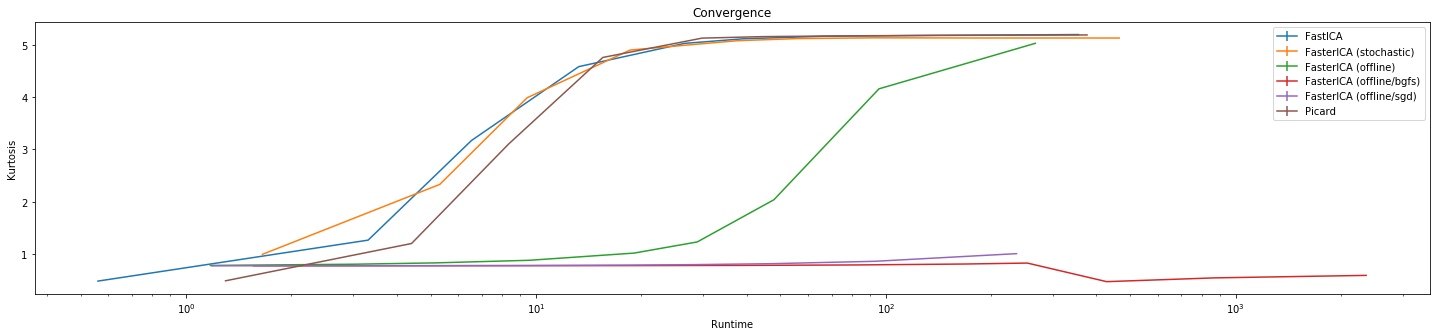

In [632]:
ax = plt.subplot(1,1,1)
ax.set_xscale("log")
ax.errorbar(asarrm(times), asarrm(kurt_scores), asarrs(kurt_scores), label="FastICA")
ax.errorbar(asarrm(times_fasterica), asarrm(kurt_scores_fasterica), asarrs(kurt_scores_fasterica), label="FasterICA (stochastic)")
ax.errorbar(asarrm(times_fasterica_offline), asarrm(kurt_scores_fasterica_offline), asarrs(kurt_scores_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(asarrm(times_fasterica_offline_bgfs), asarrm(kurt_scores_fasterica_offline_bgfs), asarrs(kurt_scores_fasterica_offline_bgfs), label="FasterICA (offline/bgfs)")
ax.errorbar(asarrm(times_fasterica_offline_sgd), asarrm(kurt_scores_fasterica_offline_sgd), asarrs(kurt_scores_fasterica_offline_sgd), label="FasterICA (offline/sgd)")
ax.errorbar(asarrm(times_picard_offline), asarrm(kurt_scores_picard_offline), asarrs(kurt_scores_picard_offline), label="Picard")
plt.title("Convergence")
plt.xlabel("Runtime")
plt.ylabel("Kurtosis")
plt.legend()
plt.plot()

In [637]:
import pickle
exp_data_kurtosis = {
    "FastICA" : [kurt_scores, logps, mi, mi_opt, times],
    "FasterICA (stochastic" : [kurt_scores_fasterica, logps_fasterica, mi_fasterica, mi_opt_fasterica, times_fasterica],
    "FasterICA (offline)" : [kurt_scores_fasterica_offline, logps_fasterica_offline, mi_fasterica_offline, mi_opt_fasterica_offline, times_fasterica_offline],
    "FasterICA (offline/bgfs)" : [kurt_scores_fasterica_offline_bgfs, logps_fasterica_offline_bgfs, mi_fasterica_offline_bgfs, mi_opt_fasterica_offline_bgfs, times_fasterica_offline_bgfs],   
    "FasterICA (offline/sgd)" : [kurt_scores_fasterica_offline_sgd, logps_fasterica_offline_sgd, mi_fasterica_offline_sgd, mi_opt_fasterica_offline_sgd, times_fasterica_offline_sgd],  
    "Picard  " : [kurt_scores_picard_offline, logps_picard_offline, mi_picard_offline, mi_opt_picard_offline, times_picard_offline],   

}
pickle.dump(exp_data_kurtosis, open("./experiments/exp_data_kurtosis_full.pckl", 'wb'))

In [638]:
dat = pickle.load(open("./experiments/exp_data_kurtosis_full.pckl", 'rb'))

### Full Dataset (99 % ~802 components)

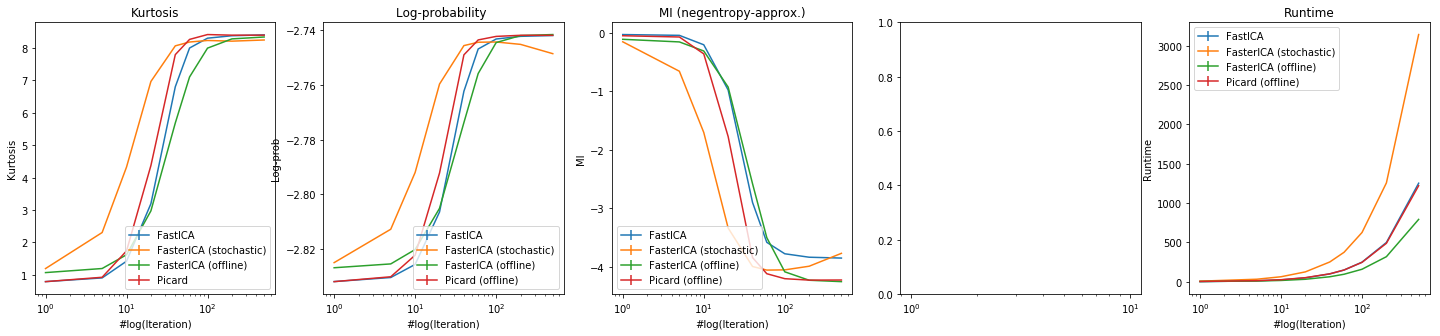

In [35]:
plt.rcParams["figure.figsize"] = (25,5)

def asarrm(listlike):
    return np.asarray(listlike).T.mean(0)

def asarrs(listlike):
    return np.asarray(listlike).T.std(0)

ax = plt.subplot(1,5,1)
ax.set_xscale("log")
ax.errorbar(iterations, asarrm(kurt_scores), asarrs(kurt_scores), label="FastICA")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica), asarrs(kurt_scores_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(kurt_scores_fasterica_offline), asarrs(kurt_scores_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(kurt_scores_picard_offline), asarrs(kurt_scores_picard_offline), label="Picard")


plt.title("Kurtosis")
plt.xlabel("#log(Iteration)")
plt.ylabel("Kurtosis")
plt.legend()

ax = plt.subplot(1,5,2)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(logps), asarrs(logps),label="FastICA")
ax.errorbar(iterations, asarrm(logps_fasterica),asarrs(logps_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(logps_fasterica_offline), asarrs(logps_fasterica_offline),label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(logps_picard_offline), asarrs(logps_picard_offline),label="Picard (offline)")

plt.title("Log-probability ")
plt.xlabel("#log(Iteration)")
plt.ylabel("Log-prob")
plt.legend()

ax = plt.subplot(1,5,3)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(mi), asarrs(mi),label="FastICA")
ax.errorbar(iterations, asarrm(mi_fasterica), asarrs(mi_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(mi_fasterica_offline), asarrs(mi_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(mi_picard_offline), asarrs(mi_picard_offline), label="Picard (offline)")
plt.title("MI (negentropy-approx.)")
plt.xlabel("#log(Iteration)")
plt.ylabel("MI")
plt.legend()

ax = plt.subplot(1,5,4)
ax.set_xscale("log")


ax = plt.subplot(1,5,5)
ax.set_xscale("log")

ax.errorbar(iterations, asarrm(times), asarrs(times), label="FastICA")
ax.errorbar(iterations, asarrm(times_fasterica), asarrs(times_fasterica), label="FasterICA (stochastic)")
ax.errorbar(iterations, asarrm(times_fasterica_offline), asarrs(times_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(iterations, asarrm(times_picard_offline), asarrs(times_picard_offline), label="Picard (offline)")
plt.title("Runtime")
plt.xlabel("#log(Iteration)")
plt.ylabel("Runtime")
plt.legend()

[]

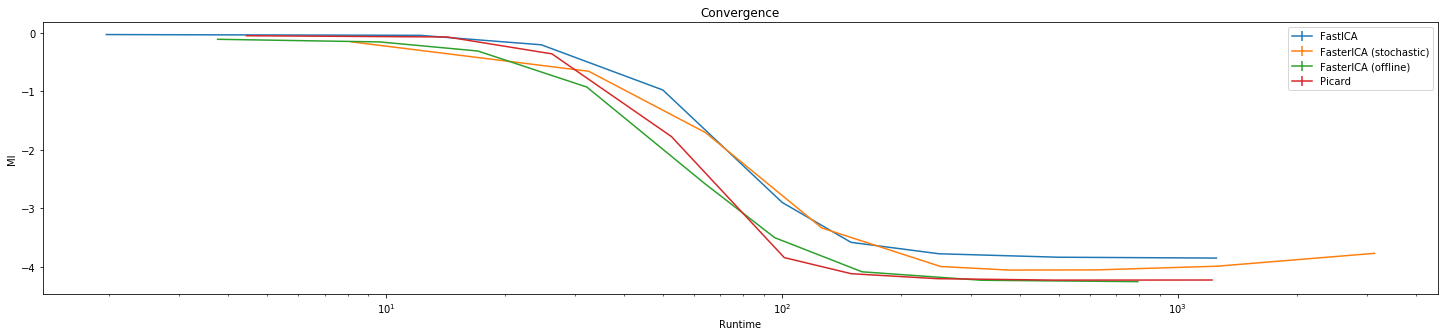

In [32]:
ax = plt.subplot(1,1,1)
ax.set_xscale("log")
ax.errorbar(asarrm(times), asarrm(mi), asarrs(mi), label="FastICA")
ax.errorbar(asarrm(times_fasterica), asarrm(mi_fasterica), asarrs(mi_fasterica), label="FasterICA (stochastic)")
ax.errorbar(asarrm(times_fasterica_offline), asarrm(mi_fasterica_offline), asarrs(mi_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(asarrm(times_picard_offline), asarrm(mi_picard_offline), asarrs(mi_picard_offline), label="Picard")
plt.title("Convergence")
plt.xlabel("Runtime")
plt.ylabel("MI")
plt.legend()
plt.plot()

[]

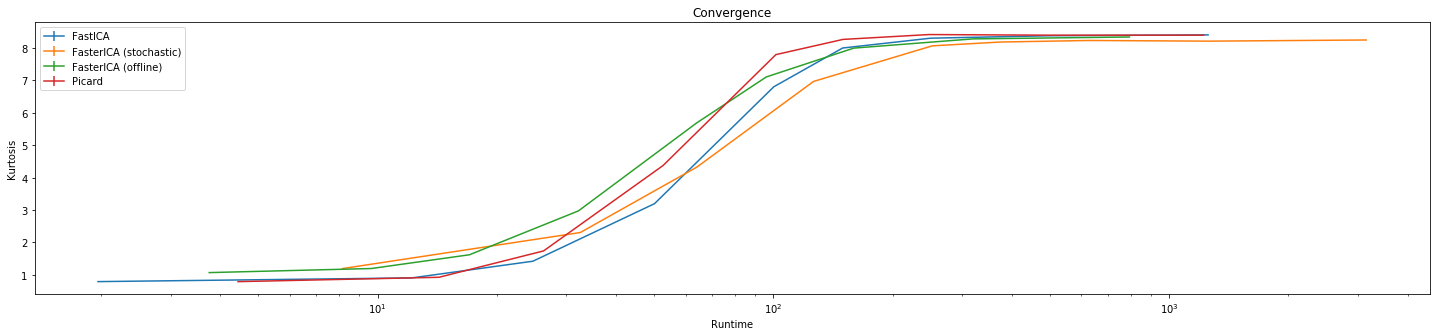

In [31]:
ax = plt.subplot(1,1,1)
ax.set_xscale("log")
ax.errorbar(asarrm(times), asarrm(kurt_scores), asarrs(kurt_scores), label="FastICA")
ax.errorbar(asarrm(times_fasterica), asarrm(kurt_scores_fasterica), asarrs(kurt_scores_fasterica), label="FasterICA (stochastic)")
ax.errorbar(asarrm(times_fasterica_offline), asarrm(kurt_scores_fasterica_offline), asarrs(kurt_scores_fasterica_offline), label="FasterICA (offline)")
ax.errorbar(asarrm(times_picard_offline), asarrm(kurt_scores_picard_offline), asarrs(kurt_scores_picard_offline), label="Picard")
plt.title("Convergence")
plt.xlabel("Runtime")
plt.ylabel("Kurtosis")
plt.legend()
plt.plot()

In [24]:
import pickle
exp_data_kurtosis = {
    "FastICA" : [kurt_scores, logps, mi, mi_opt, times],
    "FasterICA (stochastic" : [kurt_scores_fasterica, logps_fasterica, mi_fasterica, mi_opt_fasterica, times_fasterica],
    "FasterICA (offline)" : [kurt_scores_fasterica_offline, logps_fasterica_offline, mi_fasterica_offline, mi_opt_fasterica_offline, times_fasterica_offline],
    "Picard  " : [kurt_scores_picard_offline, logps_picard_offline, mi_picard_offline, mi_opt_picard_offline, times_picard_offline],   
}
pickle.dump(exp_data_kurtosis, open("./experiments/exp_data_kurtosis_full_800.pckl", 'wb'))

In [30]:
dat = pickle.load(open("./experiments/exp_data_kurtosis_full_800.pckl", 'rb'))

kurt_scores, logps, mi, mi_opt, times = dat["FastICA"]
kurt_scores_fasterica, logps_fasterica, mi_fasterica, mi_opt_fasterica, times_fasterica = dat["FasterICA (stochastic"]
kurt_scores_fasterica_offline, logps_fasterica_offline, mi_fasterica_offline, mi_opt_fasterica_offline, times_fasterica_offline = dat["FasterICA (offline)"]
kurt_scores_picard_offline, logps_picard_offline, mi_picard_offline, mi_opt_picard_offline, times_picard_offline = dat["Picard  "]

# Runtime O(n) and O(d)

In [102]:
from iosdata.cifar_novelty import Cifar10_OneClass
X, _, _ = Cifar10_OneClass(train_classes=[0,1,2,3,4,5,6,7,8,9], test_classes=[3])[0]
X = X - X.mean(1, keepdims=True)                 # DC-Component
X = X / np.linalg.norm(X, axis=1, keepdims=True) # Contrast normalization
X = X - X.mean(0)                                # Center

Files already downloaded and verified
Files already downloaded and verified
Cifar10_OneClass(z_normalize=False, train_classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], test_classes=[3], data_train=(50000, 3072), data_test_inliers=(1000, 3072), data_test_outliers=(1000, 3072))


In [103]:
_, W_white, _ = fit_pca(X, 10000, True)
X_white = X @ W_white

In [136]:
import time

ns = [100, 500, 1000, 5000, 10000, 30000, 50000]
cs = [50,  100,  500, 1000,  2000,  X_white.shape[1]]

In [105]:
from fasterica import *

In [ ]:
frame = np.zeros((7, 6))
for i,n in enumerate(ns):
    for j,c in enumerate(cs):
        try:
            t0 = time.time()
            FastICA(whiten=False, max_iter=1).fit(X_white[:n, :c])
            t1 = time.time()
            frame[i,j] = t1 - t0
        except:
            pass

In [108]:
frame1 = np.zeros((7, 6))
for i,n in enumerate(ns):
    for j,c in enumerate(cs):
        t0 = time.time()
        bs = 50000
        model = FasterICA(c, loss="adaptiveexpK", whiten=False, optimizer="adam")
        model.to("cpu")
        model.fit(X_white[:n, :c], X_val=X_white[:1, :c], lr=1e-3, epochs=1, bs=bs, logging=-1)       
        t1 = time.time()
        frame1[i,j] = t1 - t0

In [ ]:
        
frame2 = np.zeros((7, 6))
for i,n in enumerate(ns):
    for j,c in enumerate(cs):
        t0 = time.time()
        bs = 50000
        model = FasterICA(c, loss="adaptiveexpK", whiten=False, optimizer="adam")
        model.to("cuda")
        model.fit(X_white[:n, :c], X_val=X_white[:1, :c], lr=1e-3, epochs=1, bs=bs, logging=-1)
        t1 = time.time()
        frame2[i,j] = t1 - t0

In [ ]:
frame3 = np.zeros((7, 6))        
for i,n in enumerate(ns):
    for j,c in enumerate(cs):
        t0 = time.time()
        try:
            picard(X_white[:n, :c].T, fun='tanh', n_components=100, ortho=True, extended=None, whiten=False, return_X_mean=False, return_n_iter=False,
            centering=True, max_iter=1, tol=1e-10, m=7,  ls_tries=10,
            lambda_min=0.01, check_fun=True, w_init=None, fastica_it=None,
            random_state=None, verbose=False)
            t1 = time.time()
            frame3[i,j] = t1 - t0
        except:
            pass

Whiten is set to false, ignoring parameter n_components
Picard did not converge. Final gradient norm : 0.1976. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.
Picard did not converge. Final gradient norm : 0.272. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.
Picard did not converge. Final gradient norm : 0.09849. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.
Picard did not converge. Final gradient norm : 0.09262. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.
Picard did not converge. Final gradient norm : 0.1046. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.
Picard did not converge. Final gradient norm : 0.0465. Requested tolerance : 1e-10. Consider increasing the number of iterations or the tolerance.
Picard did not converge. Final gradient norm : 0.08145. Reque

In [ ]:
frame4 = np.zeros((7, 6))
for i,n in enumerate(ns):
    for j,c in enumerate(cs):
        t0 = time.time()
        bs = 2000
        model = FasterICA(c, loss="adaptiveexpK", whiten=False, optimizer="adam")
        model.to("cpu")
        model.fit(X_white[:n, :c], X_val=X_white[:1, :c], lr=1e-3, epochs=1, bs=bs, logging=-1)
        t1 = time.time()
        frame4[i,j] = t1 - t0

In [119]:
 
frame5 = np.zeros((7, 6))
for i,n in enumerate(ns):
    for j,c in enumerate(cs):
        t0 = time.time()
        bs = 2000
        model = FasterICA(c, loss="adaptiveexpK", whiten=False, optimizer="adam")
        model.to("cuda")
        model.fit(X_white[:n, :c], X_val=X_white[:1, :c], lr=1e-3, epochs=1, bs=bs, logging=-1)
        t1 = time.time()
        frame5[i,j] = t1 - t0

In [120]:
frame6 = np.zeros((7, 6))
for i,n in enumerate(ns):
    for j,c in enumerate(cs):
        t0 = time.time()
        bs = 2000
        model = FasterICA(c, whiten=False, loss="logcosh", derivative="relative")
        model.to("cpu")
        model.fit(X_white[:n, :c], X_val=X_white[:10, :c], epochs=1, bs=bs)
        t1 = time.time()
        frame6[i,j] = t1 - t0

In [121]:
frame7 = np.zeros((7, 6))
for i,n in enumerate(ns):
    for j,c in enumerate(cs):
        t0 = time.time()
        bs = 2000
        model = FasterICA(c, whiten=False, loss="logcosh", derivative="relative")
        model.to("cuda")
        model.fit(X_white[:n, :c], X_val=X_white[:10, :c], epochs=1, bs=bs)
        t1 = time.time()
        frame7[i,j] = t1 - t0
       

In [145]:
frame8 = np.zeros((7, 6))
for i,n in enumerate(ns):
    for j,c in enumerate(cs):
        t0 = time.time()
        bs = 50000
        model = FasterICA(c, loss="adaptiveexpK", whiten=False, optimizer="lbfgs")
        model.to("cpu")
        model.fit(X_white[:n, :c], X_val=X_white[:1, :c], lr=1e-0, epochs=1, bs=bs, logging=-1)
        t1 = time.time()
        frame8[i,j] = t1 - t0

In [146]:
frame9 = np.zeros((7, 6))
for i,n in enumerate(ns):
    for j,c in enumerate(cs):
        t0 = time.time()
        bs = 50000
        model = FasterICA(c, loss="adaptiveexpK", whiten=False, optimizer="lbfgs")
        model.to("cuda")
        model.fit(X_white[:n, :c], X_val=X_white[:1, :c], lr=1e-0, epochs=1, bs=bs, logging=-1)
        t1 = time.time()
        frame9[i,j] = t1 - t0

RuntimeError: CUDA out of memory. Tried to allocate 586.00 MiB (GPU 0; 10.91 GiB total capacity; 7.74 GiB already allocated; 45.94 MiB free; 8.69 GiB reserved in total by PyTorch)

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


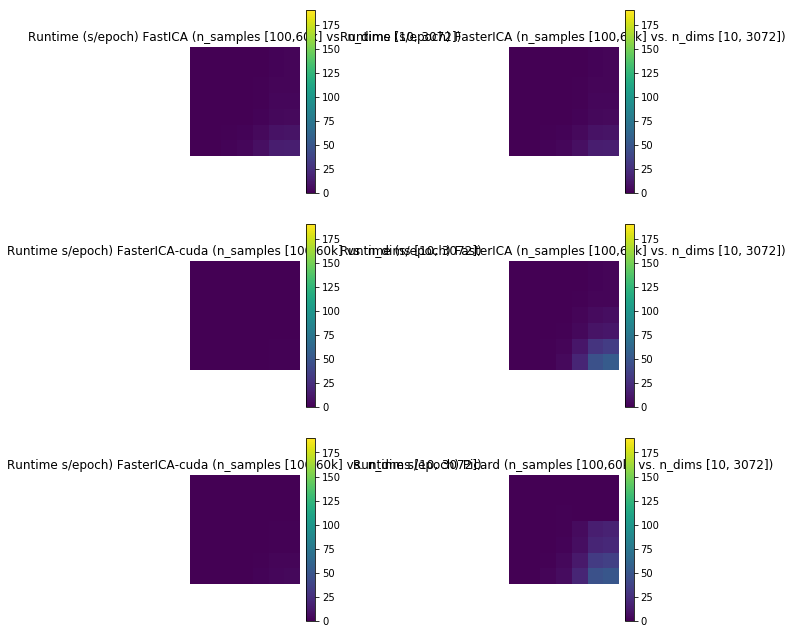

In [129]:
plt.rcParams["figure.figsize"] = (9, 9)


all_frames = np.stack([frame1, frame1, frame2, frame3, frame4, frame5, frame6, frame7, frame8, frame9])

plt.subplot(3,2,1)
plt.imshow(all_frames[0],vmin=0, vmax=all_frames.max())
plt.tight_layout()
plt.axis("off")
plt.title("Runtime (s/epoch) FastICA (n_samples [100,60k] vs. n_dims [10, 3072])")
plt.colorbar()

plt.subplot(3,2,2)
plt.imshow(all_frames[1],vmin=0, vmax=all_frames.max())
plt.tight_layout()
plt.axis("off")
plt.title("Runtime (s/epoch) FasterICA (n_samples [100,60k] vs. n_dims [10, 3072])")
plt.colorbar()

plt.subplot(3,2,3)
plt.imshow(all_frames[2],vmin=0, vmax=all_frames.max())
plt.tight_layout()
plt.axis("off")
plt.title("Runtime s/epoch) FasterICA-cuda (n_samples [100,60k] vs. n_dims [10, 3072])")
plt.colorbar()

plt.subplot(3,2,4)
plt.imshow(all_frames[4],vmin=0, vmax=all_frames.max())
plt.tight_layout()
plt.axis("off")
plt.title("Runtime (s/epoch) FasterICA (n_samples [100,60k] vs. n_dims [10, 3072])")
plt.colorbar()

plt.subplot(3,2,5)
plt.imshow(all_frames[5],vmin=0, vmax=all_frames.max())
plt.tight_layout()
plt.axis("off")
plt.title("Runtime s/epoch) FasterICA-cuda (n_samples [100,60k] vs. n_dims [10, 3072])")
plt.colorbar()

plt.subplot(3,2,6)
plt.imshow(all_frames[3],vmin=0, vmax=all_frames.max())
plt.tight_layout()
plt.axis("off")
plt.title("Runtime s/epoch) Picard (n_samples [100,60k] vs. n_dims [10, 3072])")
plt.colorbar()

plt.show()

In [155]:
allframes[0] = frame[:,:6]

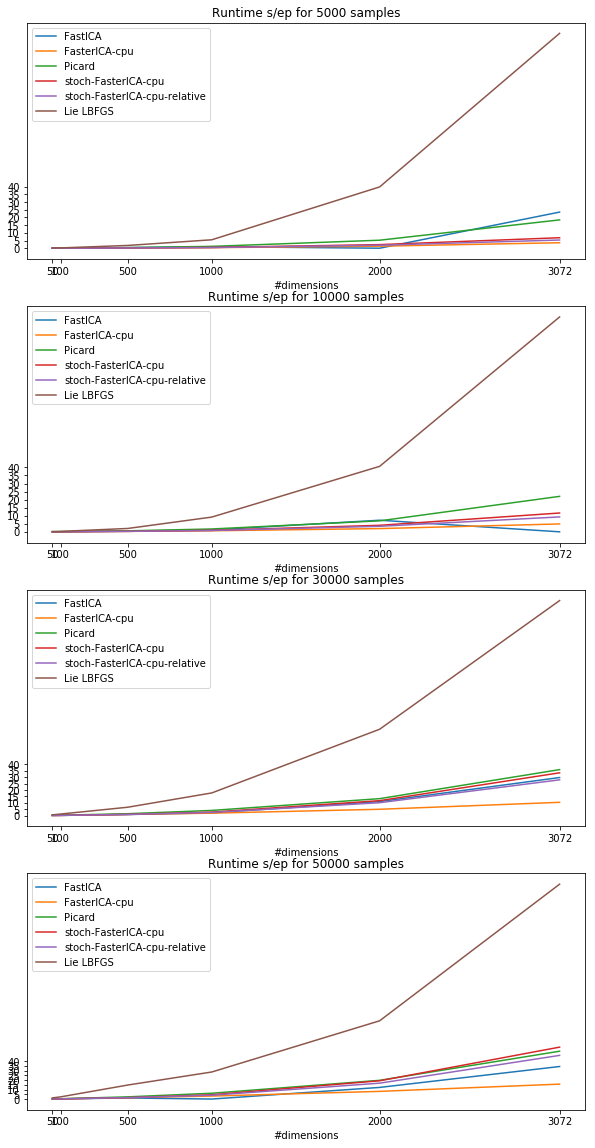

In [156]:
plt.rcParams["figure.figsize"] = (10, 20)
for j,i in enumerate(range(3,7,1)):
    plt.subplot(4,1,j+1)
    plt.title(f"Runtime s/ep for {ns[i]} samples")
    plt.plot(cs, allframes[0][i, :], label="FastICA")
    plt.plot(cs, allframes[1][i, :], label="FasterICA-cpu")
    #plt.plot(cs, all_frames[2][i, :], label="FasterICA-cuda")
    plt.plot(cs, allframes[3][i, :], label="Picard")
    plt.plot(cs, allframes[4][i, :], label="stoch-FasterICA-cpu")
    #plt.plot(cs, all_frames[5][i, :], label="stoch-FasterICA-cuda")
    plt.plot(cs, allframes[6][i, :], label="stoch-FasterICA-cpu-relative")
    #plt.plot(cs, all_frames[7][i, :], label="stoch-FasterICA-cuda-relative")
    plt.plot(cs, allframes[8][i, :], label="Lie LBFGS")
    #plt.plot(cs, all_frames[9][i, :], label="Lie LBFGS-cuda")

    plt.legend()
    plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
    plt.xticks(cs)
    plt.xlabel("#dimensions")

In [157]:
import pickle
exp_runtime = {
    "frames":all_frames
}
pickle.dump(exp_runtime, open("./experiments/exp_runtime.pckl", 'wb'))

# Runtime Whitening

In [6]:
import time
from threading import Thread

In [7]:
def frob_cov_white(W, X=X_valid):
    return np.linalg.norm(np.eye(W.shape[1]) - np.cov((X @ W).T)) / W.shape[1]

In [8]:
STOP = True
t_max = 60 * 5

In [9]:
n_components = 100

In [29]:
W_pca = fit_pca(X, n_components=n_components)
loss_pca = frob_cov_white(W_pca)
loss_pca = [frob_cov_white(W_pca)] * len(loss_gha)

X is not centered (mean was 410.0276794433594)


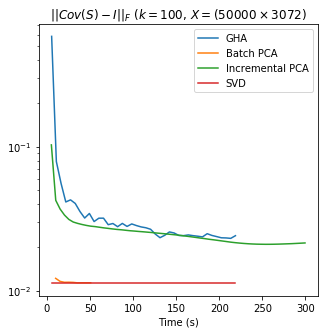

In [90]:
#loss_ppca = np.asarray(loss_ppca)
loss_gha   = np.asarray(loss_gha)
loss_batch  = np.asarray(loss_batch)
loss_inc = np.asarray(loss_inc)
#loss_hebb = np.asarray(loss_hebb)
loss_pca = np.asarray(loss_pca)


# plt.plot(loss_ppca.T[0], loss_ppca.T[1], label="ppca")
plt.plot(loss_gha.T[0], loss_gha.T[1], label="GHA")
plt.plot(loss_batch.T[0], loss_batch.T[1], label="Batch PCA")
plt.plot(loss_inc.T[0], loss_inc.T[1], label="Incremental PCA")
# plt.plot(loss_hebb.T[0], loss_hebb.T[1], label="Hebbian Autoencoder")
plt.plot(loss_gha.T[0], loss_pca, label="SVD")
plt.legend()
plt.title("$||Cov(S)-I||_F$ ($k=100$, $X=(50000 \\times 3072)$")
plt.xlabel("Time (s)")
#plt.ylabel("$||COV[S] - Id||_{frob}$")
plt.yscale("log")
import matplotlib2tikz
matplotlib2tikz.save("whiteneing100components.tex")

In [20]:
n_components = 1000

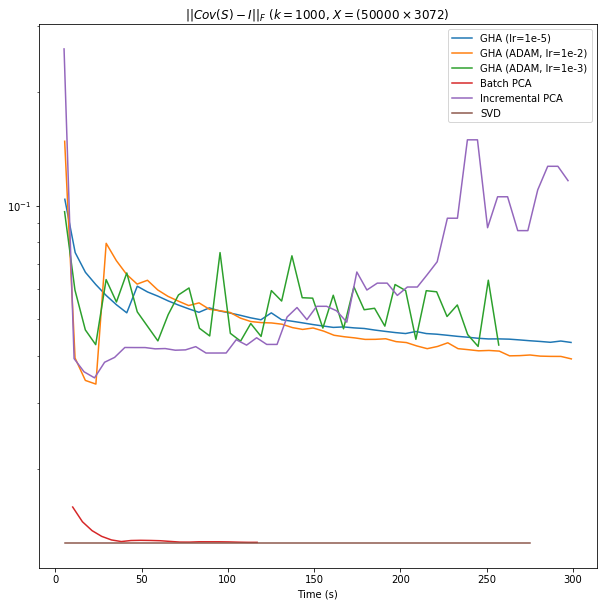

In [52]:
#loss_ppca = np.asarray(loss_ppca)
loss_gha   = np.asarray(loss_gha)
loss_gha2   = np.asarray(loss_gha2)
#loss_gha3   = np.asarray(loss_gha3)
loss_batch  = np.asarray(loss_batch)
loss_inc = np.asarray(loss_inc)
#loss_hebb = np.asarray(loss_hebb)
loss_pca = np.asarray(loss_pca)


# plt.plot(loss_ppca.T[0], loss_ppca.T[1], label="ppca")
plt.plot(loss_gha.T[0], loss_gha.T[1], label="GHA (lr=1e-5)")
plt.plot(loss_gha2.T[0], loss_gha2.T[1], label="GHA (ADAM, lr=1e-2)")
plt.plot(loss_gha3.T[0], loss_gha3.T[1], label="GHA (ADAM, lr=1e-3)")
plt.plot(loss_batch.T[0], loss_batch.T[1], label="Batch PCA")
plt.plot(loss_inc.T[0], loss_inc.T[1], label="Incremental PCA")
# plt.plot(loss_hebb.T[0], loss_hebb.T[1], label="Hebbian Autoencoder")
plt.plot(loss_gha.T[0][:len(loss_pca)], loss_pca, label="SVD")
plt.legend()
plt.title("$||Cov(S)-I||_F$ ($k=1000$, $X=(50000 \\times 3072)$")
plt.xlabel("Time (s)")
#plt.ylabel("$||COV[S] - Id||_{frob}$")
plt.yscale("log")
import matplotlib2tikz
matplotlib2tikz.save("whiteneing1000components.tex")

In [ ]:
W_pca = fit_pca(X, n_components=n_components)
loss_pca = frob_cov_white(W_pca)
loss_pca = [loss_pca] * len(loss_ppca)

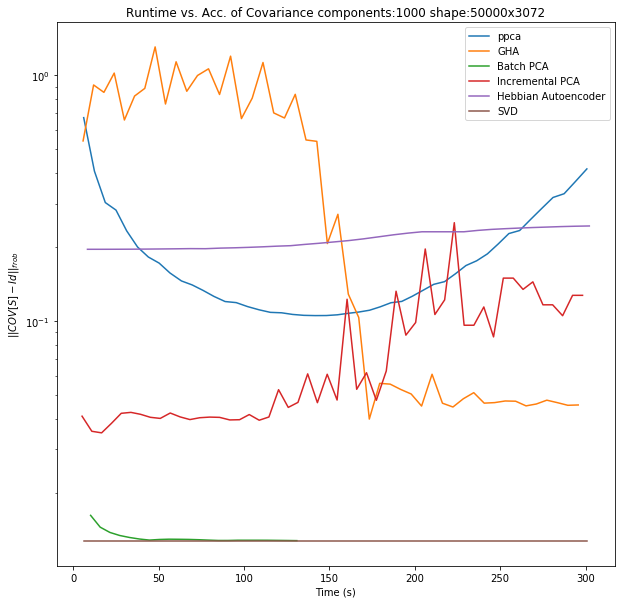

In [66]:
loss_ppca = np.asarray(loss_ppca)
loss_gha   = np.asarray(loss_gha)
loss_batch  = np.asarray(loss_batch)
loss_inc = np.asarray(loss_inc)
loss_hebb = np.asarray(loss_hebb)
loss_pca = np.asarray(loss_pca)

plt.plot(loss_ppca.T[0], loss_ppca.T[1], label="ppca")
plt.plot(loss_gha.T[0], loss_gha.T[1], label="GHA")
plt.plot(loss_batch.T[0], loss_batch.T[1], label="Batch PCA")
plt.plot(loss_inc.T[0], loss_inc.T[1], label="Incremental PCA")
plt.plot(loss_hebb.T[0], loss_hebb.T[1], label="Hebbian Autoencoder")
plt.plot(loss_ppca.T[0], loss_pca, label="SVD")
plt.legend()
plt.title("$||Cov(S)-I||_F$ ($k=100$, $X=(50000 \\times 3072)$")
plt.xlabel("Time (s)")
plt.ylabel("$||COV[S] - Id||_{frob}$")
plt.yscale("log")

## Code

In [ ]:
loss_ppca = []
t0 = time.time()
model = GMM(X.shape[1], n_components, 1)

def evaluate():
    while True:
        time.sleep(5)
        if STOP or (time.time() - t0) > t_max:
            break
        model._compute_sphering_()
        W_ppca = model.W[0].detach().cpu().numpy() / X.std().reshape(-1, 1) 
        # W_ppca = W_ppca / (X @ W_ppca).std(0)
        loss = time.time() - t0, frob_cov_white(W_ppca)
        print(loss)
        loss_ppca.append(loss)
        
STOP = False
eval_thread = Thread(target=evaluate)
eval_thread.start()
model.fit(X / X.std(), epochs=100, log_interval=5, bs=100, reset=False, lr=1e-5)
STOP = True

In [48]:
from fasterica import *

loss_gha3 = []
t0 = time.time()
model = FasterICA(n_components, whitening_strategy="GHA", optimizer="adam")

def evaluate():
    while True:
        time.sleep(5)
        if STOP or (time.time() - t0) > t_max:
            break
        W_gha = model.sphering_matrix
        W_gha = W_gha / X.std().reshape(-1, 1)
        loss = time.time() - t0, frob_cov_white(W_gha)
        print(loss)
        loss_gha3.append(loss)

STOP = False
eval_thread = Thread(target=evaluate)
eval_thread.start()
model.fit(X / X.std(), epochs=5, bs=100, lr=1e-3, logging=1)
STOP = True

100%|█████████▉| 499/500 [00:49<00:00,  9.99it/s]
Ep.  0 - 0.7506 - validation (loss/white/kurt/mi/logp): 0.7246 / 0.05 / 0.38 / -0.0724 / -0.7246 (eval took: 1.5s)
(53.54349112510681, 0.04779010409541237)
(59.47882008552551, 0.04375242236320836)
(65.44762134552002, 0.05137446184003807)
(71.40412497520447, 0.05794143529049931)
(77.5146541595459, 0.06047372685808159)
(83.55362224578857, 0.04727396945672383)
(89.51537823677063, 0.04509765838381207)
(95.50808000564575, 0.07507248437383143)
(101.47945427894592, 0.04582263624577818)
Ep.  1 - 0.7273 - validation (loss/white/kurt/mi/logp): 0.7245 / 0.05 / 0.37 / -0.0771 / -0.7245 (eval took: 1.8s)
(107.40562605857849, 0.04368993015227905)
(113.30861449241638, 0.04865364259201168)
(119.29123139381409, 0.04497045696988983)
(125.25619792938232, 0.05951166411568095)
(131.20792245864868, 0.05582680968917284)
(137.16902470588684, 0.07361818906354235)
(143.14089918136597, 0.05697156582905394)
(149.1956033706665, 0.056816616129523906)
Ep.  2 - 0.7258

In [ ]:
from fasterica import *

loss_gha1 = []
t0 = time.time()
model = FasterICA(n_components, whitening_strategy="GHA", optimizer="adam")
model.cpu()

def evaluate():
    while True:
        time.sleep(5)
        if STOP or (time.time() - t0) > t_max:
            break
        W_gha = model.sphering_matrix
        W_gha = W_gha / X.std().reshape(-1, 1)
        loss = time.time() - t0, frob_cov_white(W_gha)
        print(loss)
        loss_gha1.append(loss)

STOP = False
eval_thread = Thread(target=evaluate)
eval_thread.start()
model.fit(X / X.std(), epochs=5, bs=n_components, lr=1e-1, logging=1)
STOP = True


  0%|          | 0/50 [00:00<?, ?it/s](44.43573808670044, 0.19578025710713656)
(87.54606223106384, 0.19578025710713656)
(119.17565178871155, 0.19578025710713656)


In [46]:
from fasterica import *

loss_gha2 = []
t0 = time.time()
model = FasterICA(n_components, whitening_strategy="GHA", optimizer="adam")

def evaluate():
    while True:
        time.sleep(5)
        if STOP or (time.time() - t0) > t_max:
            break
        W_gha = model.sphering_matrix
        W_gha = W_gha / X.std().reshape(-1, 1)
        loss = time.time() - t0, frob_cov_white(W_gha)
        print(loss)
        loss_gha2.append(loss)

STOP = False
eval_thread = Thread(target=evaluate)
eval_thread.start()
model.fit(X / X.std(), epochs=5, bs=100, lr=1e-2, logging=1)
STOP = True


 10%|█         | 51/500 [00:05<01:04,  6.94it/s](5.45664119720459, 0.14826249462403676)

 22%|██▏       | 112/500 [00:11<00:41,  9.28it/s](11.469616651535034, 0.03940472711045483)

 34%|███▍      | 169/500 [00:16<00:34,  9.73it/s](17.449501514434814, 0.034362065371781485)

 46%|████▌     | 230/500 [00:23<00:31,  8.66it/s](23.54017472267151, 0.03360129967925782)

 57%|█████▋    | 287/500 [00:29<00:33,  6.44it/s](29.510642528533936, 0.07945169217140838)

 69%|██████▉   | 345/500 [00:35<00:24,  6.24it/s](35.401641845703125, 0.0714778424651265)

 81%|████████  | 404/500 [00:41<00:15,  6.28it/s](41.42376208305359, 0.0656502693989484)

 93%|█████████▎| 463/500 [00:47<00:03,  9.67it/s](47.44807457923889, 0.06192495326300813)

100%|█████████▉| 499/500 [00:51<00:00,  9.78it/s]
Ep.  0 - 0.8086 - validation (loss/white/kurt/mi/logp): 0.7257 / 0.06 / 0.40 / -0.1674 / -0.7257 (eval took: 1.5s)
(53.441977977752686, 0.06338160536585048)
(59.373990535736084, 0.0597573468794098)
(65.35538339614868, 0.

(293.06962060928345, 0.03979169024105435)
(299.115359544754, 0.039197226092270415)
 20%|██        | 102/500 [05:24<21:05,  3.18s/it]


KeyboardInterrupt: 

In [41]:
loss_gha = []
t0 = time.time()
model = HebbianLinearLayer(X.shape[1], n_components)

def evaluate():
    while True:
        time.sleep(5)
        if STOP or (time.time() - t0) > t_max:
            break
        W_gha = model.get_w(True, True)
        W_gha = W_gha / X.std().reshape(-1, 1)
        loss = time.time() - t0, frob_cov_white(W_gha)
        print(loss)
        loss_gha.append(loss)

STOP = False
eval_thread = Thread(target=evaluate)
eval_thread.start()
model.fit(X / X.std(), epochs=100, bs=100, lr=1e-5, log_interval=100)
STOP = True

Begin training: 100 epochs.


(5.548422336578369, 0.104005211203318)
(11.551061153411865, 0.0750691168733404)
(17.48999834060669, 0.06653603955750655)
(23.50305414199829, 0.06174284441145551)
(29.521318197250366, 0.05776647849142)
(35.462132692337036, 0.05457683650529117)
(41.445680141448975, 0.05194946206801014)
(47.538432121276855, 0.06112060561370961)
(53.513214111328125, 0.05900520072537084)
(59.46932864189148, 0.05752488996585467)
(65.46144819259644, 0.05587224241133294)
(71.41847038269043, 0.054465521482436205)
(77.431809425354, 0.053208341485133745)
(83.2977659702301, 0.05211009656274924)
(89.26774549484253, 0.05354100952815746)
(95.25376296043396, 0.0525509482094581)
(101.23503470420837, 0.05188660888580724)
(107.22384762763977, 0.05117097243421997)
(113.20965337753296, 0.05038779297877566)
(119.19298434257507, 0.04978343982605197)
(125.22670602798462, 0.051932668794828274)
(131.21124172210693, 0.049794771322193766)
(137.20042276382446, 0.04935105059985645)
(143.1892488002777, 0.04886702259889013)
(149.1750

KeyboardInterrupt: 

In [39]:
loss_batch = []
t0 = time.time()
model = BatchIncrementalPCA(X.shape[1], n_components)

def evaluate():
    time.sleep(5)
    while True:
        time.sleep(5)
        if STOP or (time.time() - t0) > t_max:
            break
        W_batch_pca = model.get_w(True, True)
        loss = time.time() - t0, frob_cov_white(W_batch_pca)
        print(loss)
        loss_batch.append(loss)       

STOP = False
eval_thread = Thread(target=evaluate)
eval_thread.start()
model.fit(X, epochs=3, log_interval=1, bs=n_components)
STOP = True

X is not centered. Subtracting mean 410.0276794433594.
Scheduler: 8 learning rates decreased by factor 0.1 after 2000 epochs, early stopping after 100, min mode.
Begin training: 3 epochs.


(10.101312637329102, 0.01584690240658869)
(15.738793849945068, 0.014483966761884409)
(21.346575021743774, 0.013715023406312659)
(26.915294885635376, 0.013244540769508817)
(32.58221650123596, 0.012958102706251171)


Epoch: 1 - loss(trn):35.74901, kurt(trn):1.15, cov(trn):0.48, std(trn):1.00, sig(trn):0.99, lr=0.00000. [35s] @1417 samples/s 


(38.28083372116089, 0.01283158238093598)
(43.88737106323242, 0.012913499886265457)
(49.52524995803833, 0.01292958406307873)
(55.178343772888184, 0.012917544513087688)
(60.87301516532898, 0.012896305584589094)
(66.60120058059692, 0.012841844278054189)
(72.21412110328674, 0.012790518011956608)


Epoch: 2 - loss(trn):35.67475, kurt(trn):1.15, cov(trn):0.34, std(trn):1.00, sig(trn):0.99, lr=0.00000. [36s] @1359 samples/s 


(77.8210608959198, 0.012787596206799224)
(83.36665368080139, 0.012814677613579416)
(89.11874175071716, 0.012813137181896195)
(94.81405282020569, 0.012813109269031805)
(100.52733016014099, 0.012803271381236552)
(106.0812418460846, 0.012782689582177268)


KeyboardInterrupt: 

(111.65081667900085, 0.012769477763318755)
(117.00911283493042, 0.012769477763318755)


In [28]:
loss_inc = []
t0 = time.time()
model = IncrementalPCA(X.shape[1], n_components, whiten=False)
STOP = False

def evaluate():
    while True:
        time.sleep(5)
        if STOP or (time.time() - t0) > t_max:
            break
        W_inc_pca = model.get_w(True, True)
        loss = time.time() - t0, frob_cov_white(W_inc_pca)
        loss_inc.append(loss)
        print(loss)
    
eval_thread = Thread(target=evaluate)
eval_thread.start()
model.fit(X, epochs=1, log_interval=1, bs=10)
STOP = True

X is not centered. Subtracting mean 410.0276794433594.
Scheduler: 8 learning rates decreased by factor 0.1 after 2000 epochs, early stopping after 100, min mode.
Begin training: 1 epochs.


(2.0680084228515625, 0.2607746362192782)
(5.097140550613403, 0.2607746362192782)
(7.92220139503479, 0.03926310698502465)
(10.912301063537598, 0.03926310698502465)
(13.938147068023682, 0.03622432926255747)
(16.678654432296753, 0.03622432926255747)
(19.817613124847412, 0.03490507712480933)
(22.764061212539673, 0.03490507712480933)
(25.82069206237793, 0.03490507712480933)
(28.601282119750977, 0.03840251790451821)
(31.712466716766357, 0.03840251790451821)
(34.39419674873352, 0.03955660648857737)
(37.76959991455078, 0.03955660648857737)
(40.32172226905823, 0.04202577749221071)
(43.58938813209534, 0.04202577749221071)
(46.170674085617065, 0.04200782064741799)
(49.49762511253357, 0.04200782064741799)
(52.08778214454651, 0.04200782064741799)
(55.37801241874695, 0.04167907998455167)
(57.89099597930908, 0.04167907998455167)
(61.14410138130188, 0.041754325364582234)
(63.7105131149292, 0.041754325364582234)
(67.07172393798828, 0.04133378776628835)
(69.57092094421387, 0.04133378776628835)
(72.96068

KeyboardInterrupt: 

In [ ]:
loss_hebb = []
t0 = time.time()
model = HebbianAutoencoder(X.shape[1], n_components)

def evaluate():
    while True:
        time.sleep(5)
        if STOP or (time.time() - t0) > t_max:
            break
        W_hebb = model.get_sphering(X / X.std(), True)/ X.std().reshape(-1, 1)
        loss = time.time() - t0, frob_cov_white(W_hebb)
        print(loss)
        loss_hebb.append(loss)
    
STOP = False
eval_thread = Thread(target=evaluate)
eval_thread.start()

model.fit(X / X.std(), epochs=10, lr=1e-5, log_interval=1, bs=100)
STOP = True

# Full Pipeline ICA

### RICA

In [31]:
iterations = [1000000] # [1, 5, 10, 20, 40, 60, 100, 200, 500, 1000, 2000]
bs=50
iters_per_epoch = X.shape[0]//bs
kurt_scores_rica = []
mi_rica = []
logps_rica = []
times_rica = []
mi_opt_rica = []
t0 = time.time()
X_ = X.reshape(len(X), 3, 32, 32)

for i, max_iters in enumerate(iterations):
    
    np.random.seed(42)
    
    mut_inf_opt = []
    mut_inf = []
    score = []
    logp = []
    mut_inf = []
    tt = []
    for j in range(1):
        model = ConvRICA(32, stride=16,  overcomplete=n_components/X.shape[1], input_shape=(3, 32, 32), tiles_width=-1, tiles_stride=-1, loss="logcosh", n_subspaces=-1, layout="overlap_grid")
        model.fit(X_, epochs=max([i+1, max_iters//iters_per_epoch]), bs=bs, log_interval=20, validation_ratio=0., lbd=2)
        W = model.get_I(True)
        S = X_valid @ W

        tt.append(time.time() - t0)
        mut_inf_opt.append(mutual_information(S))
        score.append(kurt(S))
        logp.append(logcosh_normalized(S).mean())
        mut_inf.append(mutual_information_approx(S, logcosh))

    times_rica.append(tt)
    mi_opt_rica.append(mut_inf_opt)
    mi_rica.append(mut_inf)
    kurt_scores_rica.append(score)
    logps_rica.append(logp)
    print(max_iters, "kurtosis:", score, "logp:", logp, "mi:", mut_inf, times_rica[-1])

Scheduler: 3 learning rates decreased by factor 0.1 after 2000 epochs, early stopping after 250, min mode.
Begin training: 1000 epochs.
Epoch: 20 - loss(trn):17991.42169, kurt(trn):25.39, cov(trn):9.99, std(trn):0.04, skew(trn):3.91, lr=0.00010. [2s] @24101 samples/s 
Epoch: 40 - loss(trn):5254.01294, kurt(trn):39.68, cov(trn):10.00, std(trn):0.02, skew(trn):4.72, lr=0.00010. [2s] @23704 samples/s 
Epoch: 60 - loss(trn):2167.34005, kurt(trn):52.65, cov(trn):10.00, std(trn):0.01, skew(trn):5.34, lr=0.00010. [2s] @23621 samples/s 
Epoch: 80 - loss(trn):1028.25280, kurt(trn):57.86, cov(trn):10.00, std(trn):0.00, skew(trn):5.58, lr=0.00010. [2s] @23655 samples/s 
Epoch: 100 - loss(trn):539.16956, kurt(trn):73.32, cov(trn):10.00, std(trn):0.00, skew(trn):6.14, lr=0.00010. [2s] @24139 samples/s 
Epoch: 120 - loss(trn):306.23489, kurt(trn):82.86, cov(trn):10.00, std(trn):0.00, skew(trn):6.54, lr=0.00010. [2s] @23707 samples/s 
Epoch: 140 - loss(trn):185.06589, kurt(trn):96.74, cov(trn):10.00,

loading best model..
1000000 kurtosis: [0.36392543] logp: [-2.2092974] mi: [-17.347983987936377] [2504.810877084732]


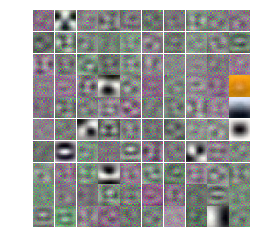

In [32]:
show_filters_color( model.get_I(True))
plt.show()
show_filters_color( np.linalg.pinv(model.get_I(True)).T)

### FasterICA (ppca)

In [18]:
iterations = [100000]#[1, 5, 10, 20, 40, 60, 100, 200, 500, 1000, 2000]
bs=50
iters_per_epoch = X.shape[0]//bs

kurt_scores_fasterica = []
mi_fasterica = []
logps_fasterica = []
times_fasterica = []
mi_opt_fasterica = []
t0 = time.time()
for i, max_iters in enumerate(iterations):
    
    np.random.seed(55)
    torch.manual_seed(55)
    
    mut_inf = []
    mut_inf_opt = []
    score = []
    logp = []
    tt = []
    for j in range(1):
        model = FasterICA(X.shape[1], n_components, whitening_algo="ppca", loss="logcosh")
        model.fit(X / X.std(), epochs=max([i+1, max_iters//iters_per_epoch]), lr=1e-4, log_interval=-1, bs=bs, beta_whitening=1., optimizer="adam")
        W = model.get_I(True) / X.std().reshape(-1, 1)
        S = X_valid @ W

        tt.append(time.time() -t0)
        mut_inf_opt.append(mutual_information(S[permut]))
        score.append(kurt(S))
        logp.append(logcosh_normalized(S).mean())
        mut_inf.append(mutual_information_approx(S, logcosh))
    
    times_fasterica.append(tt)
    mi_fasterica.append(mut_inf)
    mi_opt_fasterica.append(mut_inf_opt)
    kurt_scores_fasterica.append(score)
    logps_fasterica.append(logp)
    print(max_iters, "kurtosis:", score, "logp:", logp, "mi:", mut_inf)

Begin training: 100 epochs.
Epoch: 1 - loss(trn):3375.82433, kurt(trn):0.27, cov(trn):69.46, skew(trn):-0.00, std(trn):2.69, sig(trn):0.99, lr=0.00010. [13s] @3811 samples/s 
Epoch: 2 - loss(trn):3077.92433, kurt(trn):0.29, cov(trn):42.83, skew(trn):-0.00, std(trn):2.17, sig(trn):0.99, lr=0.00010. [12s] @3857 samples/s 
Epoch: 3 - loss(trn):2834.05637, kurt(trn):0.32, cov(trn):22.75, skew(trn):-0.01, std(trn):1.69, sig(trn):0.99, lr=0.00010. [13s] @3820 samples/s 
Epoch: 4 - loss(trn):2599.38452, kurt(trn):0.34, cov(trn):16.41, skew(trn):0.00, std(trn):1.48, sig(trn):0.98, lr=0.00010. [12s] @3879 samples/s 
Epoch: 5 - loss(trn):2362.06029, kurt(trn):0.40, cov(trn):13.17, skew(trn):-0.00, std(trn):1.37, sig(trn):0.99, lr=0.00010. [13s] @3821 samples/s 
Epoch: 6 - loss(trn):2094.28787, kurt(trn):0.48, cov(trn):11.31, skew(trn):-0.00, std(trn):1.29, sig(trn):0.98, lr=0.00010. [13s] @3775 samples/s 
Epoch: 7 - loss(trn):1843.30110, kurt(trn):0.55, cov(trn):9.85, skew(trn):-0.00, std(trn):1

Epoch: 57 - loss(trn):1689.20986, kurt(trn):2.94, cov(trn):3.32, skew(trn):-0.00, std(trn):1.03, sig(trn):0.98, lr=0.00010. [13s] @3829 samples/s 
Epoch: 58 - loss(trn):1690.94905, kurt(trn):2.96, cov(trn):3.26, skew(trn):-0.00, std(trn):1.03, sig(trn):0.98, lr=0.00010. [13s] @3841 samples/s 
Epoch: 59 - loss(trn):1690.13740, kurt(trn):3.00, cov(trn):3.24, skew(trn):-0.01, std(trn):1.02, sig(trn):0.98, lr=0.00010. [12s] @3860 samples/s 
Epoch: 60 - loss(trn):1676.57846, kurt(trn):3.04, cov(trn):3.23, skew(trn):-0.02, std(trn):1.02, sig(trn):0.99, lr=0.00010. [13s] @3838 samples/s 
Epoch: 61 - loss(trn):1675.07819, kurt(trn):3.00, cov(trn):3.19, skew(trn):-0.01, std(trn):1.02, sig(trn):0.99, lr=0.00010. [12s] @3874 samples/s 
Epoch: 62 - loss(trn):1678.97575, kurt(trn):3.00, cov(trn):3.14, skew(trn):-0.01, std(trn):1.02, sig(trn):0.99, lr=0.00010. [13s] @3770 samples/s 
Epoch: 63 - loss(trn):1685.37020, kurt(trn):3.06, cov(trn):3.12, skew(trn):-0.00, std(trn):1.02, sig(trn):0.99, lr=0.0

100000 kurtosis: [2.9773943] logp: [-2.8087428] mi: [-17.57912549833201]


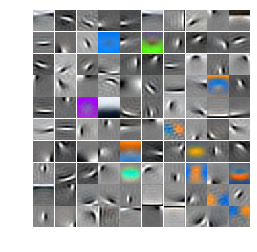

In [21]:
show_filters_color(W)
plt.show()
show_filters_color(np.linalg.pinv(W).T)

### FasterICA (incremental)

In [22]:
iterations = [100000]#[1, 5, 10, 20, 40, 60, 100, 200, 500, 1000, 2000]
bs=50
iters_per_epoch = X.shape[0]//bs

kurt_scores_fasterica = []
mi_fasterica = []
logps_fasterica = []
times_fasterica = []
mi_opt_fasterica = []
t0 = time.time()
for i, max_iters in enumerate(iterations):
    
    np.random.seed(55)
    torch.manual_seed(55)
    
    mut_inf = []
    mut_inf_opt = []
    score = []
    logp = []
    tt = []
    for j in range(1):
        model = FasterICA(X.shape[1], n_components, whitening_algo="incremental", loss="logcosh")
        model.fit(X / X.std(), epochs=2, lr=1e-4, log_interval=-1, bs=bs, lambda_ica=0., optimizer="adam")
        model.fit(X / X.std(), epochs=max([i+1, max_iters//iters_per_epoch]), lr=1e-4, log_interval=-1, bs=bs, beta_whitening=0., optimizer="adam")
        W = model.get_I(True) / X.std().reshape(-1, 1)
        S = X_valid @ W

        tt.append(time.time() -t0)
        mut_inf_opt.append(mutual_information(S[permut]))
        score.append(kurt(S))
        logp.append(logcosh_normalized(S).mean())
        mut_inf.append(mutual_information_approx(S, logcosh))
    
    times_fasterica.append(tt)
    mi_fasterica.append(mut_inf)
    mi_opt_fasterica.append(mut_inf_opt)
    kurt_scores_fasterica.append(score)
    logps_fasterica.append(logp)
    print(max_iters, "kurtosis:", score, "logp:", logp, "mi:", mut_inf)

Begin training: 2 epochs.
Epoch: 1 - loss(trn):8.93269, kurt(trn):0.60, cov(trn):0.92, skew(trn):-0.00, std(trn):1.00, sig(trn):1.03, lr=0.00010. [336s] @148 samples/s 
Epoch: 2 - loss(trn):8.94015, kurt(trn):0.60, cov(trn):0.93, skew(trn):0.00, std(trn):1.00, sig(trn):0.99, lr=0.00010. [337s] @148 samples/s 
Begin training: 100 epochs.
Epoch: 1 - loss(trn):40.63010, kurt(trn):0.69, cov(trn):0.95, skew(trn):0.01, std(trn):1.00, sig(trn):1.00, lr=0.00010. [3s] @14363 samples/s 
Epoch: 2 - loss(trn):40.49312, kurt(trn):0.81, cov(trn):0.95, skew(trn):0.01, std(trn):1.00, sig(trn):1.01, lr=0.00010. [3s] @14337 samples/s 
Epoch: 3 - loss(trn):40.06446, kurt(trn):0.91, cov(trn):0.94, skew(trn):0.00, std(trn):1.00, sig(trn):0.99, lr=0.00010. [3s] @14360 samples/s 
Epoch: 4 - loss(trn):39.90690, kurt(trn):1.01, cov(trn):0.93, skew(trn):0.01, std(trn):1.00, sig(trn):0.97, lr=0.00010. [3s] @14305 samples/s 
Epoch: 5 - loss(trn):39.81797, kurt(trn):1.12, cov(trn):0.95, skew(trn):0.00, std(trn):1.

Epoch: 56 - loss(trn):37.51390, kurt(trn):2.86, cov(trn):0.96, skew(trn):-0.01, std(trn):1.00, sig(trn):0.98, lr=0.00010. [3s] @14286 samples/s 
Epoch: 57 - loss(trn):37.72395, kurt(trn):2.85, cov(trn):0.95, skew(trn):-0.01, std(trn):1.00, sig(trn):1.00, lr=0.00010. [3s] @14245 samples/s 
Epoch: 58 - loss(trn):37.59912, kurt(trn):2.94, cov(trn):0.93, skew(trn):-0.01, std(trn):1.00, sig(trn):0.98, lr=0.00010. [3s] @14398 samples/s 
Epoch: 59 - loss(trn):37.62372, kurt(trn):2.97, cov(trn):0.95, skew(trn):0.00, std(trn):1.00, sig(trn):1.04, lr=0.00010. [3s] @14249 samples/s 
Epoch: 60 - loss(trn):37.55799, kurt(trn):2.94, cov(trn):0.95, skew(trn):0.00, std(trn):1.00, sig(trn):1.01, lr=0.00010. [3s] @14167 samples/s 
Epoch: 61 - loss(trn):37.58132, kurt(trn):2.91, cov(trn):0.94, skew(trn):-0.02, std(trn):1.00, sig(trn):0.96, lr=0.00010. [3s] @14195 samples/s 
Epoch: 62 - loss(trn):37.71886, kurt(trn):2.87, cov(trn):0.95, skew(trn):0.01, std(trn):1.00, sig(trn):0.98, lr=0.00010. [3s] @14202

100000 kurtosis: [2.8245423] logp: [-2.7902884] mi: [-17.304125996244224]


In [24]:
show_filters_color(W)
plt.show()
show_filters_color(np.linalg.pinv(W).T)

In [1]:
t0 = time.time()

#model = FasterICA(X.shape[1], 400, mode="incremental", loss="logcosh")

######## WHITEN ###########
#model.fit(X, epochs= 2, log_interval=1, bs=10, lambda_ica=0.)

######## ICA ###########
model.fit(X, epochs=300, log_interval=10, bs=50, beta_whitening=0., adam=True)
W_fica = model.get_I(True)

time.time() - t0

NameError: name 'time' is not defined

(-0.5, 659.5, 659.5, -0.5)

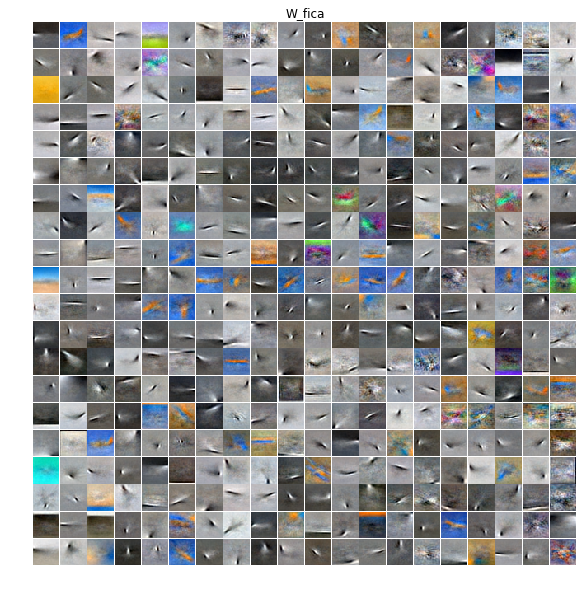

In [26]:
plt.rcParams["figure.figsize"] = (10, 10)

plt.title("W_fica")
show_filters_color(np.linalg.pinv(W_fica).T, C=3)
plt.axis("off")

In [1260]:
t0 = time.time()

######## WHITEN ###########
model = GMM(X.shape[1], n_components, 1)
X_num_stable = X / X.std()                                                        # rescale to mitigate numerical issues
model.fit(X_num_stable, epochs=100, log_interval=5, bs=100, reset=False, lr=1e-4)  # fitting
W_ppca = model.W[0].detach().cpu().numpy() / X.std().reshape(-1, 1)               # undo numerical mitigation
W_ppca = W_ppca / (X @ W_ppca).std(0)                                             # recalibrate the diagonal variance

######## ICA ##############
model = FasterICA(n_components, n_components, mode="None", loss="logcosh")
model.fit(X @ W_ppca, epochs=50, log_interval=10, bs=50, beta_whitening=0., adam=True)
W_fica = model.get_I(True) 

time.time() - t0

Begin training: 100 epochs.
Epoch: 5 - loss(trn):2830.38071, lr=0.00010. [6s] @8301 samples/s 
Epoch: 10 - loss(trn):2282.65188, lr=0.00010. [6s] @8094 samples/s 
Epoch: 15 - loss(trn):1693.73047, lr=0.00010. [6s] @8027 samples/s 
Epoch: 20 - loss(trn):1645.92218, lr=0.00010. [6s] @8215 samples/s 
Epoch: 25 - loss(trn):1645.36312, lr=0.00010. [6s] @8018 samples/s 
Epoch: 30 - loss(trn):1641.06669, lr=0.00010. [6s] @7933 samples/s 
Epoch: 35 - loss(trn):1652.15580, lr=0.00010. [6s] @7980 samples/s 
Epoch: 40 - loss(trn):1646.96193, lr=0.00010. [6s] @7945 samples/s 
Epoch: 45 - loss(trn):1645.12880, lr=0.00010. [5s] @8435 samples/s 
Epoch: 50 - loss(trn):1644.59785, lr=0.00010. [6s] @8297 samples/s 
Epoch: 55 - loss(trn):1643.17342, lr=0.00010. [6s] @7988 samples/s 
Epoch: 60 - loss(trn):1647.81817, lr=0.00010. [5s] @8513 samples/s 
Epoch: 65 - loss(trn):1638.39897, lr=0.00010. [6s] @8012 samples/s 
Epoch: 70 - loss(trn):1636.43589, lr=0.00010. [6s] @8162 samples/s 
Epoch: 75 - loss(trn)

loading best model..


Scheduler: 3 learning rates decreased by factor 0.1 after 2000 epochs, early stopping after 100, min mode.
Begin training: 50 epochs.
Epoch: 10 - loss(trn):37.36501, kurt(trn):3.09, cov(trn):2.85, skew(trn):0.02, std(trn):0.98, lr=0.00100. [2s] @17001 samples/s 
Epoch: 20 - loss(trn):37.35923, kurt(trn):3.04, cov(trn):2.89, skew(trn):0.02, std(trn):0.98, lr=0.00100. [2s] @16922 samples/s 
Epoch: 30 - loss(trn):37.55409, kurt(trn):3.02, cov(trn):2.87, skew(trn):0.02, std(trn):0.98, lr=0.00100. [3s] @16650 samples/s 
Epoch: 40 - loss(trn):37.64102, kurt(trn):3.03, cov(trn):2.84, skew(trn):0.01, std(trn):0.98, lr=0.00100. [2s] @16804 samples/s 
Epoch: 50 - loss(trn):37.63112, kurt(trn):3.05, cov(trn):2.86, skew(trn):0.01, std(trn):0.99, lr=0.00100. [2s] @16818 samples/s 


loading best model..


902.9734077453613

(-0.5, 329.5, 329.5, -0.5)

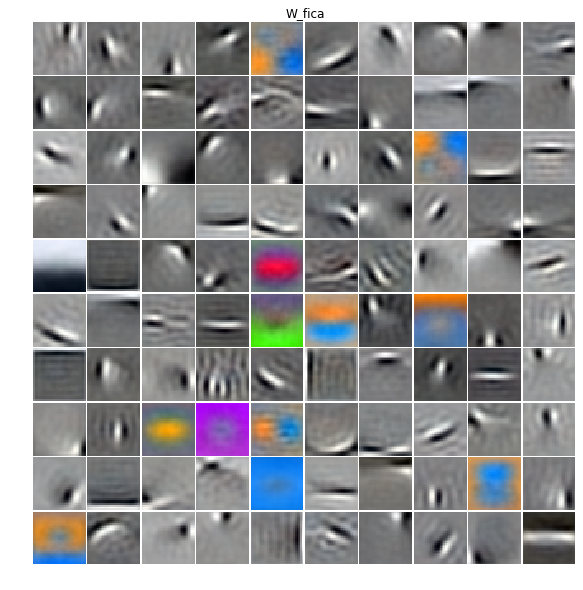

In [1263]:
plt.title("W_fica")
np.save("CIFAR10_W_pca_W_fica.npy", W_ppca @ W_fica )
show_filters_color(np.linalg.pinv(W_ppca @ W_fica).T, C=3)
plt.axis("off")

In [1253]:
t0 = time.time()

######## WHITEN ###########
model = GMM(X.shape[1], n_components, 10)
X_num_stable = X / X.std()                                                        # rescale to mitigate numerical issues
model.fit(X_num_stable, epochs=200, log_interval=5, bs=100, reset=True, lr=1e-4) # fitting
assignments = np.concatenate([model.map_component(X_num_stable[i:i+100]) for i in range(len(X)//100)])

time.time() - t0

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
Begin training: 200 epochs.
Epoch: 5 - loss(trn):1306.93344, lr=0.00010. [47s] @1042 samples/s 
Epoch: 10 - loss(trn):1266.64090, lr=0.00010. [47s] @1044 samples/s 
Epoch: 15 - loss(trn):1262.52692, lr=0.00010. [47s] @1042 samples/s 
Epoch: 20 - loss(trn):1260.58369, lr=0.00010. [47s] @1043 samples/s 
Epoch: 25 - loss(trn):1253.13524, lr=0.00010. [47s] @1047 samples/s 
Epoch: 30 - loss(trn):1246.71891, lr=0.00010. [47s] @1042 samples/s 
Epoch: 35 - loss(trn):1253.12215, lr=0.00010. [47s] @1046 samples/s 
Epoch: 40 - loss(trn):1244.55267, lr=0.00010. [47s] @1047 samples/s 
Epoch: 45 - loss(trn):1241.97294, lr=0.00010. [47s] @1051 samples/s 
Epoch: 50 - loss(trn):1233.75026, lr=0.00010. [47s] @1049 samples/s 
Epoch: 55 - loss(trn):1240.17998, lr=0.00010. [47s] @1047 samples/s 
Epoch: 60 - loss(trn):1234.05175, lr=0.00010. [47s] @1050 samples/s 
Epoch: 65 - loss(trn):1238.69364, lr=0.00010. [47s] 

loading best model..


12330.45902633667

In [1254]:
W_ppca0  = model.W[2].detach().cpu().numpy()  / X.std().reshape(-1, 1)              # undo numerical mitigation
mu_ppca0 = model.mu[2].detach().cpu().numpy() / X.std().reshape(-1, 1)
W_ppca1  = model.W[1].detach().cpu().numpy()  / X.std().reshape(-1, 1)              # undo numerical mitigation
mu_ppca1 = model.mu[1].detach().cpu().numpy() / X.std().reshape(-1, 1)              # undo numerical mitigation

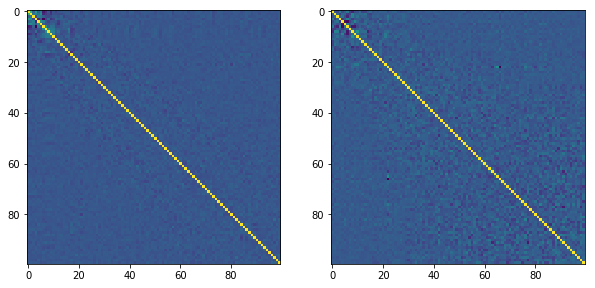

(None, array([1.00019529, 1.00018944, 1.00018563, 1.00018357, 1.00020346,
        1.00016927, 1.00015719, 1.00019444, 1.00019674, 1.00019515,
        1.00015634, 1.00019217, 1.00018646, 1.00019203, 1.00020384,
        1.00017926, 1.00018027, 1.00018825, 1.00018876, 1.00017526,
        1.00019028, 1.00019606, 1.000193  , 1.00019927, 1.00017176,
        1.0002249 , 1.00019286, 1.00017205, 1.00017791, 1.0002031 ,
        1.00019368, 1.00018888, 1.00021513, 1.00020997, 1.00019119,
        1.00018462, 1.00019017, 1.0001677 , 1.00020481, 1.00018402,
        1.0002178 , 1.00019263, 1.00019665, 1.00018956, 1.00018388,
        1.00019348, 1.00018287, 1.00020099, 1.00019554, 1.00021194,
        1.00019797, 1.00021019, 1.0002012 , 1.00018382, 1.00019048,
        1.00020933, 1.00018528, 1.00018585, 1.00019394, 1.00020077,
        1.0001969 , 1.0002098 , 1.00020775, 1.00018696, 1.00019976,
        1.00019558, 1.00018353, 1.00016938, 1.00020318, 1.00018794,
        1.00018002, 1.00018538, 1.00020076

In [1255]:
W_ppca0 = W_ppca0 / ((X[assignments == 2] - mu_ppca0)  @ W_ppca0).std(0)  # recalibrate the diagonal variance
cov = np.cov( (  ((X[assignments == 2] - mu_ppca0) @ W_ppca0).T))
plt.subplot(1,2,1)
plt.imshow(cov)

W_ppca1 = W_ppca1 / ((X[assignments == 1] - mu_ppca1)  @ W_ppca1).std(0) # recalibrate the diagonal variance
cov2 = np.cov( (  ((X[assignments == 1] - mu_ppca1) @ W_ppca1).T))
plt.subplot(1,2,2)
plt.imshow(cov2)
plt.show(), np.diag(cov), np.diag(cov2)

In [1256]:
######## ICA 0 ##############
X_cluster0 = (X[assignments == 2] - mu_ppca0)

model_ = FasterICA(n_components, n_components, mode="None", loss="logcosh")
model_.fit(X_cluster0 @ W_ppca0, epochs=50, lr=1e-3, log_interval=10, bs=50, beta_whitening=0., adam=True)
W_fica0 = model_.get_I(True) 

time.time() - t0

X is not centered. Subtracting mean 22333.06640625.
Scheduler: 3 learning rates decreased by factor 0.1 after 2000 epochs, early stopping after 100, min mode.
Begin training: 50 epochs.
Epoch: 10 - loss(trn):38.86014, kurt(trn):1.73, cov(trn):3.46, skew(trn):0.03, std(trn):0.99, lr=0.00100. [0s] @17661 samples/s 
Epoch: 20 - loss(trn):38.13185, kurt(trn):2.38, cov(trn):3.46, skew(trn):-0.00, std(trn):0.98, lr=0.00100. [0s] @17102 samples/s 
Epoch: 30 - loss(trn):37.73817, kurt(trn):2.76, cov(trn):3.46, skew(trn):-0.01, std(trn):0.98, lr=0.00100. [0s] @17319 samples/s 
Epoch: 40 - loss(trn):37.48415, kurt(trn):2.99, cov(trn):3.46, skew(trn):-0.01, std(trn):0.98, lr=0.00100. [0s] @17001 samples/s 
Epoch: 50 - loss(trn):37.36901, kurt(trn):3.07, cov(trn):3.46, skew(trn):-0.00, std(trn):0.98, lr=0.00100. [0s] @17571 samples/s 


loading best model..


12350.918852329254

In [1257]:
######## ICA 1 ##############
X_cluster1 = (X[assignments == 1] - mu_ppca1)

model_ = FasterICA(n_components, n_components, mode="None", loss="logcosh")
model_.fit(X_cluster1 @ W_ppca1, epochs=50, lr=1e-3, log_interval=10, bs=50, beta_whitening=0., adam=True)
W_fica1 = model_.get_I(True) 

time.time() - t0

X is not centered. Subtracting mean 30529.00390625.
Scheduler: 3 learning rates decreased by factor 0.1 after 2000 epochs, early stopping after 100, min mode.
Begin training: 50 epochs.
Epoch: 10 - loss(trn):38.08901, kurt(trn):1.87, cov(trn):5.76, skew(trn):0.06, std(trn):0.93, lr=0.00100. [0s] @17074 samples/s 
Epoch: 20 - loss(trn):37.24146, kurt(trn):2.47, cov(trn):5.77, skew(trn):0.06, std(trn):0.92, lr=0.00100. [0s] @16986 samples/s 
Epoch: 30 - loss(trn):36.87117, kurt(trn):2.82, cov(trn):5.77, skew(trn):0.08, std(trn):0.92, lr=0.00100. [0s] @17029 samples/s 
Epoch: 40 - loss(trn):36.70586, kurt(trn):2.97, cov(trn):5.77, skew(trn):0.09, std(trn):0.93, lr=0.00100. [0s] @17471 samples/s 
Epoch: 50 - loss(trn):36.62822, kurt(trn):3.06, cov(trn):5.77, skew(trn):0.09, std(trn):0.93, lr=0.00100. [0s] @17360 samples/s 


loading best model..


12367.84448504448

(-0.5, 329.5, 329.5, -0.5)

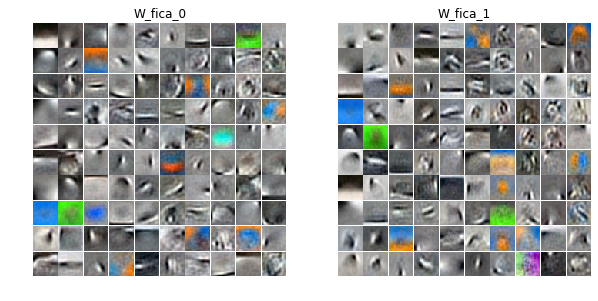

In [1258]:
plt.rcParams["figure.figsize"] = (10, 10)

plt.subplot(1,2,1)
plt.title("W_fica_0")
show_filters_color(np.linalg.pinv(W_ppca0 @ W_fica0).T, C=3)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("W_fica_1")
show_filters_color(np.linalg.pinv(W_ppca1 @ W_fica1).T, C=3)
plt.axis("off")

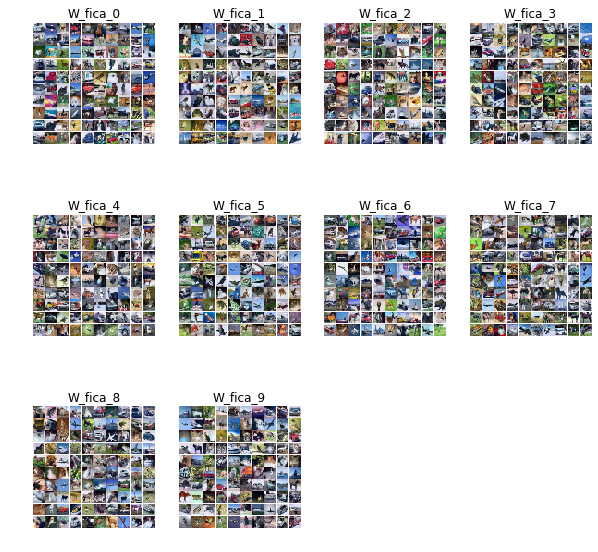

In [1259]:
for i in range(10):
    samples = X[assignments == i][:100]
    if len(samples) > 0:
        plt.subplot(3,4,i+1)
        plt.title("W_fica_" + str(i))
        show_filters_color(samples.T, C=3)
        plt.axis("off")